In [1]:
# 📦 Imports and Configuration

import os
import json
import random
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

In [2]:
# 📁 src/data/load_dataset.py
# ➤ Function for loading the dataset from CSV

def load_dataset():
    df = pd.read_csv(DATA_PATH)
    print(f"Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")
    return df

In [3]:
# 📁 src/models/mlp_model.py
# ➤ Definition of the MLP architecture with customizable activation function

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, activation_fn):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            activation_fn(),
            nn.Linear(hidden_dim, hidden_dim),
            activation_fn(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.model(x)


In [4]:
# 📁 src/metrics/regression_metrics.py
# ➞ Function to compute regression metrics: MSE, MAE, R²

def evaluate_regression(y_true, y_pred):
    y_true_np = y_true.detach().cpu().numpy()
    y_pred_np = y_pred.detach().cpu().numpy()

    # 🔍 Remove NaNs before computing metrics
    mask = ~np.isnan(y_true_np) & ~np.isnan(y_pred_np)
    y_true_np = y_true_np[mask]
    y_pred_np = y_pred_np[mask]

    if len(y_true_np) == 0 or len(y_pred_np) == 0:
        raise ValueError("No valid data points after removing NaNs.")

    mse = mean_squared_error(y_true_np, y_pred_np)
    mae = mean_absolute_error(y_true_np, y_pred_np)
    r2 = r2_score(y_true_np, y_pred_np)

    return {"MSE": mse, "MAE": mae, "R2": r2}


In [5]:
# 📁 src/tuning/train_mlp_function.py
# ➤ Train MLP model with specified hyperparameters and seed
# ➤ Includes data loading, train-test split, early stopping, and evaluation
# ➤ Returns run_id and evaluation metrics on hold-out set


def train_mlp(hidden_dim, lr, batch_size, epochs, output_dim=1, activation_fn=nn.ReLU, optimizer_name="Adam", seed=None):
    if seed is not None:
        torch.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)

    # ----------------------------
    # Load dataset
    # ----------------------------
    df = load_dataset()
    X = df[['X_int', 'Y_int', 'X_fac', 'Y_fac', 'Ang']]
    y = df[['StdDev']]
    input_dim = X.shape[1]

    # 🔀 Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

    # 📊 Plot distribution of target in train and test
    plt.figure(figsize=(8, 4))
    plt.hist(y_train.values, bins=30, alpha=0.6, label="Train", color='blue')
    plt.hist(y_test.values, bins=30, alpha=0.6, label="Test", color='orange')
    plt.title(f"🎯 Target Distribution (seed={seed})")
    plt.xlabel("Mean target value")
    plt.ylabel("Count")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 🧪 Проверка на пересечение train и test
    intersection = set(X_train.index).intersection(set(X_test.index))
    if intersection:
        print(f"⚠️ Warning: Found {len(intersection)} overlapping samples in train and test!")
    else:
        print("✅ Train and test are properly separated (no overlap).")



    # Convert to tensors
    X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).to(device)
    X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).to(device)

    # ----------------------------
    # Model creation
    # ----------------------------
    model = MLP(input_dim, hidden_dim, output_dim, activation_fn=activation_fn).to(device)
    criterion = nn.MSELoss()

    if optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=lr)
    elif optimizer_name == "RMSprop":
        optimizer = optim.RMSprop(model.parameters(), lr=lr)
    elif optimizer_name == "AdamW":
        optimizer = optim.AdamW(model.parameters(), lr=lr)
    else:
        raise ValueError(f"Unknown optimizer: {optimizer_name}")

    early_stopping_patience = 100
    best_loss = float("inf")
    patience_counter = 0
    train_loss_history = []

    for epoch in tqdm(range(epochs), desc="Epochs"):
        model.train()
        optimizer.zero_grad()
        output = model(X_train_tensor)
        loss = criterion(output, y_train_tensor)
        loss.backward()
        optimizer.step()

        current_loss = loss.item()
        train_loss_history.append(current_loss)

        log_interval = max(1, epochs // 10)
        if (epoch + 1) % log_interval == 0 or (epoch + 1) == epochs:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {current_loss:.4f}")

        # Early Stopping
        if current_loss < best_loss:
            best_loss = current_loss
            patience_counter = 0
            best_weights = model.state_dict()
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print(f"⏹️ Early stopping at epoch {epoch+1}")
                break

    run_id = f"run_seed_{seed}"

    model.load_state_dict(best_weights)
    weights_registry[run_id] = best_weights


    # ----------------------------
    # Evaluate
    # ----------------------------
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test_tensor)
        metrics = evaluate_regression(y_test_tensor, y_pred)

    print(f"\n📊 Metrics:\n{metrics}")
    return run_id, metrics


First model configuration
config_mlp_128h_6e-03lr

In [6]:
# 📁 src/tuning/setup_paths.py
# ➤ Paths for hyperparameter search: tuning runs, logs, results

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

DATA_PATH = "/kaggle/input/windloading-train/WindLoading_Train.csv"
SAVE_ROOT = "/kaggle/working/config_mlp_128h_4e-03lr"
config_path = '/kaggle/input/wind-fluctuation-prediction-final-model/config_mlp_128h_4e-03lr_ex.json'

# DATA_PATH = "/mnt/d/projects/wind_fluctuation_prediction_2025/data/processed/windloading_train.csv"
# SAVE_ROOT = "/mnt/d/projects/wind_fluctuation_prediction_2025/final_models/config_001"

In [7]:
# 📁 src/tuning/load_config.py
# ➤ Load best configuration from saved JSON, convert activation string to function,
# ➤ build readable architecture label for logging and saving results



# 🔁 Mapping string from config.json to actual PyTorch activation function
activation_map = {
    "ReLU": torch.nn.ReLU,
    "Tanh": torch.nn.Tanh,
    "LeakyReLU": torch.nn.LeakyReLU
}

# 📦 Load and decode configuration
with open(config_path, "r") as f:
    config = json.load(f)

# 🔧 Convert activation function string to callable object
config["activation_fn"] = activation_map[config["activation_fn"]]

# 🏷 Extract config name from path
# config_name = os.path.basename(os.path.dirname(config_path))  # → 'config_001'
# 🏷 Get config filename (without extension) to use as config_name
config_filename = os.path.basename(config_path)
config_name = os.path.splitext(config_filename)[0]


# 🧠 Build architecture label
arch_label = (
    f"mlp_{config['hidden_dim']}h_"
    f"{config['lr']:.0e}lr_"
    f"{config['batch_size']}bs_"
    f"{config['epochs']}ep_"
    f"{config['activation_fn'].__name__}_"
    f"{config['optimizer_name']}"
)

print("✅ Loaded config:")
print(config)
print(f"📂 SAVE_ROOT: {SAVE_ROOT}")
print(f"📁 arch_label: {arch_label}")

✅ Loaded config:
{'input_dim': 5, 'hidden_dim': 128, 'output_dim': 1, 'lr': 0.004, 'epochs': 10000, 'batch_size': 16, 'activation_fn': <class 'torch.nn.modules.activation.Tanh'>, 'optimizer_name': 'Adam', 'features': ['X_int', 'Y_int', 'X_fac', 'Y_fac', 'Ang'], 'targets': ['StdDev']}
📂 SAVE_ROOT: /kaggle/working/config_mlp_128h_4e-03lr
📁 arch_label: mlp_128h_4e-03lr_16bs_10000ep_Tanh_Adam



🔁 Run 1 / 50 (seed = 0)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


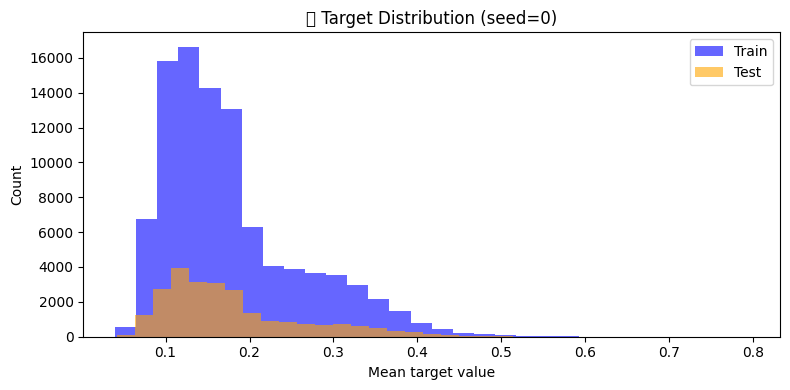

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1018/10000 [00:06<00:57, 156.18it/s]

Epoch [1000/10000], Loss: 0.0038


Epochs:  17%|█▋        | 1734/10000 [00:11<00:55, 149.77it/s]


⏹️ Early stopping at epoch 1735

📊 Metrics:
{'MSE': 0.00303187, 'MAE': 0.04045345, 'R2': 0.5618739887251188}

🔁 Run 2 / 50 (seed = 1)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


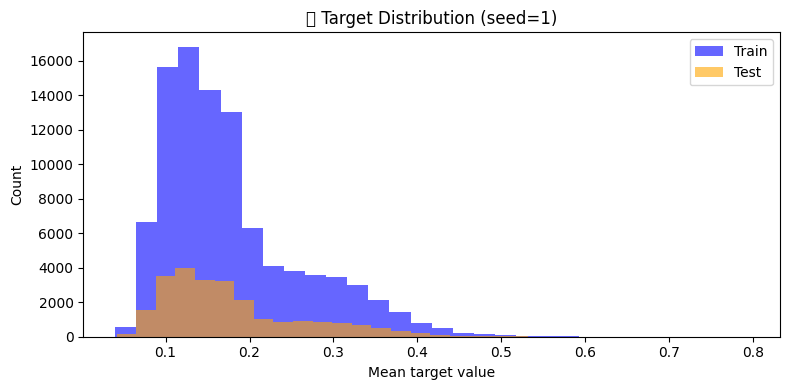

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1026/10000 [00:06<00:58, 154.48it/s]

Epoch [1000/10000], Loss: 0.0044


Epochs:  20%|██        | 2018/10000 [00:13<00:51, 153.73it/s]

Epoch [2000/10000], Loss: 0.0030


Epochs:  30%|███       | 3026/10000 [00:19<00:45, 152.56it/s]

Epoch [3000/10000], Loss: 0.0025


Epochs:  40%|████      | 4018/10000 [00:26<00:39, 150.42it/s]

Epoch [4000/10000], Loss: 0.0021


Epochs:  50%|█████     | 5021/10000 [00:32<00:33, 149.35it/s]

Epoch [5000/10000], Loss: 0.0018


Epochs:  60%|██████    | 6028/10000 [00:39<00:26, 148.67it/s]

Epoch [6000/10000], Loss: 0.0016


Epochs:  70%|███████   | 7018/10000 [00:46<00:20, 147.87it/s]

Epoch [7000/10000], Loss: 0.0014


Epochs:  80%|████████  | 8023/10000 [00:53<00:13, 146.33it/s]

Epoch [8000/10000], Loss: 0.0013


Epochs:  86%|████████▌ | 8554/10000 [00:56<00:09, 150.74it/s]


⏹️ Early stopping at epoch 8555

📊 Metrics:
{'MSE': 0.001324908, 'MAE': 0.024582053, 'R2': 0.8097340760358531}

🔁 Run 3 / 50 (seed = 2)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


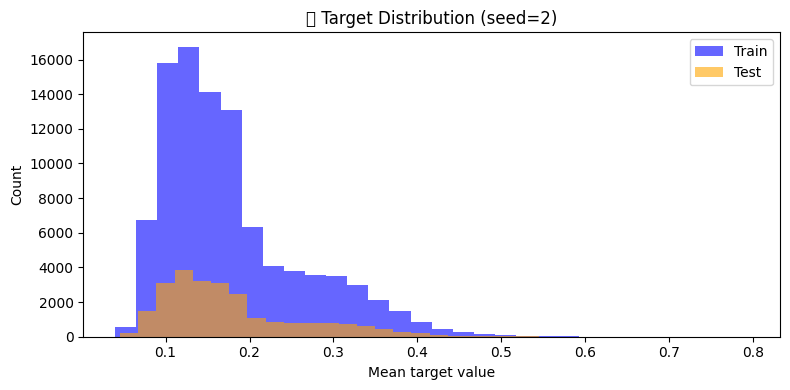

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1022/10000 [00:07<01:01, 144.99it/s]

Epoch [1000/10000], Loss: 0.0047


Epochs:  20%|██        | 2027/10000 [00:13<00:55, 143.76it/s]

Epoch [2000/10000], Loss: 0.0038


Epochs:  25%|██▍       | 2472/10000 [00:17<00:51, 144.77it/s]


⏹️ Early stopping at epoch 2473

📊 Metrics:
{'MSE': 0.0035571975, 'MAE': 0.043615825, 'R2': 0.48926662980585744}

🔁 Run 4 / 50 (seed = 3)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


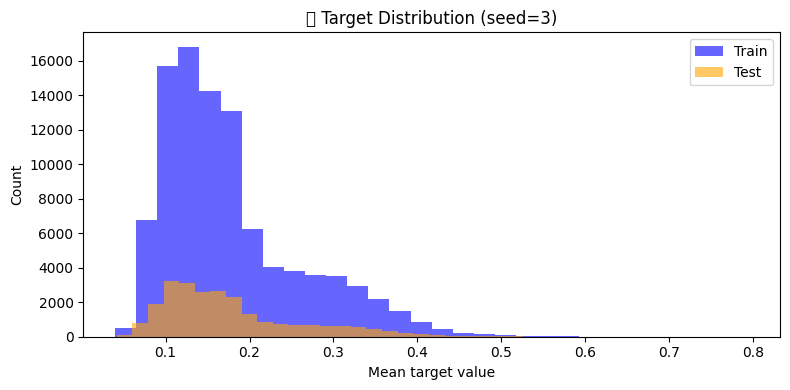

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1022/10000 [00:07<01:03, 141.01it/s]

Epoch [1000/10000], Loss: 0.0037


Epochs:  20%|██        | 2024/10000 [00:14<00:57, 139.86it/s]

Epoch [2000/10000], Loss: 0.0030


Epochs:  30%|███       | 3025/10000 [00:21<00:50, 138.69it/s]

Epoch [3000/10000], Loss: 0.0026


Epochs:  40%|████      | 4020/10000 [00:28<00:43, 137.90it/s]

Epoch [4000/10000], Loss: 0.0022


Epochs:  50%|█████     | 5019/10000 [00:35<00:35, 139.59it/s]

Epoch [5000/10000], Loss: 0.0019


Epochs:  60%|██████    | 6020/10000 [00:43<00:28, 140.52it/s]

Epoch [6000/10000], Loss: 0.0015


Epochs:  70%|███████   | 7025/10000 [00:50<00:21, 141.27it/s]

Epoch [7000/10000], Loss: 0.0016


Epochs:  74%|███████▍  | 7386/10000 [00:52<00:18, 140.08it/s]


⏹️ Early stopping at epoch 7387

📊 Metrics:
{'MSE': 0.0012468465, 'MAE': 0.024755565, 'R2': 0.8182297981443677}

🔁 Run 5 / 50 (seed = 4)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


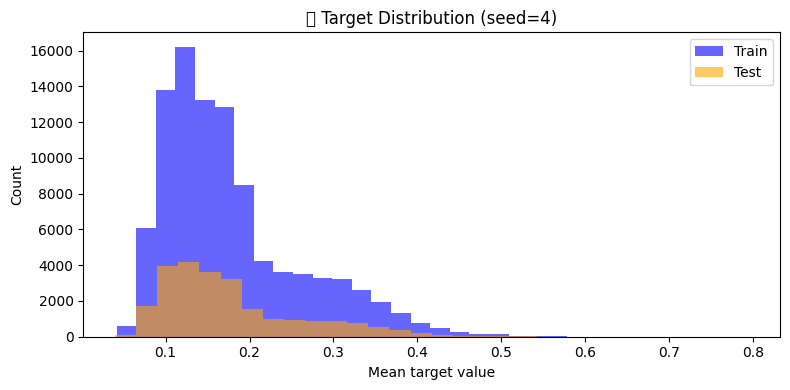

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1022/10000 [00:07<01:03, 142.11it/s]

Epoch [1000/10000], Loss: 0.0042


Epochs:  20%|██        | 2027/10000 [00:14<00:55, 142.56it/s]

Epoch [2000/10000], Loss: 0.0029


Epochs:  30%|███       | 3017/10000 [00:21<00:48, 142.52it/s]

Epoch [3000/10000], Loss: 0.0023


Epochs:  40%|████      | 4022/10000 [00:28<00:42, 141.64it/s]

Epoch [4000/10000], Loss: 0.0019


Epochs:  50%|█████     | 5027/10000 [00:35<00:35, 141.42it/s]

Epoch [5000/10000], Loss: 0.0016


Epochs:  60%|██████    | 6017/10000 [00:42<00:28, 141.12it/s]

Epoch [6000/10000], Loss: 0.0015


Epochs:  70%|███████   | 7022/10000 [00:49<00:21, 140.75it/s]

Epoch [7000/10000], Loss: 0.0013


Epochs:  80%|████████  | 8027/10000 [00:56<00:14, 140.74it/s]

Epoch [8000/10000], Loss: 0.0012


Epochs:  86%|████████▋ | 8630/10000 [01:00<00:09, 141.69it/s]


⏹️ Early stopping at epoch 8631

📊 Metrics:
{'MSE': 0.0018190942, 'MAE': 0.030692497, 'R2': 0.7359676330643021}

🔁 Run 6 / 50 (seed = 5)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


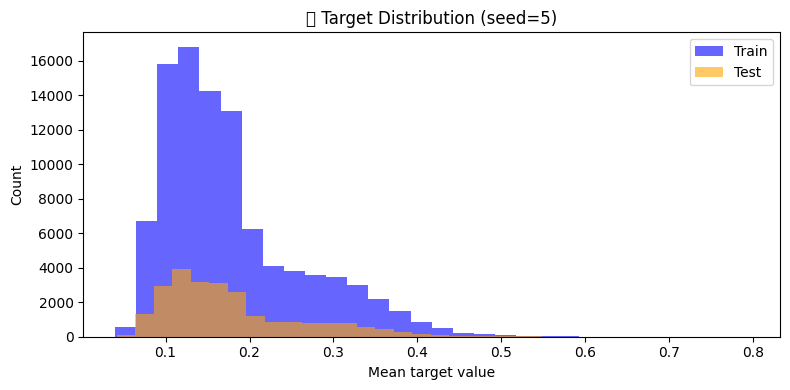

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1022/10000 [00:07<01:03, 141.93it/s]

Epoch [1000/10000], Loss: 0.0042


Epochs:  20%|██        | 2027/10000 [00:14<00:56, 142.25it/s]

Epoch [2000/10000], Loss: 0.0029


Epochs:  30%|███       | 3017/10000 [00:21<00:49, 142.02it/s]

Epoch [3000/10000], Loss: 0.0024


Epochs:  40%|████      | 4022/10000 [00:28<00:41, 142.35it/s]

Epoch [4000/10000], Loss: 0.0021


Epochs:  50%|█████     | 5027/10000 [00:35<00:35, 141.88it/s]

Epoch [5000/10000], Loss: 0.0018


Epochs:  60%|██████    | 6017/10000 [00:42<00:28, 141.84it/s]

Epoch [6000/10000], Loss: 0.0016


Epochs:  70%|███████   | 7022/10000 [00:49<00:20, 142.26it/s]

Epoch [7000/10000], Loss: 0.0017


Epochs:  80%|████████  | 8027/10000 [00:56<00:13, 142.60it/s]

Epoch [8000/10000], Loss: 0.0013


Epochs:  90%|█████████ | 9017/10000 [01:03<00:06, 142.16it/s]

Epoch [9000/10000], Loss: 0.0022


Epochs:  91%|█████████ | 9073/10000 [01:03<00:06, 142.29it/s]


⏹️ Early stopping at epoch 9074

📊 Metrics:
{'MSE': 0.0059882216, 'MAE': 0.054005574, 'R2': 0.14243237517805352}

🔁 Run 7 / 50 (seed = 6)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


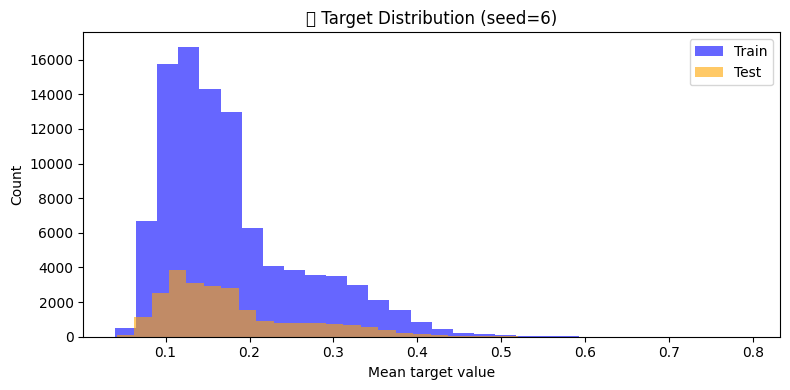

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1022/10000 [00:07<01:03, 141.90it/s]

Epoch [1000/10000], Loss: 0.0041


Epochs:  20%|██        | 2027/10000 [00:14<00:55, 142.60it/s]

Epoch [2000/10000], Loss: 0.0029


Epochs:  30%|███       | 3017/10000 [00:21<00:49, 142.32it/s]

Epoch [3000/10000], Loss: 0.0027


Epochs:  40%|████      | 4022/10000 [00:28<00:41, 142.39it/s]

Epoch [4000/10000], Loss: 0.0021


Epochs:  50%|█████     | 5027/10000 [00:35<00:34, 142.52it/s]

Epoch [5000/10000], Loss: 0.0017


Epochs:  60%|██████    | 6017/10000 [00:42<00:28, 141.72it/s]

Epoch [6000/10000], Loss: 0.0014


Epochs:  70%|███████   | 7022/10000 [00:49<00:20, 141.91it/s]

Epoch [7000/10000], Loss: 0.0013


Epochs:  80%|████████  | 8027/10000 [00:56<00:13, 142.10it/s]

Epoch [8000/10000], Loss: 0.0012


Epochs:  90%|█████████ | 9017/10000 [01:03<00:06, 141.57it/s]

Epoch [9000/10000], Loss: 0.0010


Epochs:  94%|█████████▍| 9446/10000 [01:06<00:03, 142.10it/s]


⏹️ Early stopping at epoch 9447

📊 Metrics:
{'MSE': 0.0010930984, 'MAE': 0.02283835, 'R2': 0.841379343677474}

🔁 Run 8 / 50 (seed = 7)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


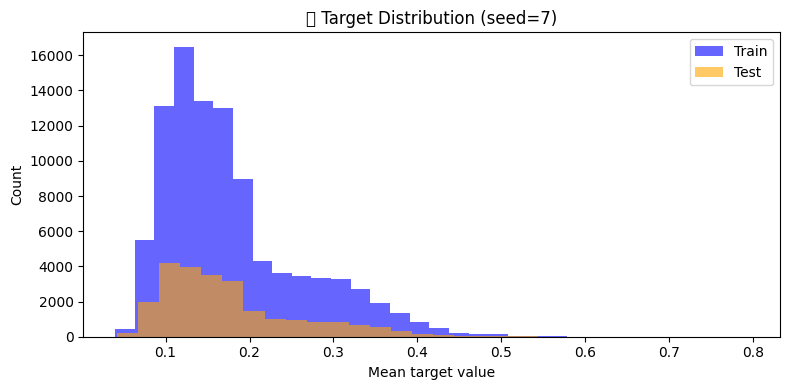

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1022/10000 [00:07<01:03, 140.84it/s]

Epoch [1000/10000], Loss: 0.0045


Epochs:  20%|██        | 2027/10000 [00:14<00:55, 142.43it/s]

Epoch [2000/10000], Loss: 0.0035


Epochs:  30%|███       | 3017/10000 [00:21<00:49, 141.72it/s]

Epoch [3000/10000], Loss: 0.0026


Epochs:  40%|████      | 4022/10000 [00:28<00:42, 141.58it/s]

Epoch [4000/10000], Loss: 0.0024


Epochs:  50%|█████     | 5027/10000 [00:35<00:35, 141.38it/s]

Epoch [5000/10000], Loss: 0.0017


Epochs:  60%|██████    | 6017/10000 [00:42<00:28, 141.04it/s]

Epoch [6000/10000], Loss: 0.0017


Epochs:  70%|███████   | 7022/10000 [00:49<00:21, 140.88it/s]

Epoch [7000/10000], Loss: 0.0015


Epochs:  80%|████████  | 8027/10000 [00:56<00:14, 140.85it/s]

Epoch [8000/10000], Loss: 0.0013


Epochs:  81%|████████  | 8124/10000 [00:57<00:13, 141.51it/s]


⏹️ Early stopping at epoch 8125

📊 Metrics:
{'MSE': 0.0013083292, 'MAE': 0.02444169, 'R2': 0.8093682392103895}

🔁 Run 9 / 50 (seed = 8)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


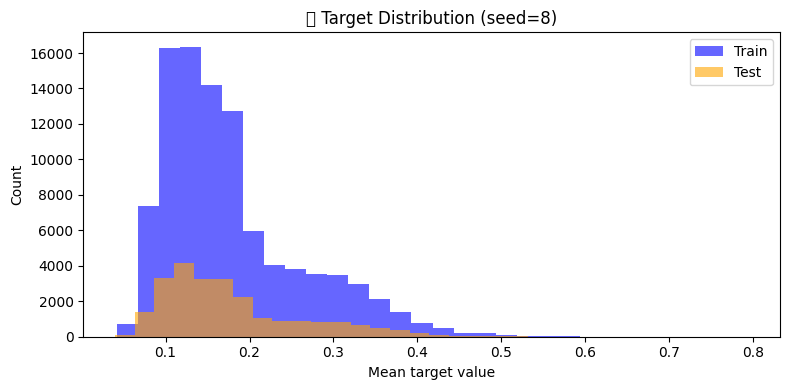

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1022/10000 [00:07<01:03, 142.10it/s]

Epoch [1000/10000], Loss: 0.0041


Epochs:  20%|██        | 2027/10000 [00:14<00:56, 141.25it/s]

Epoch [2000/10000], Loss: 0.0029


Epochs:  25%|██▌       | 2538/10000 [00:17<00:52, 141.55it/s]


⏹️ Early stopping at epoch 2539

📊 Metrics:
{'MSE': 0.0027546186, 'MAE': 0.037999798, 'R2': 0.605577132302532}

🔁 Run 10 / 50 (seed = 9)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


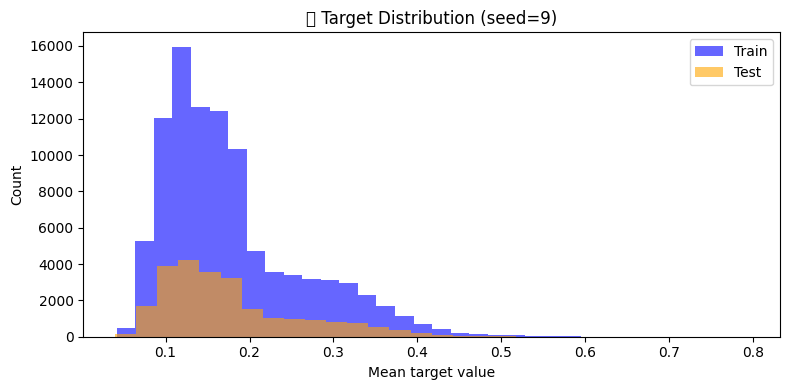

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1022/10000 [00:07<01:03, 141.81it/s]

Epoch [1000/10000], Loss: 0.0041


Epochs:  20%|██        | 2027/10000 [00:14<00:56, 142.04it/s]

Epoch [2000/10000], Loss: 0.0035


Epochs:  30%|███       | 3017/10000 [00:21<00:49, 141.93it/s]

Epoch [3000/10000], Loss: 0.0028


Epochs:  40%|████      | 4022/10000 [00:28<00:42, 141.75it/s]

Epoch [4000/10000], Loss: 0.0023


Epochs:  50%|█████     | 5027/10000 [00:35<00:35, 141.73it/s]

Epoch [5000/10000], Loss: 0.0017


Epochs:  60%|██████    | 6017/10000 [00:42<00:28, 141.74it/s]

Epoch [6000/10000], Loss: 0.0016


Epochs:  64%|██████▍   | 6387/10000 [00:45<00:25, 141.85it/s]


⏹️ Early stopping at epoch 6388

📊 Metrics:
{'MSE': 0.0016168717, 'MAE': 0.029365748, 'R2': 0.7662361391936665}

🔁 Run 11 / 50 (seed = 10)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


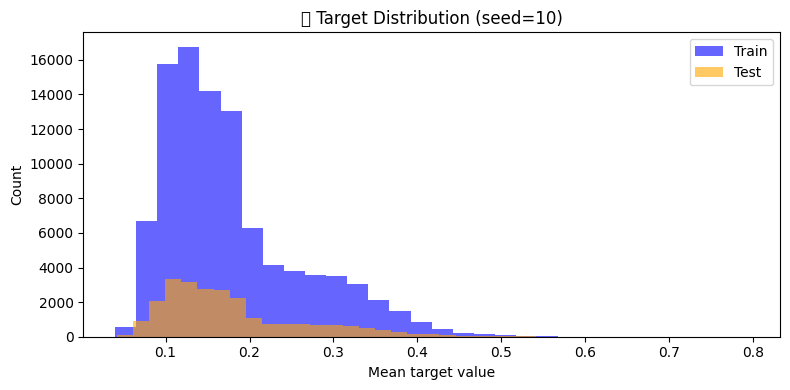

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1022/10000 [00:07<01:03, 141.81it/s]

Epoch [1000/10000], Loss: 0.0045


Epochs:  20%|██        | 2027/10000 [00:14<00:56, 141.22it/s]

Epoch [2000/10000], Loss: 0.0035


Epochs:  30%|███       | 3017/10000 [00:21<00:49, 141.62it/s]

Epoch [3000/10000], Loss: 0.0030


Epochs:  40%|████      | 4022/10000 [00:28<00:42, 141.43it/s]

Epoch [4000/10000], Loss: 0.0035


Epochs:  50%|█████     | 5027/10000 [00:35<00:35, 141.48it/s]

Epoch [5000/10000], Loss: 0.0025


Epochs:  60%|██████    | 6017/10000 [00:42<00:28, 141.31it/s]

Epoch [6000/10000], Loss: 0.0019


Epochs:  70%|███████   | 7022/10000 [00:49<00:21, 141.23it/s]

Epoch [7000/10000], Loss: 0.0015


Epochs:  73%|███████▎  | 7314/10000 [00:51<00:18, 141.53it/s]


⏹️ Early stopping at epoch 7315

📊 Metrics:
{'MSE': 0.001665929, 'MAE': 0.029452778, 'R2': 0.7617538650254054}

🔁 Run 12 / 50 (seed = 11)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


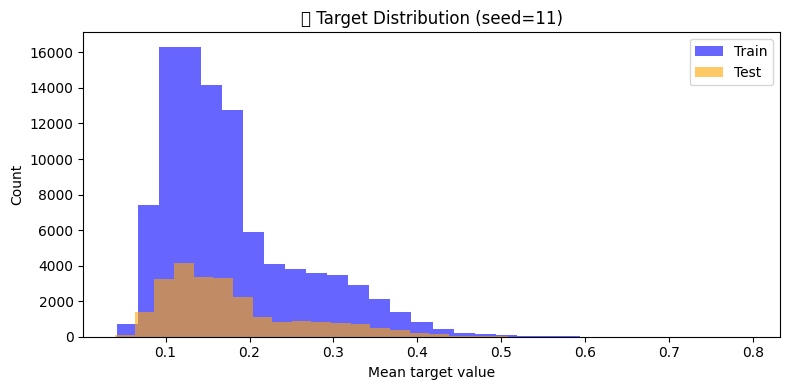

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1022/10000 [00:07<01:03, 141.22it/s]

Epoch [1000/10000], Loss: 0.0044


Epochs:  20%|██        | 2027/10000 [00:14<00:56, 141.47it/s]

Epoch [2000/10000], Loss: 0.0035


Epochs:  22%|██▏       | 2212/10000 [00:15<00:55, 141.07it/s]


⏹️ Early stopping at epoch 2213

📊 Metrics:
{'MSE': 0.003358086, 'MAE': 0.042364884, 'R2': 0.5130766784492983}

🔁 Run 13 / 50 (seed = 12)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


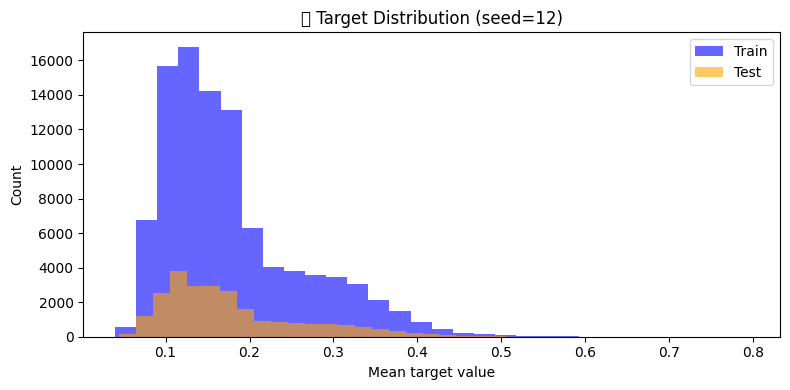

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1022/10000 [00:07<01:03, 140.72it/s]

Epoch [1000/10000], Loss: 0.0046


Epochs:  20%|██        | 2027/10000 [00:14<00:56, 141.51it/s]

Epoch [2000/10000], Loss: 0.0032


Epochs:  30%|███       | 3017/10000 [00:21<00:49, 141.41it/s]

Epoch [3000/10000], Loss: 0.0026


Epochs:  40%|████      | 4022/10000 [00:28<00:42, 141.53it/s]

Epoch [4000/10000], Loss: 0.0024


Epochs:  50%|█████     | 5027/10000 [00:35<00:35, 141.03it/s]

Epoch [5000/10000], Loss: 0.0023


Epochs:  52%|█████▏    | 5224/10000 [00:36<00:33, 141.37it/s]


⏹️ Early stopping at epoch 5225

📊 Metrics:
{'MSE': 0.0020068549, 'MAE': 0.032130472, 'R2': 0.7098795831265622}

🔁 Run 14 / 50 (seed = 13)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


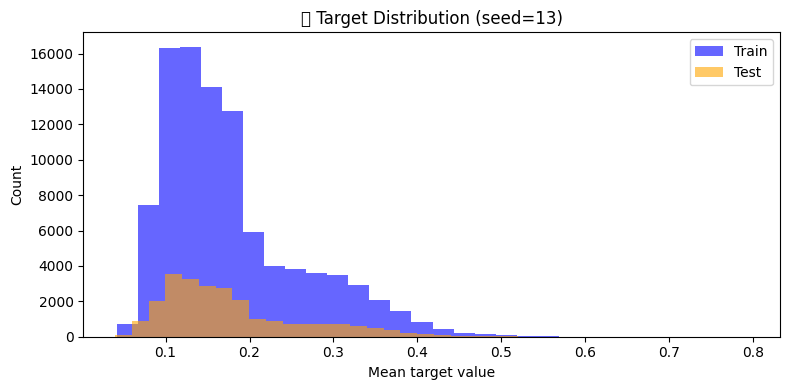

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1022/10000 [00:07<01:03, 142.09it/s]

Epoch [1000/10000], Loss: 0.0042


Epochs:  20%|██        | 2027/10000 [00:14<00:56, 141.83it/s]

Epoch [2000/10000], Loss: 0.0028


Epochs:  30%|███       | 3017/10000 [00:21<00:49, 142.23it/s]

Epoch [3000/10000], Loss: 0.0027


Epochs:  40%|███▉      | 3954/10000 [00:27<00:42, 142.08it/s]


⏹️ Early stopping at epoch 3955

📊 Metrics:
{'MSE': 0.0022589015, 'MAE': 0.033948086, 'R2': 0.6752729145557737}

🔁 Run 15 / 50 (seed = 14)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


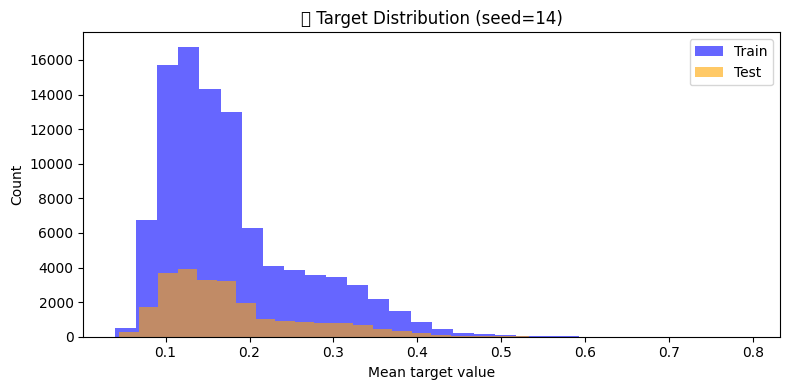

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1022/10000 [00:07<01:03, 141.63it/s]

Epoch [1000/10000], Loss: 0.0044


Epochs:  20%|██        | 2027/10000 [00:14<00:56, 141.30it/s]

Epoch [2000/10000], Loss: 0.0029


Epochs:  21%|██▏       | 2128/10000 [00:14<00:55, 141.93it/s]


⏹️ Early stopping at epoch 2129

📊 Metrics:
{'MSE': 0.0029734874, 'MAE': 0.039867822, 'R2': 0.5713787163324265}

🔁 Run 16 / 50 (seed = 15)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


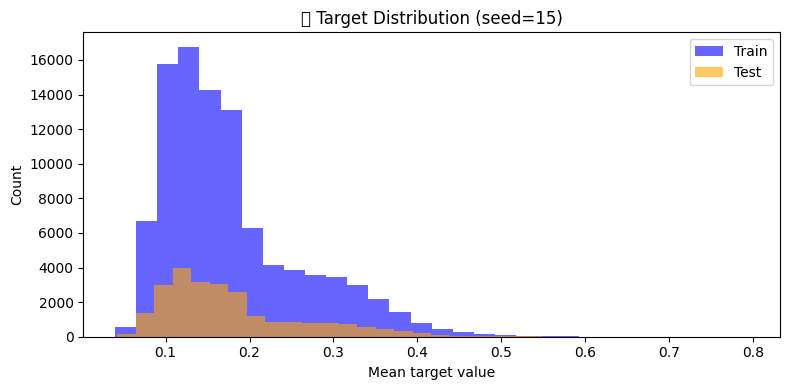

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1022/10000 [00:07<01:03, 142.19it/s]

Epoch [1000/10000], Loss: 0.0049


Epochs:  20%|██        | 2027/10000 [00:14<00:56, 142.09it/s]

Epoch [2000/10000], Loss: 0.0038


Epochs:  30%|███       | 3017/10000 [00:21<00:49, 142.18it/s]

Epoch [3000/10000], Loss: 0.0031


Epochs:  40%|████      | 4022/10000 [00:28<00:42, 142.25it/s]

Epoch [4000/10000], Loss: 0.0028


Epochs:  50%|█████     | 5027/10000 [00:35<00:35, 141.89it/s]

Epoch [5000/10000], Loss: 0.0029


Epochs:  60%|██████    | 6017/10000 [00:42<00:28, 141.97it/s]

Epoch [6000/10000], Loss: 0.0025


Epochs:  70%|███████   | 7022/10000 [00:49<00:21, 141.46it/s]

Epoch [7000/10000], Loss: 0.0016


Epochs:  80%|████████  | 8027/10000 [00:56<00:13, 141.72it/s]

Epoch [8000/10000], Loss: 0.0015


Epochs:  90%|█████████ | 9017/10000 [01:03<00:06, 141.77it/s]

Epoch [9000/10000], Loss: 0.0012


Epochs:  92%|█████████▏| 9233/10000 [01:05<00:05, 141.91it/s]


⏹️ Early stopping at epoch 9234

📊 Metrics:
{'MSE': 0.004964945, 'MAE': 0.05113969, 'R2': 0.2994463712173506}

🔁 Run 17 / 50 (seed = 16)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


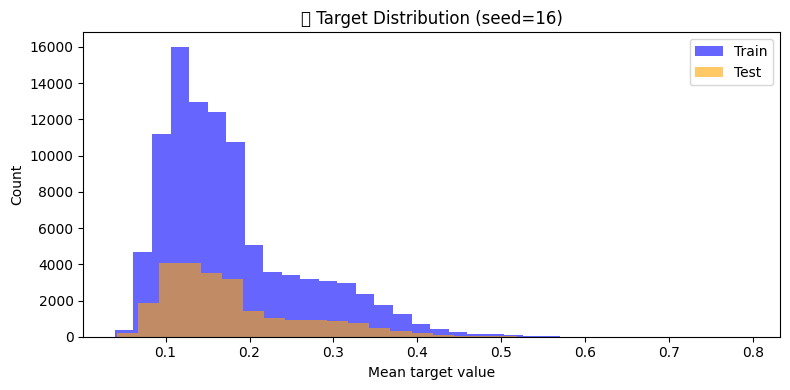

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1022/10000 [00:07<01:03, 141.45it/s]

Epoch [1000/10000], Loss: 0.0048


Epochs:  20%|██        | 2027/10000 [00:14<00:56, 141.73it/s]

Epoch [2000/10000], Loss: 0.0041


Epochs:  30%|███       | 3017/10000 [00:21<00:49, 141.67it/s]

Epoch [3000/10000], Loss: 0.0031


Epochs:  34%|███▍      | 3413/10000 [00:24<00:46, 141.67it/s]


⏹️ Early stopping at epoch 3414

📊 Metrics:
{'MSE': 0.002847289, 'MAE': 0.038707733, 'R2': 0.5871890523694296}

🔁 Run 18 / 50 (seed = 17)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


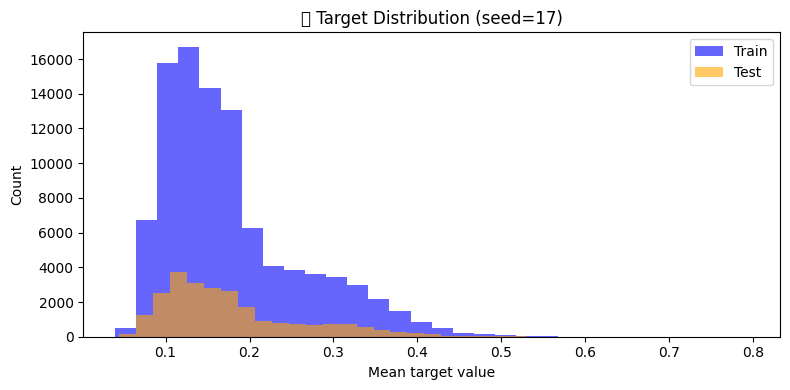

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1021/10000 [00:07<01:03, 141.36it/s]

Epoch [1000/10000], Loss: 0.0042


Epochs:  20%|█▉        | 1972/10000 [00:13<00:56, 141.44it/s]


⏹️ Early stopping at epoch 1973

📊 Metrics:
{'MSE': 0.0033944924, 'MAE': 0.04271319, 'R2': 0.5170538940554525}

🔁 Run 19 / 50 (seed = 18)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


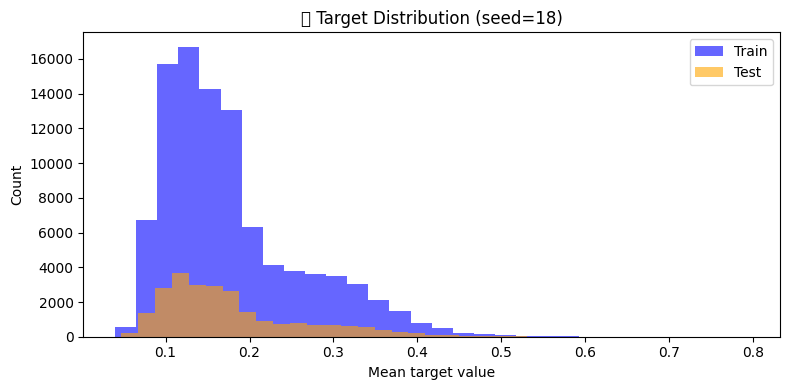

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1022/10000 [00:07<01:03, 141.56it/s]

Epoch [1000/10000], Loss: 0.0039


Epochs:  20%|██        | 2027/10000 [00:14<00:56, 141.40it/s]

Epoch [2000/10000], Loss: 0.0028


Epochs:  30%|███       | 3017/10000 [00:21<00:49, 141.26it/s]

Epoch [3000/10000], Loss: 0.0025


Epochs:  40%|████      | 4022/10000 [00:28<00:42, 141.45it/s]

Epoch [4000/10000], Loss: 0.0023


Epochs:  50%|█████     | 5027/10000 [00:35<00:35, 141.32it/s]

Epoch [5000/10000], Loss: 0.0026


Epochs:  60%|██████    | 6017/10000 [00:42<00:28, 140.49it/s]

Epoch [6000/10000], Loss: 0.0017


Epochs:  70%|███████   | 7022/10000 [00:49<00:21, 141.42it/s]

Epoch [7000/10000], Loss: 0.0021


Epochs:  80%|████████  | 8027/10000 [00:56<00:13, 141.04it/s]

Epoch [8000/10000], Loss: 0.0013


Epochs:  90%|█████████ | 9017/10000 [01:03<00:06, 141.34it/s]

Epoch [9000/10000], Loss: 0.0011


Epochs:  94%|█████████▍| 9441/10000 [01:06<00:03, 141.31it/s]


⏹️ Early stopping at epoch 9442

📊 Metrics:
{'MSE': 0.002594412, 'MAE': 0.038037837, 'R2': 0.6276519474146492}

🔁 Run 20 / 50 (seed = 19)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


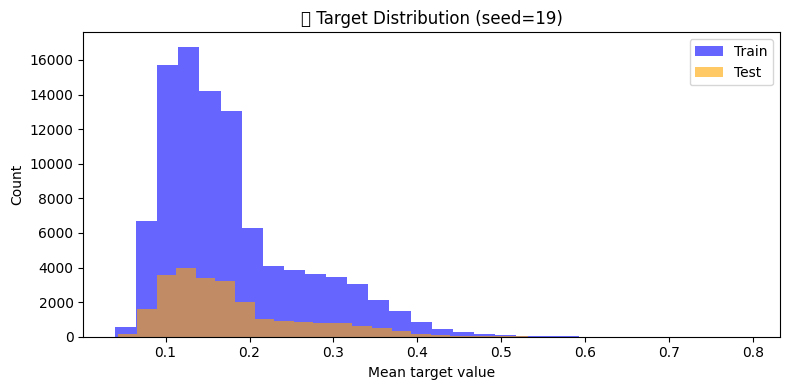

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1022/10000 [00:07<01:03, 140.75it/s]

Epoch [1000/10000], Loss: 0.0041


Epochs:  20%|██        | 2027/10000 [00:14<00:56, 141.51it/s]

Epoch [2000/10000], Loss: 0.0030


Epochs:  30%|███       | 3017/10000 [00:21<00:49, 142.06it/s]

Epoch [3000/10000], Loss: 0.0024


Epochs:  38%|███▊      | 3779/10000 [00:26<00:43, 141.89it/s]


⏹️ Early stopping at epoch 3780

📊 Metrics:
{'MSE': 0.002042008, 'MAE': 0.03250777, 'R2': 0.705395916831131}

🔁 Run 21 / 50 (seed = 20)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


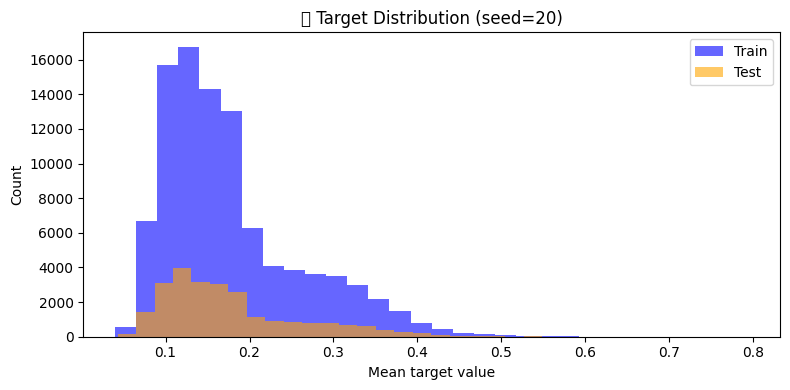

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1022/10000 [00:07<01:03, 142.06it/s]

Epoch [1000/10000], Loss: 0.0043


Epochs:  20%|██        | 2027/10000 [00:14<00:56, 142.20it/s]

Epoch [2000/10000], Loss: 0.0028


Epochs:  30%|███       | 3017/10000 [00:21<00:49, 141.83it/s]

Epoch [3000/10000], Loss: 0.0031


Epochs:  40%|████      | 4022/10000 [00:28<00:42, 142.13it/s]

Epoch [4000/10000], Loss: 0.0022


Epochs:  50%|█████     | 5027/10000 [00:35<00:35, 141.75it/s]

Epoch [5000/10000], Loss: 0.0022


Epochs:  60%|██████    | 6017/10000 [00:42<00:28, 141.84it/s]

Epoch [6000/10000], Loss: 0.0020


Epochs:  70%|███████   | 7022/10000 [00:49<00:21, 141.79it/s]

Epoch [7000/10000], Loss: 0.0018


Epochs:  80%|████████  | 8027/10000 [00:56<00:13, 141.20it/s]

Epoch [8000/10000], Loss: 0.0015


Epochs:  85%|████████▍ | 8469/10000 [00:59<00:10, 141.87it/s]


⏹️ Early stopping at epoch 8470

📊 Metrics:
{'MSE': 0.0015425523, 'MAE': 0.029268458, 'R2': 0.7764096194860823}

🔁 Run 22 / 50 (seed = 21)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


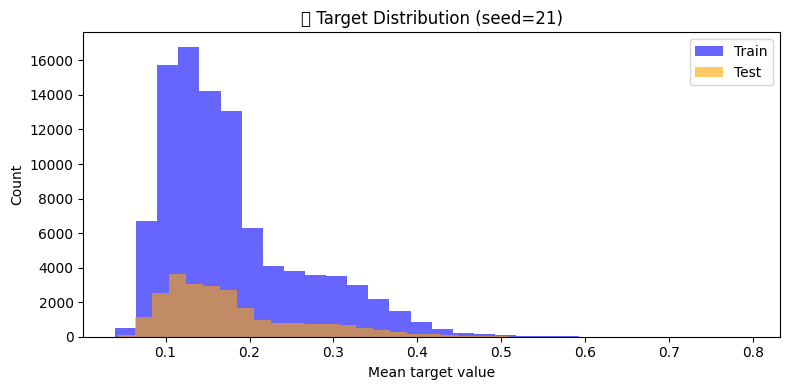

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1022/10000 [00:07<01:03, 142.04it/s]

Epoch [1000/10000], Loss: 0.0042


Epochs:  20%|██        | 2027/10000 [00:14<00:56, 141.87it/s]

Epoch [2000/10000], Loss: 0.0028


Epochs:  30%|███       | 3017/10000 [00:21<00:49, 141.87it/s]

Epoch [3000/10000], Loss: 0.0024


Epochs:  40%|████      | 4022/10000 [00:28<00:42, 141.65it/s]

Epoch [4000/10000], Loss: 0.0022


Epochs:  50%|█████     | 5027/10000 [00:35<00:35, 141.23it/s]

Epoch [5000/10000], Loss: 0.0018


Epochs:  60%|██████    | 6017/10000 [00:42<00:28, 141.49it/s]

Epoch [6000/10000], Loss: 0.0019


Epochs:  61%|██████    | 6109/10000 [00:43<00:27, 141.72it/s]


⏹️ Early stopping at epoch 6110

📊 Metrics:
{'MSE': 0.0018430703, 'MAE': 0.0316703, 'R2': 0.732535607362037}

🔁 Run 23 / 50 (seed = 22)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


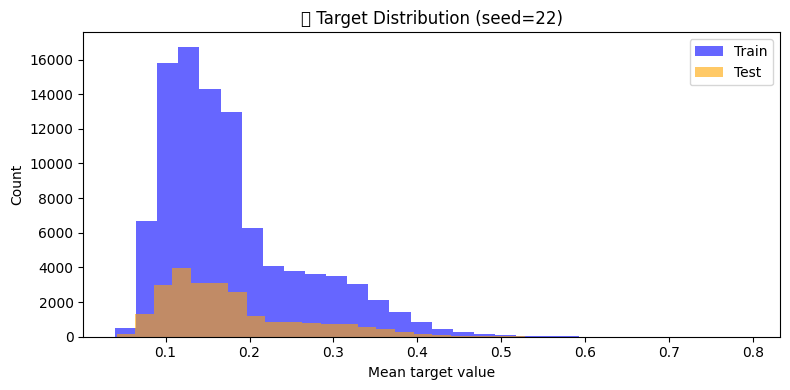

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1022/10000 [00:07<01:03, 142.08it/s]

Epoch [1000/10000], Loss: 0.0044


Epochs:  20%|██        | 2027/10000 [00:14<00:56, 141.87it/s]

Epoch [2000/10000], Loss: 0.0028


Epochs:  30%|███       | 3017/10000 [00:21<00:49, 141.36it/s]

Epoch [3000/10000], Loss: 0.0024


Epochs:  40%|████      | 4022/10000 [00:28<00:42, 142.09it/s]

Epoch [4000/10000], Loss: 0.0020


Epochs:  50%|█████     | 5027/10000 [00:35<00:34, 142.30it/s]

Epoch [5000/10000], Loss: 0.0029


Epochs:  60%|██████    | 6017/10000 [00:42<00:28, 141.45it/s]

Epoch [6000/10000], Loss: 0.0017


Epochs:  70%|███████   | 7022/10000 [00:49<00:21, 141.78it/s]

Epoch [7000/10000], Loss: 0.0016


Epochs:  80%|████████  | 8027/10000 [00:56<00:13, 141.35it/s]

Epoch [8000/10000], Loss: 0.0014


Epochs:  90%|█████████ | 9017/10000 [01:03<00:06, 142.03it/s]

Epoch [9000/10000], Loss: 0.0013


Epochs:  95%|█████████▍| 9455/10000 [01:06<00:03, 141.88it/s]


⏹️ Early stopping at epoch 9456

📊 Metrics:
{'MSE': 0.0030567679, 'MAE': 0.04063598, 'R2': 0.5599702269807625}

🔁 Run 24 / 50 (seed = 23)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


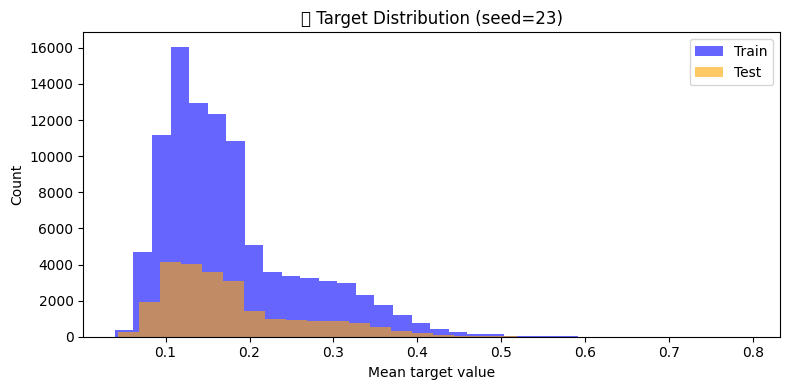

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1021/10000 [00:07<01:03, 141.73it/s]

Epoch [1000/10000], Loss: 0.0043


Epochs:  15%|█▍        | 1461/10000 [00:10<01:00, 141.94it/s]


⏹️ Early stopping at epoch 1462

📊 Metrics:
{'MSE': 0.0041734218, 'MAE': 0.047517236, 'R2': 0.4049005412466228}

🔁 Run 25 / 50 (seed = 24)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


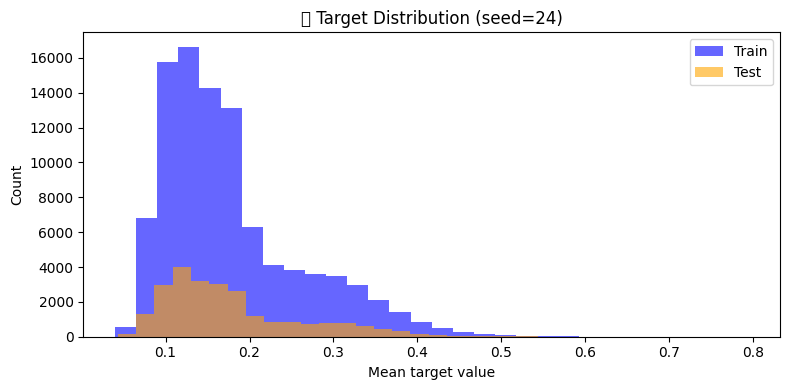

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1022/10000 [00:07<01:03, 142.12it/s]

Epoch [1000/10000], Loss: 0.0046


Epochs:  20%|█▉        | 1977/10000 [00:13<00:56, 141.92it/s]


⏹️ Early stopping at epoch 1978

📊 Metrics:
{'MSE': 0.0034749166, 'MAE': 0.043164875, 'R2': 0.5007738039875789}

🔁 Run 26 / 50 (seed = 25)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


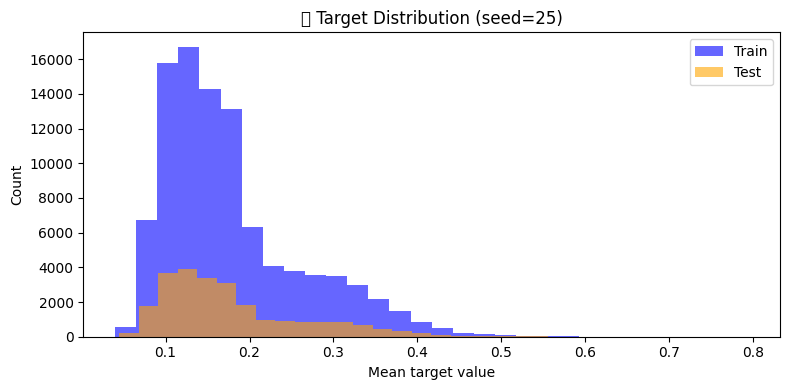

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1022/10000 [00:07<01:03, 141.75it/s]

Epoch [1000/10000], Loss: 0.0043


Epochs:  20%|██        | 2027/10000 [00:14<00:56, 141.70it/s]

Epoch [2000/10000], Loss: 0.0043


Epochs:  22%|██▏       | 2236/10000 [00:15<00:54, 141.65it/s]


⏹️ Early stopping at epoch 2237

📊 Metrics:
{'MSE': 0.003373448, 'MAE': 0.042174067, 'R2': 0.5256041826678138}

🔁 Run 27 / 50 (seed = 26)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


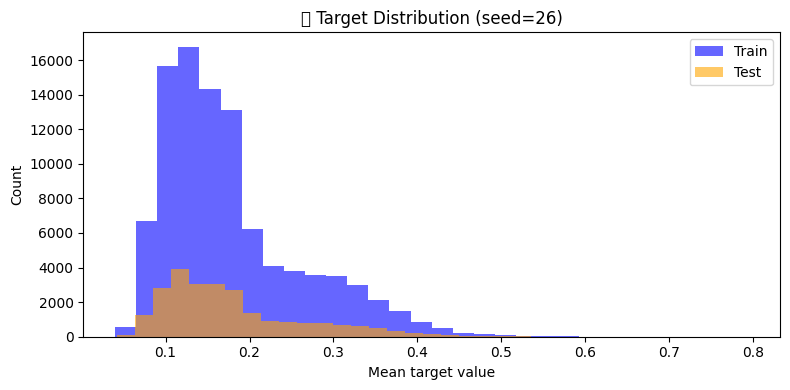

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1022/10000 [00:07<01:03, 142.29it/s]

Epoch [1000/10000], Loss: 0.0043


Epochs:  16%|█▌        | 1587/10000 [00:11<00:59, 141.87it/s]


⏹️ Early stopping at epoch 1588

📊 Metrics:
{'MSE': 0.003917393, 'MAE': 0.046055283, 'R2': 0.4325990108259319}

🔁 Run 28 / 50 (seed = 27)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


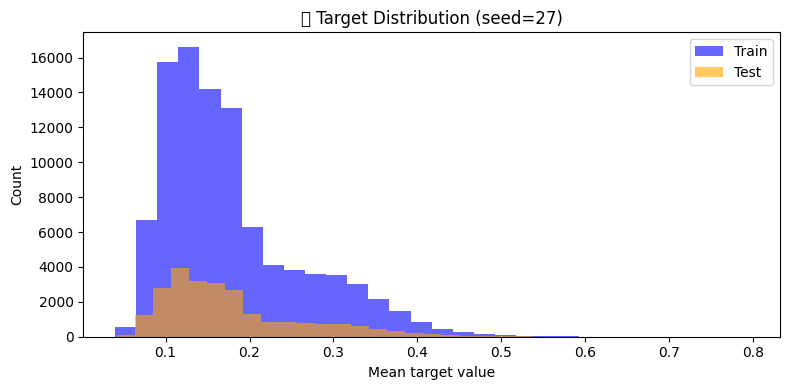

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1022/10000 [00:07<01:03, 141.74it/s]

Epoch [1000/10000], Loss: 0.0045


Epochs:  20%|██        | 2027/10000 [00:14<00:56, 141.05it/s]

Epoch [2000/10000], Loss: 0.0032


Epochs:  30%|███       | 3017/10000 [00:21<00:49, 141.11it/s]

Epoch [3000/10000], Loss: 0.0028


Epochs:  40%|████      | 4022/10000 [00:28<00:42, 141.31it/s]

Epoch [4000/10000], Loss: 0.0033


Epochs:  50%|█████     | 5027/10000 [00:35<00:35, 140.78it/s]

Epoch [5000/10000], Loss: 0.0023


Epochs:  60%|██████    | 6017/10000 [00:42<00:28, 140.98it/s]

Epoch [6000/10000], Loss: 0.0019


Epochs:  70%|███████   | 7022/10000 [00:49<00:21, 140.86it/s]

Epoch [7000/10000], Loss: 0.0017


Epochs:  80%|████████  | 8027/10000 [00:56<00:13, 141.25it/s]

Epoch [8000/10000], Loss: 0.0013


Epochs:  90%|█████████ | 9017/10000 [01:03<00:06, 141.32it/s]

Epoch [9000/10000], Loss: 0.0011


Epochs:  97%|█████████▋| 9717/10000 [01:08<00:02, 141.25it/s]


⏹️ Early stopping at epoch 9718

📊 Metrics:
{'MSE': 0.0019640885, 'MAE': 0.03510698, 'R2': 0.7146323422054759}

🔁 Run 29 / 50 (seed = 28)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


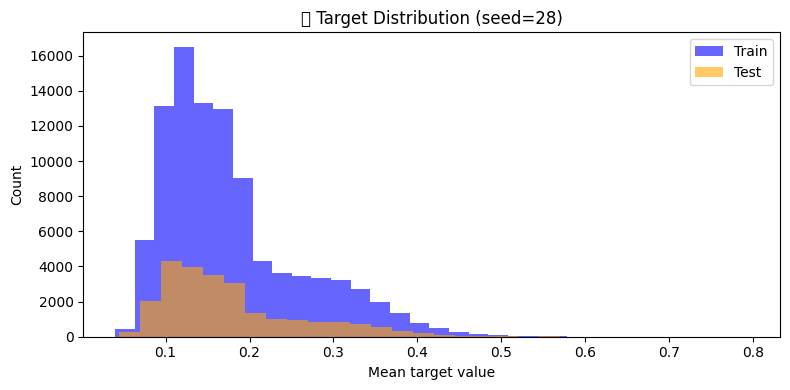

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1022/10000 [00:07<01:03, 142.50it/s]

Epoch [1000/10000], Loss: 0.0044


Epochs:  20%|██        | 2027/10000 [00:14<00:55, 142.39it/s]

Epoch [2000/10000], Loss: 0.0034


Epochs:  21%|██        | 2097/10000 [00:14<00:55, 142.04it/s]


⏹️ Early stopping at epoch 2098

📊 Metrics:
{'MSE': 0.0033578544, 'MAE': 0.04273479, 'R2': 0.509363412532452}

🔁 Run 30 / 50 (seed = 29)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


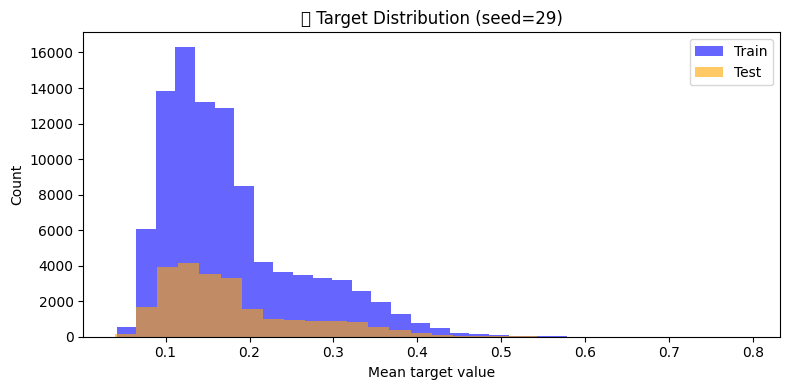

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1022/10000 [00:07<01:03, 142.18it/s]

Epoch [1000/10000], Loss: 0.0045


Epochs:  20%|██        | 2027/10000 [00:14<00:56, 141.80it/s]

Epoch [2000/10000], Loss: 0.0036


Epochs:  21%|██▏       | 2143/10000 [00:15<00:55, 142.17it/s]


⏹️ Early stopping at epoch 2144

📊 Metrics:
{'MSE': 0.0036284674, 'MAE': 0.04401874, 'R2': 0.48377563847455063}

🔁 Run 31 / 50 (seed = 30)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


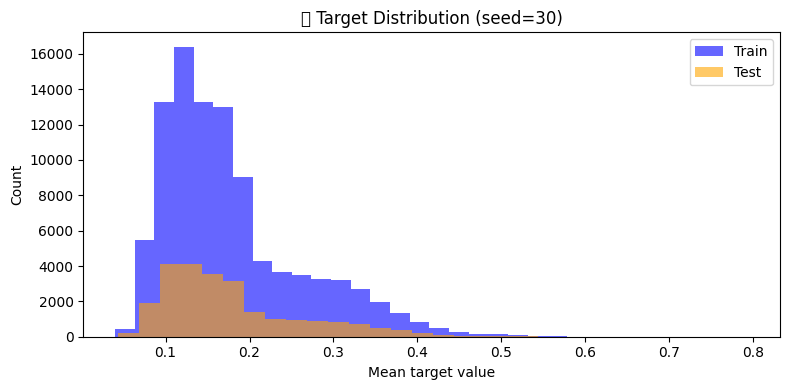

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1022/10000 [00:07<01:03, 142.50it/s]

Epoch [1000/10000], Loss: 0.0048


Epochs:  20%|██        | 2027/10000 [00:14<00:56, 142.14it/s]

Epoch [2000/10000], Loss: 0.0033


Epochs:  30%|███       | 3017/10000 [00:21<00:49, 142.42it/s]

Epoch [3000/10000], Loss: 0.0029


Epochs:  40%|████      | 4022/10000 [00:28<00:42, 141.97it/s]

Epoch [4000/10000], Loss: 0.0024


Epochs:  50%|█████     | 5027/10000 [00:35<00:35, 141.60it/s]

Epoch [5000/10000], Loss: 0.0023


Epochs:  60%|██████    | 6017/10000 [00:42<00:28, 142.17it/s]

Epoch [6000/10000], Loss: 0.0019


Epochs:  70%|███████   | 7022/10000 [00:49<00:20, 142.05it/s]

Epoch [7000/10000], Loss: 0.0016


Epochs:  80%|████████  | 8027/10000 [00:56<00:13, 141.74it/s]

Epoch [8000/10000], Loss: 0.0014


Epochs:  85%|████████▌ | 8534/10000 [01:00<00:10, 142.07it/s]


⏹️ Early stopping at epoch 8535

📊 Metrics:
{'MSE': 0.0014599495, 'MAE': 0.02613139, 'R2': 0.7874417108766905}

🔁 Run 32 / 50 (seed = 31)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


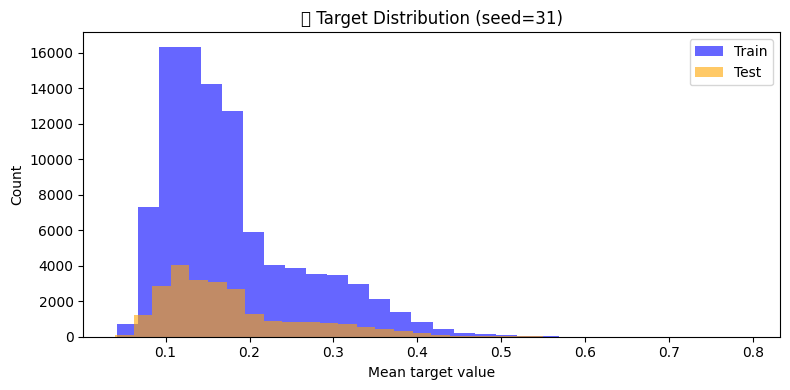

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1022/10000 [00:07<01:03, 141.61it/s]

Epoch [1000/10000], Loss: 0.0047


Epochs:  20%|██        | 2027/10000 [00:14<00:56, 141.90it/s]

Epoch [2000/10000], Loss: 0.0033


Epochs:  30%|███       | 3017/10000 [00:21<00:49, 142.32it/s]

Epoch [3000/10000], Loss: 0.0027


Epochs:  40%|████      | 4022/10000 [00:28<00:42, 141.90it/s]

Epoch [4000/10000], Loss: 0.0025


Epochs:  50%|█████     | 5027/10000 [00:35<00:35, 141.96it/s]

Epoch [5000/10000], Loss: 0.0021


Epochs:  60%|██████    | 6017/10000 [00:42<00:28, 141.66it/s]

Epoch [6000/10000], Loss: 0.0017


Epochs:  70%|███████   | 7022/10000 [00:49<00:21, 141.71it/s]

Epoch [7000/10000], Loss: 0.0015


Epochs:  74%|███████▍  | 7375/10000 [00:51<00:18, 141.95it/s]


⏹️ Early stopping at epoch 7376

📊 Metrics:
{'MSE': 0.0016872548, 'MAE': 0.028648768, 'R2': 0.7583936299591568}

🔁 Run 33 / 50 (seed = 32)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


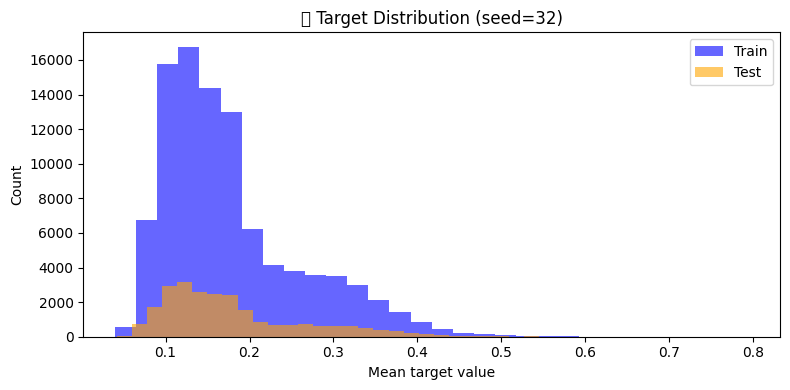

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1022/10000 [00:07<01:03, 141.15it/s]

Epoch [1000/10000], Loss: 0.0048


Epochs:  20%|██        | 2027/10000 [00:14<00:56, 141.17it/s]

Epoch [2000/10000], Loss: 0.0035


Epochs:  30%|███       | 3017/10000 [00:21<00:49, 140.93it/s]

Epoch [3000/10000], Loss: 0.0030


Epochs:  40%|████      | 4022/10000 [00:28<00:42, 141.78it/s]

Epoch [4000/10000], Loss: 0.0026


Epochs:  50%|█████     | 5027/10000 [00:35<00:35, 141.10it/s]

Epoch [5000/10000], Loss: 0.0021


Epochs:  60%|██████    | 6017/10000 [00:42<00:28, 140.79it/s]

Epoch [6000/10000], Loss: 0.0016


Epochs:  70%|███████   | 7022/10000 [00:49<00:21, 140.96it/s]

Epoch [7000/10000], Loss: 0.0014


Epochs:  80%|████████  | 8027/10000 [00:56<00:14, 140.62it/s]

Epoch [8000/10000], Loss: 0.0013


Epochs:  90%|█████████ | 9016/10000 [01:03<00:06, 141.02it/s]

Epoch [9000/10000], Loss: 0.0011


Epochs:  93%|█████████▎| 9260/10000 [01:05<00:05, 141.24it/s]


⏹️ Early stopping at epoch 9261

📊 Metrics:
{'MSE': 0.0011213669, 'MAE': 0.02384323, 'R2': 0.839497472853137}

🔁 Run 34 / 50 (seed = 33)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


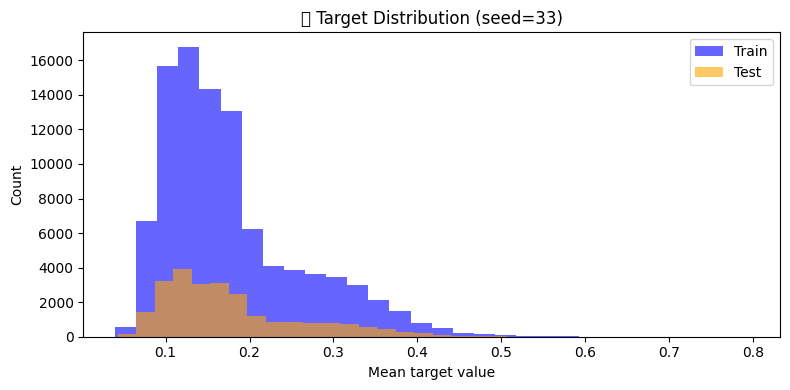

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1022/10000 [00:07<01:03, 141.83it/s]

Epoch [1000/10000], Loss: 0.0043


Epochs:  20%|██        | 2027/10000 [00:14<00:56, 141.19it/s]

Epoch [2000/10000], Loss: 0.0030


Epochs:  30%|██▉       | 2955/10000 [00:20<00:49, 141.39it/s]


⏹️ Early stopping at epoch 2956

📊 Metrics:
{'MSE': 0.0024092605, 'MAE': 0.03494797, 'R2': 0.65624660378601}

🔁 Run 35 / 50 (seed = 34)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


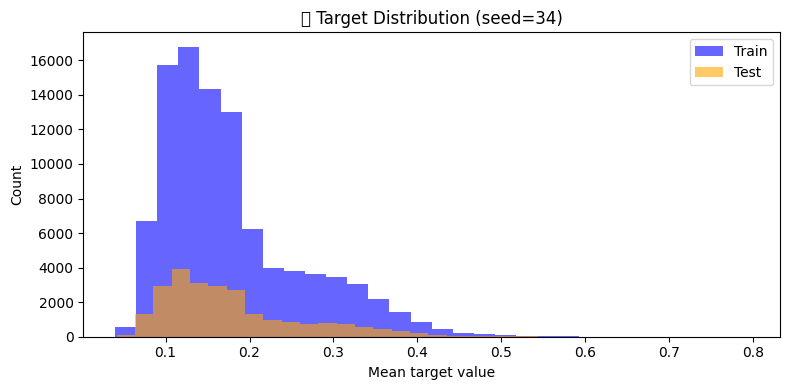

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1022/10000 [00:07<01:03, 141.47it/s]

Epoch [1000/10000], Loss: 0.0039


Epochs:  20%|██        | 2027/10000 [00:14<00:56, 141.58it/s]

Epoch [2000/10000], Loss: 0.0028


Epochs:  30%|███       | 3017/10000 [00:21<00:49, 141.11it/s]

Epoch [3000/10000], Loss: 0.0024


Epochs:  40%|████      | 4022/10000 [00:28<00:42, 141.88it/s]

Epoch [4000/10000], Loss: 0.0019


Epochs:  50%|█████     | 5027/10000 [00:35<00:35, 141.63it/s]

Epoch [5000/10000], Loss: 0.0016


Epochs:  60%|██████    | 6017/10000 [00:42<00:28, 141.34it/s]

Epoch [6000/10000], Loss: 0.0014


Epochs:  70%|███████   | 7022/10000 [00:49<00:21, 141.42it/s]

Epoch [7000/10000], Loss: 0.0012


Epochs:  73%|███████▎  | 7310/10000 [00:51<00:18, 141.61it/s]


⏹️ Early stopping at epoch 7311

📊 Metrics:
{'MSE': 0.001272122, 'MAE': 0.025418926, 'R2': 0.8162709643395314}

🔁 Run 36 / 50 (seed = 35)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


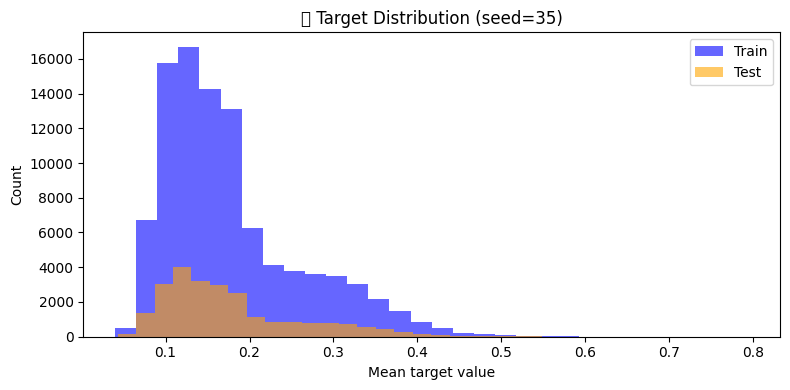

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1022/10000 [00:07<01:03, 141.49it/s]

Epoch [1000/10000], Loss: 0.0043


Epochs:  20%|██        | 2027/10000 [00:14<00:56, 141.64it/s]

Epoch [2000/10000], Loss: 0.0034


Epochs:  21%|██        | 2121/10000 [00:14<00:55, 141.59it/s]


⏹️ Early stopping at epoch 2122

📊 Metrics:
{'MSE': 0.0034210372, 'MAE': 0.04279465, 'R2': 0.5102411915114773}

🔁 Run 37 / 50 (seed = 36)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


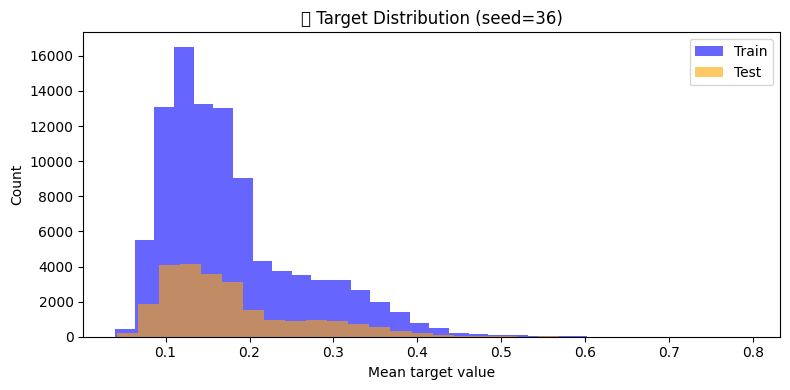

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1022/10000 [00:07<01:03, 141.93it/s]

Epoch [1000/10000], Loss: 0.0048


Epochs:  20%|██        | 2027/10000 [00:14<00:56, 141.73it/s]

Epoch [2000/10000], Loss: 0.0033


Epochs:  29%|██▊       | 2855/10000 [00:20<00:50, 141.98it/s]


⏹️ Early stopping at epoch 2856

📊 Metrics:
{'MSE': 0.0028343943, 'MAE': 0.03881447, 'R2': 0.5901384363083463}

🔁 Run 38 / 50 (seed = 37)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


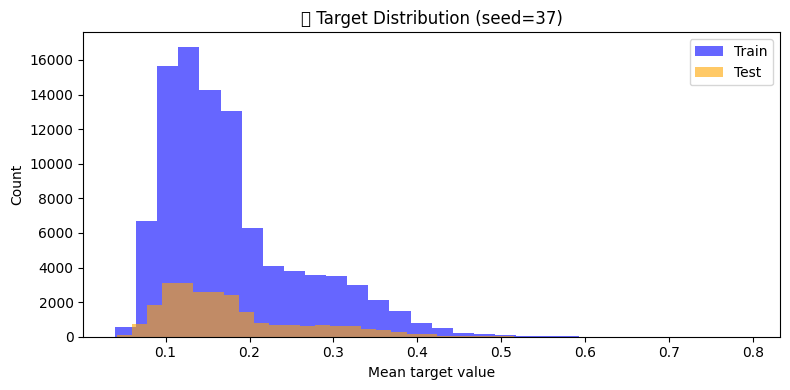

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1022/10000 [00:07<01:03, 141.84it/s]

Epoch [1000/10000], Loss: 0.0048


Epochs:  20%|██        | 2027/10000 [00:14<00:56, 141.53it/s]

Epoch [2000/10000], Loss: 0.0064


Epochs:  21%|██        | 2079/10000 [00:14<00:55, 141.70it/s]


⏹️ Early stopping at epoch 2080

📊 Metrics:
{'MSE': 0.0036378042, 'MAE': 0.04469385, 'R2': 0.47587032314720046}

🔁 Run 39 / 50 (seed = 38)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


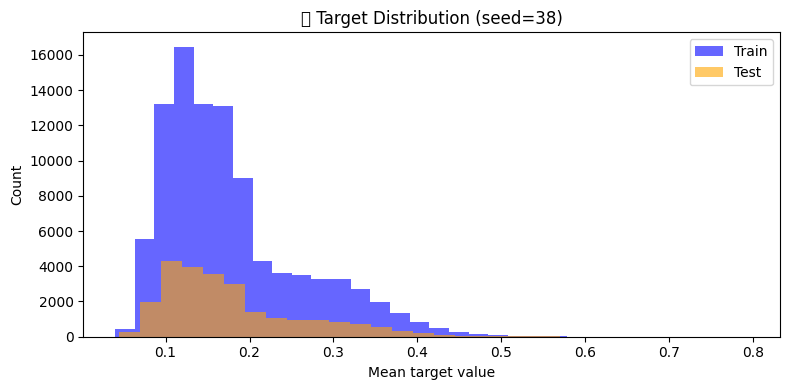

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1022/10000 [00:07<01:03, 141.78it/s]

Epoch [1000/10000], Loss: 0.0044


Epochs:  20%|██        | 2027/10000 [00:14<00:56, 141.74it/s]

Epoch [2000/10000], Loss: 0.0037


Epochs:  22%|██▎       | 2250/10000 [00:15<00:54, 141.89it/s]


⏹️ Early stopping at epoch 2251

📊 Metrics:
{'MSE': 0.0029392764, 'MAE': 0.039507046, 'R2': 0.5773529663249091}

🔁 Run 40 / 50 (seed = 39)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


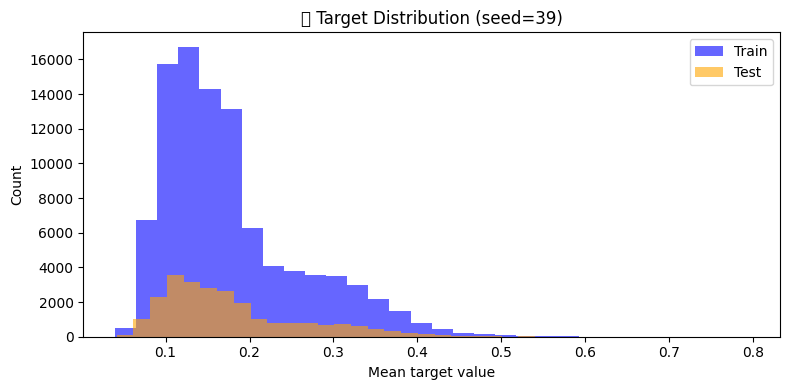

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1022/10000 [00:07<01:03, 142.48it/s]

Epoch [1000/10000], Loss: 0.0042


Epochs:  19%|█▉        | 1896/10000 [00:13<00:57, 141.97it/s]


⏹️ Early stopping at epoch 1897

📊 Metrics:
{'MSE': 0.003281086, 'MAE': 0.041919924, 'R2': 0.5344156389779438}

🔁 Run 41 / 50 (seed = 40)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


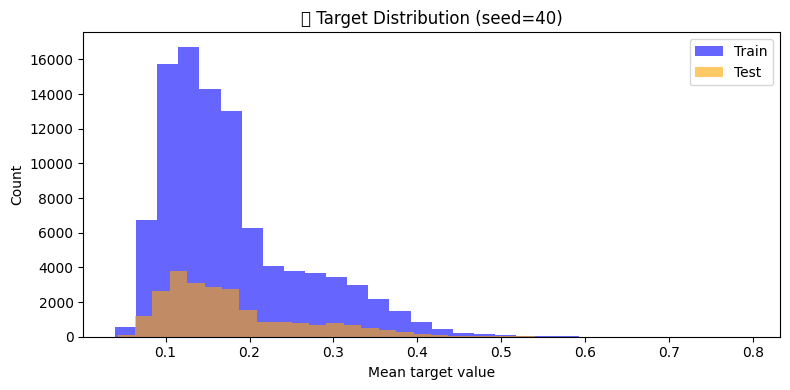

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1022/10000 [00:07<01:03, 141.31it/s]

Epoch [1000/10000], Loss: 0.0041


Epochs:  16%|█▌        | 1567/10000 [00:11<00:59, 141.81it/s]


⏹️ Early stopping at epoch 1568

📊 Metrics:
{'MSE': 0.0033146623, 'MAE': 0.04201122, 'R2': 0.5205682425055149}

🔁 Run 42 / 50 (seed = 41)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


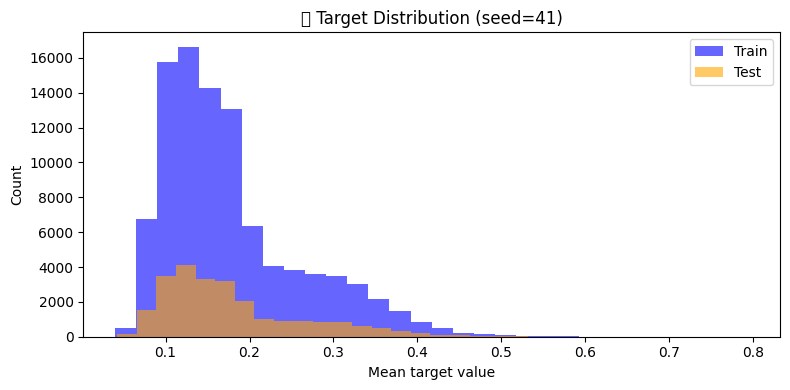

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1022/10000 [00:07<01:03, 141.88it/s]

Epoch [1000/10000], Loss: 0.0046


Epochs:  20%|██        | 2027/10000 [00:14<00:56, 141.36it/s]

Epoch [2000/10000], Loss: 0.0032


Epochs:  23%|██▎       | 2329/10000 [00:16<00:54, 141.88it/s]


⏹️ Early stopping at epoch 2330

📊 Metrics:
{'MSE': 0.0031755106, 'MAE': 0.041066293, 'R2': 0.5445800859927241}

🔁 Run 43 / 50 (seed = 42)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


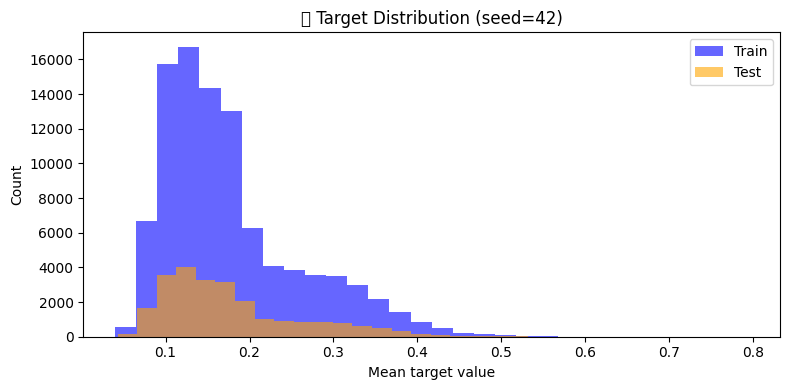

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1022/10000 [00:07<01:03, 142.35it/s]

Epoch [1000/10000], Loss: 0.0040


Epochs:  20%|██        | 2027/10000 [00:14<00:56, 141.88it/s]

Epoch [2000/10000], Loss: 0.0029


Epochs:  30%|███       | 3017/10000 [00:21<00:49, 140.94it/s]

Epoch [3000/10000], Loss: 0.0025


Epochs:  40%|████      | 4022/10000 [00:28<00:42, 141.70it/s]

Epoch [4000/10000], Loss: 0.0019


Epochs:  50%|█████     | 5027/10000 [00:35<00:35, 141.35it/s]

Epoch [5000/10000], Loss: 0.0024


Epochs:  60%|██████    | 6017/10000 [00:42<00:28, 141.84it/s]

Epoch [6000/10000], Loss: 0.0015


Epochs:  63%|██████▎   | 6271/10000 [00:44<00:26, 141.67it/s]


⏹️ Early stopping at epoch 6272

📊 Metrics:
{'MSE': 0.001599486, 'MAE': 0.0287545, 'R2': 0.7707224555196798}

🔁 Run 44 / 50 (seed = 43)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


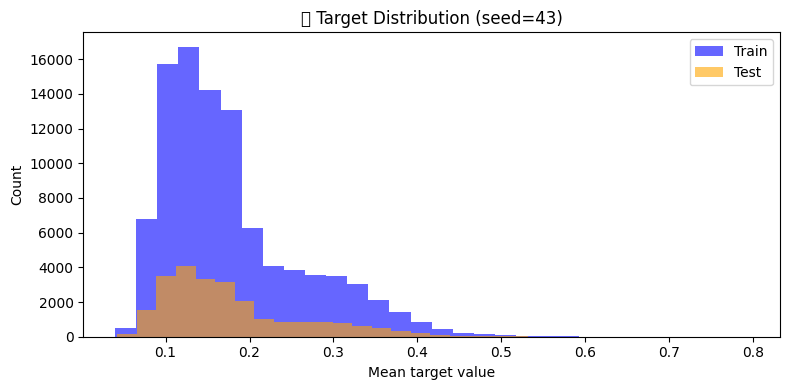

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1022/10000 [00:07<01:03, 141.66it/s]

Epoch [1000/10000], Loss: 0.0041


Epochs:  20%|██        | 2027/10000 [00:14<00:56, 141.05it/s]

Epoch [2000/10000], Loss: 0.0031


Epochs:  30%|███       | 3017/10000 [00:21<00:49, 141.45it/s]

Epoch [3000/10000], Loss: 0.0028


Epochs:  40%|████      | 4022/10000 [00:28<00:42, 141.52it/s]

Epoch [4000/10000], Loss: 0.0027


Epochs:  50%|█████     | 5027/10000 [00:35<00:35, 141.23it/s]

Epoch [5000/10000], Loss: 0.0020


Epochs:  60%|██████    | 6017/10000 [00:42<00:28, 141.41it/s]

Epoch [6000/10000], Loss: 0.0016


Epochs:  70%|███████   | 7020/10000 [00:49<00:21, 141.46it/s]

Epoch [7000/10000], Loss: 0.0018
⏹️ Early stopping at epoch 7021

📊 Metrics:
{'MSE': 0.0015031386, 'MAE': 0.027577903, 'R2': 0.7837879995090035}

🔁 Run 45 / 50 (seed = 44)


Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


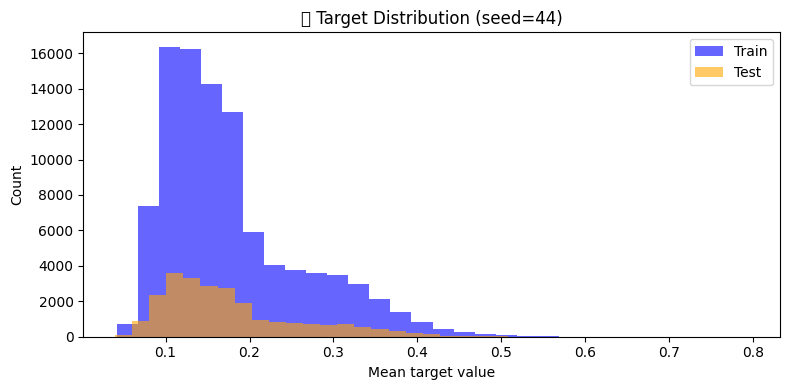

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1022/10000 [00:07<01:03, 141.74it/s]

Epoch [1000/10000], Loss: 0.0043


Epochs:  20%|██        | 2027/10000 [00:14<00:56, 141.88it/s]

Epoch [2000/10000], Loss: 0.0035


Epochs:  23%|██▎       | 2342/10000 [00:16<00:54, 141.75it/s]


⏹️ Early stopping at epoch 2343

📊 Metrics:
{'MSE': 0.0030557052, 'MAE': 0.040369906, 'R2': 0.555255134258937}

🔁 Run 46 / 50 (seed = 45)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


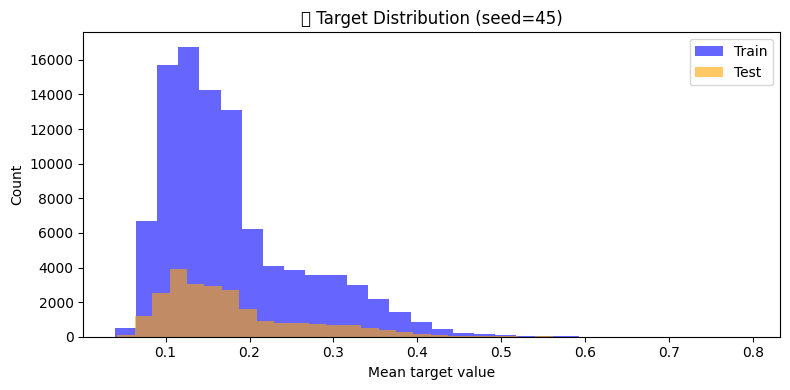

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1022/10000 [00:07<01:02, 142.55it/s]

Epoch [1000/10000], Loss: 0.0036


Epochs:  20%|██        | 2027/10000 [00:14<00:56, 142.10it/s]

Epoch [2000/10000], Loss: 0.0028


Epochs:  30%|███       | 3017/10000 [00:21<00:49, 142.08it/s]

Epoch [3000/10000], Loss: 0.0024


Epochs:  40%|████      | 4022/10000 [00:28<00:42, 142.00it/s]

Epoch [4000/10000], Loss: 0.0020


Epochs:  50%|█████     | 5027/10000 [00:35<00:35, 141.35it/s]

Epoch [5000/10000], Loss: 0.0018


Epochs:  60%|██████    | 6017/10000 [00:42<00:28, 142.20it/s]

Epoch [6000/10000], Loss: 0.0018


Epochs:  61%|██████    | 6091/10000 [00:42<00:27, 141.87it/s]


⏹️ Early stopping at epoch 6092

📊 Metrics:
{'MSE': 0.0016393695, 'MAE': 0.028879449, 'R2': 0.7638982283931778}

🔁 Run 47 / 50 (seed = 46)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


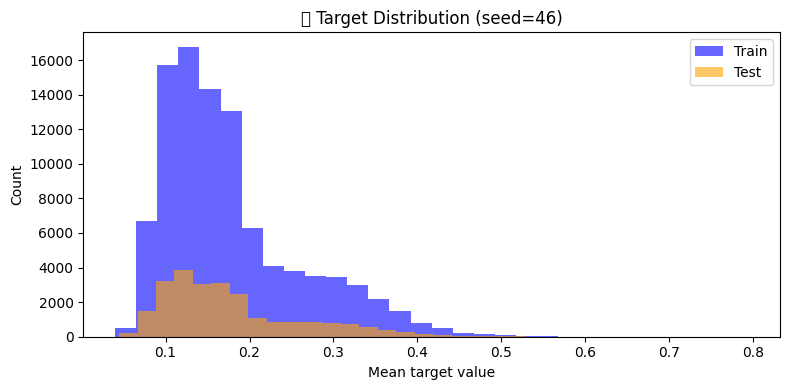

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1022/10000 [00:07<01:03, 141.92it/s]

Epoch [1000/10000], Loss: 0.0044


Epochs:  20%|██        | 2027/10000 [00:14<00:56, 141.62it/s]

Epoch [2000/10000], Loss: 0.0037


Epochs:  25%|██▌       | 2533/10000 [00:17<00:52, 141.86it/s]


⏹️ Early stopping at epoch 2534

📊 Metrics:
{'MSE': 0.003448773, 'MAE': 0.043097794, 'R2': 0.5057134044167273}

🔁 Run 48 / 50 (seed = 47)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


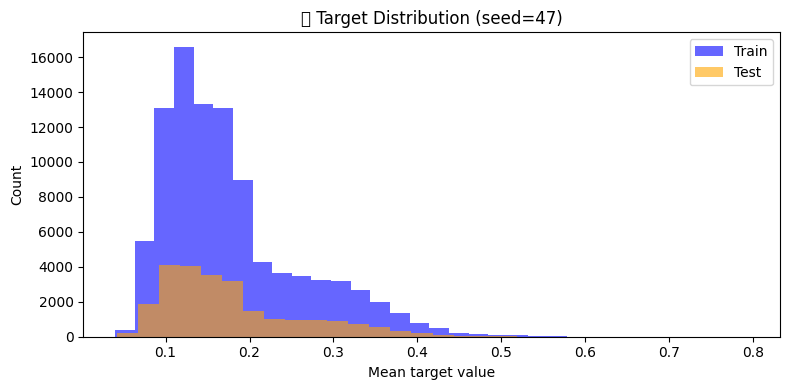

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1022/10000 [00:07<01:03, 141.31it/s]

Epoch [1000/10000], Loss: 0.0048


Epochs:  20%|██        | 2027/10000 [00:14<00:56, 141.29it/s]

Epoch [2000/10000], Loss: 0.0035


Epochs:  21%|██        | 2112/10000 [00:14<00:55, 141.89it/s]


⏹️ Early stopping at epoch 2113

📊 Metrics:
{'MSE': 0.0035525684, 'MAE': 0.0442071, 'R2': 0.4793946096347219}

🔁 Run 49 / 50 (seed = 48)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


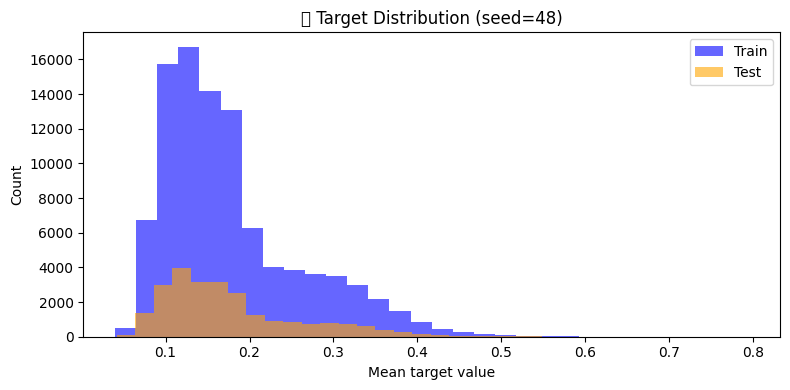

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1022/10000 [00:07<01:03, 142.08it/s]

Epoch [1000/10000], Loss: 0.0043


Epochs:  20%|██        | 2027/10000 [00:14<00:56, 141.47it/s]

Epoch [2000/10000], Loss: 0.0027


Epochs:  30%|███       | 3017/10000 [00:21<00:49, 141.21it/s]

Epoch [3000/10000], Loss: 0.0024


Epochs:  40%|████      | 4022/10000 [00:28<00:42, 140.93it/s]

Epoch [4000/10000], Loss: 0.0021


Epochs:  50%|█████     | 5027/10000 [00:35<00:35, 141.30it/s]

Epoch [5000/10000], Loss: 0.0016


Epochs:  60%|██████    | 6017/10000 [00:42<00:28, 140.88it/s]

Epoch [6000/10000], Loss: 0.0014


Epochs:  60%|██████    | 6048/10000 [00:42<00:27, 141.41it/s]


⏹️ Early stopping at epoch 6049

📊 Metrics:
{'MSE': 0.0014093737, 'MAE': 0.026048968, 'R2': 0.7945742775611335}

🔁 Run 50 / 50 (seed = 49)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


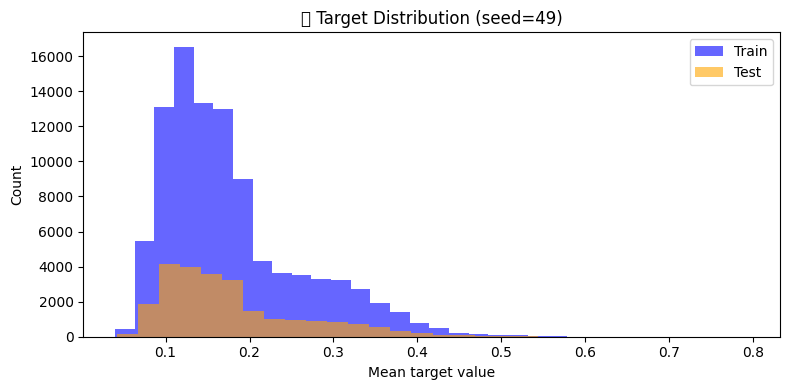

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1022/10000 [00:07<01:03, 141.97it/s]

Epoch [1000/10000], Loss: 0.0042


Epochs:  20%|██        | 2027/10000 [00:14<00:56, 141.67it/s]

Epoch [2000/10000], Loss: 0.0033


Epochs:  30%|███       | 3017/10000 [00:21<00:49, 141.83it/s]

Epoch [3000/10000], Loss: 0.0026


Epochs:  40%|████      | 4022/10000 [00:28<00:42, 141.62it/s]

Epoch [4000/10000], Loss: 0.0023


Epochs:  50%|█████     | 5027/10000 [00:35<00:35, 141.72it/s]

Epoch [5000/10000], Loss: 0.0019


Epochs:  60%|██████    | 6017/10000 [00:42<00:28, 141.69it/s]

Epoch [6000/10000], Loss: 0.0016


Epochs:  70%|███████   | 7022/10000 [00:49<00:20, 141.93it/s]

Epoch [7000/10000], Loss: 0.0015


Epochs:  80%|████████  | 8027/10000 [00:56<00:13, 141.95it/s]

Epoch [8000/10000], Loss: 0.0015


Epochs:  89%|████████▊ | 8862/10000 [01:02<00:08, 141.53it/s]

⏹️ Early stopping at epoch 8863

📊 Metrics:
{'MSE': 0.0012025587, 'MAE': 0.023786511, 'R2': 0.826336596528852}
📁 Best weights saved to: /kaggle/working/config_mlp_128h_4e-03lr/best_model_weights_mlp_128h_4e-03lr_16bs_10000ep_Tanh_Adam.pt
🏆 Best run: run_seed_6 with R2 = 0.8414
   R2   = 0.8414
   MAE  = 0.0228
   MSE  = 0.001093


In [8]:
# 📁 src/tuning/run_experiments.py
# ➤ Run MLP training multiple times with different random seeds to assess stability
# ➤ Track and save best model based on R² score
# ➤ Store metrics for each run, save best weights and evaluation report


# 🧠 Prepare model
# 📌 Fixed parameters
EPOCHS = 10000
OUTPUT_DIM = 1
N_RUNS = 50  # Total number of runs

# 📊 Containers to collect results
results_all = []
results_header = ["run", "run_id", "R2", "MAE", "MSE"]
best_r2 = -float("inf")
best_model = None
best_metrics = None
best_run_id = None
train_loss_history = [] 
weights_registry = {}  # run_id -> weights
weights_registry.clear()


# 🔁 Run the same config with different random seeds
for seed in range(N_RUNS):
    print(f"\n🔁 Run {seed + 1} / {N_RUNS} (seed = {seed})")

    # 🏃 Train model with current seed
    run_id, metrics = train_mlp(
        hidden_dim=config["hidden_dim"],
        lr=config["lr"],
        batch_size=config["batch_size"],
        epochs=EPOCHS,
        output_dim=config["output_dim"],
        activation_fn=config["activation_fn"],
        optimizer_name=config["optimizer_name"],
        seed=seed
    )

    # 📥 Collect result for this run
    results_all.append({
        "run": seed,
        "run_id": run_id,
        "R2": metrics["R2"],
        "MAE": metrics["MAE"],
        "MSE": metrics["MSE"]
    })

    # 🏆 Check if it's the best so far
    if metrics["R2"] > best_r2:
        best_r2 = metrics["R2"]
        best_metrics = metrics
        best_run_id = run_id

# 💾 Ensure save directory exists
os.makedirs(SAVE_ROOT, exist_ok=True)

# 💾 Save full metrics log
results_csv_path = os.path.join(SAVE_ROOT, f"results_{arch_label}.csv")
df_results = pd.DataFrame(results_all, columns=results_header)
df_results.to_csv(results_csv_path, index=False)

# 💾 Save best model weights
best_weights = weights_registry[best_run_id]
weights_save_path = os.path.join(SAVE_ROOT, f"best_model_weights_{arch_label}.pt")
torch.save(best_weights, weights_save_path)
print(f"📁 Best weights saved to: {weights_save_path}")

# 💾 Save best run's metrics
best_metrics = {k: float(v) for k, v in best_metrics.items()}
metrics_json_path = os.path.join(SAVE_ROOT, f"metrics_best_{arch_label}.json")
with open(metrics_json_path, "w") as f:
    json.dump(best_metrics, f, indent=4)

print(f"🏆 Best run: {best_run_id} with R2 = {best_r2:.4f}")
print(f"   R2   = {best_metrics['R2']:.4f}")
print(f"   MAE  = {best_metrics['MAE']:.4f}")
print(f"   MSE  = {best_metrics['MSE']:.6f}")


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


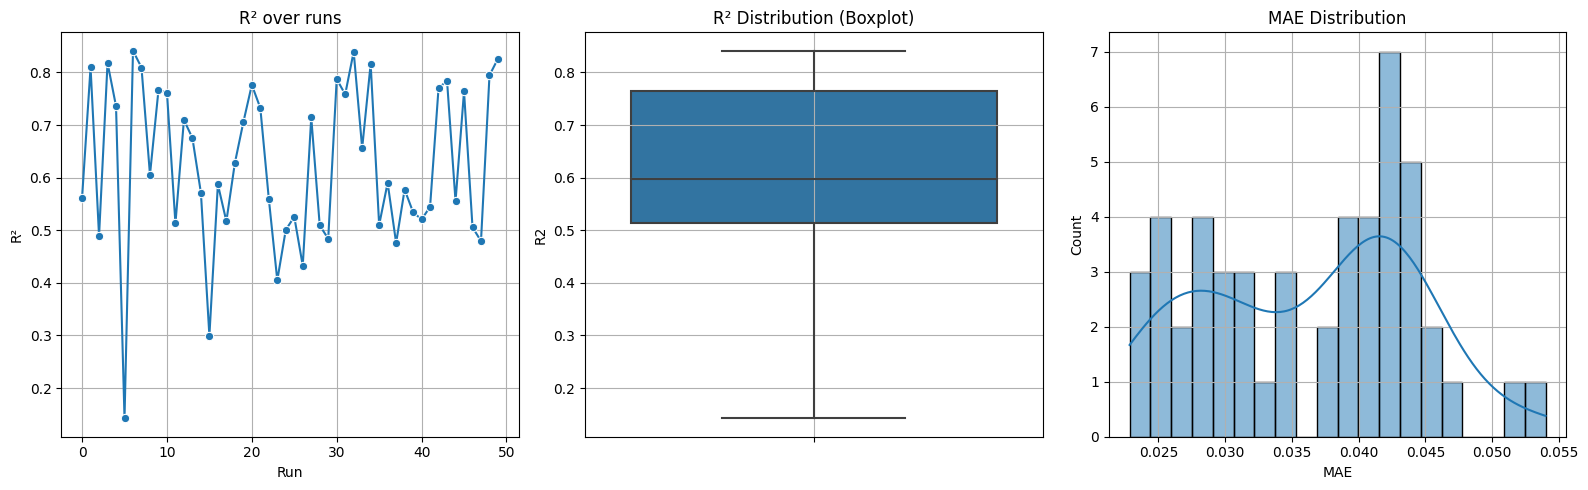

📈 Stability analysis complete:
{
    "R2_mean": 0.6256,
    "R2_std": 0.1544,
    "MAE_mean": 0.0362,
    "MAE_std": 0.0081,
    "MSE_mean": 0.002603,
    "MSE_std": 0.001083,
    "runs": 50
}
📁 Saved metrics: /kaggle/working/config_mlp_128h_4e-03lr/stability_mlp_128h_4e-03lr_16bs_10000ep_Tanh_Adam.json
🖼️  Saved plot: /kaggle/working/config_mlp_128h_4e-03lr/stability_plot_mlp_128h_4e-03lr_16bs_10000ep_Tanh_Adam.png


In [9]:
# 📁 src/tuning/analyze_stability.py
# ➤ Analyze stability of model performance across multiple seeds
# ➤ Compute mean and std for R², MAE, MSE
# ➤ Generate and save visualizations (line plot, boxplot, histogram)
# ➤ Save stability metrics to JSON for reporting and comparison


# 📥 Load results
df = pd.read_csv(results_csv_path)

# 📊 Compute stability stats
stability = {
    "R2_mean":  round(df["R2"].mean(), 4),
    "R2_std":   round(df["R2"].std(), 4),
    "MAE_mean": round(df["MAE"].mean(), 4),
    "MAE_std":  round(df["MAE"].std(), 4),
    "MSE_mean": round(df["MSE"].mean(), 6),
    "MSE_std":  round(df["MSE"].std(), 6),
    "runs": len(df)
}

# 💾 Save stability metrics
stability_path = os.path.join(SAVE_ROOT, f"stability_{arch_label}.json")
with open(stability_path, "w") as f:
    json.dump(stability, f, indent=4)

# 📈 Visualization
plt.figure(figsize=(16, 5))

# 📌 Plot 1: R² over runs
plt.subplot(1, 3, 1)
sns.lineplot(x="run", y="R2", data=df, marker="o", linewidth=1.5)
plt.title("R² over runs")
plt.xlabel("Run")
plt.ylabel("R²")
plt.grid(True)

# 📌 Plot 2: Boxplot of R²
plt.subplot(1, 3, 2)
sns.boxplot(y="R2", data=df)
plt.title("R² Distribution (Boxplot)")
plt.grid(True)

# 📌 Plot 3: Histogram of MAE
plt.subplot(1, 3, 3)
sns.histplot(df["MAE"], bins=20, kde=True)
plt.title("MAE Distribution")
plt.xlabel("MAE")
plt.grid(True)

# 💾 Save the plot
fig_path = os.path.join(SAVE_ROOT, f"stability_plot_{arch_label}.png")
plt.tight_layout()
plt.savefig(fig_path)
plt.show()

# ✅ Output
print("📈 Stability analysis complete:")
print(json.dumps(stability, indent=4))
print(f"📁 Saved metrics: {stability_path}")
print(f"🖼️  Saved plot: {fig_path}")


Second model configuration
config_mlp_128h_6e-03lr

In [10]:
# 📁 src/tuning/setup_paths.py
# ➤ Paths for hyperparameter search: tuning runs, logs, results

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

DATA_PATH = "/kaggle/input/windloading-train/WindLoading_Train.csv"
SAVE_ROOT = "/kaggle/working/config_mlp_128h_6e-03lr"
config_path = '/kaggle/input/wind-fluctuation-prediction-final-model/config_mlp_128h_6e-03lr_ex.json'

In [11]:
# 📁 src/tuning/load_config.py
# ➤ Load best configuration from saved JSON, convert activation string to function,
# ➤ build readable architecture label for logging and saving results

# 🔁 Mapping string from config.json to actual PyTorch activation function
activation_map = {
    "ReLU": torch.nn.ReLU,
    "Tanh": torch.nn.Tanh,
    "LeakyReLU": torch.nn.LeakyReLU
}

# 📦 Load and decode configuration
with open(config_path, "r") as f:
    config = json.load(f)

# 🔧 Convert activation function string to callable object
config["activation_fn"] = activation_map[config["activation_fn"]]

# 🏷 Extract config name from path
# config_name = os.path.basename(os.path.dirname(config_path))  # → 'config_001'
# 🏷 Get config filename (without extension) to use as config_name
config_filename = os.path.basename(config_path)
config_name = os.path.splitext(config_filename)[0]

# 🧠 Build architecture label
arch_label = (
    f"mlp_{config['hidden_dim']}h_"
    f"{config['lr']:.0e}lr_"
    f"{config['batch_size']}bs_"
    f"{config['epochs']}ep_"
    f"{config['activation_fn'].__name__}_"
    f"{config['optimizer_name']}"
)

print("✅ Loaded config:")
print(config)
print(f"📂 SAVE_ROOT: {SAVE_ROOT}")
print(f"📁 arch_label: {arch_label}")

✅ Loaded config:
{'input_dim': 5, 'hidden_dim': 128, 'output_dim': 1, 'lr': 0.006, 'epochs': 10000, 'batch_size': 16, 'activation_fn': <class 'torch.nn.modules.activation.Tanh'>, 'optimizer_name': 'Adam', 'features': ['X_int', 'Y_int', 'X_fac', 'Y_fac', 'Ang'], 'targets': ['StdDev']}
📂 SAVE_ROOT: /kaggle/working/config_mlp_128h_6e-03lr
📁 arch_label: mlp_128h_6e-03lr_16bs_10000ep_Tanh_Adam



🔁 Run 1 / 50 (seed = 0)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


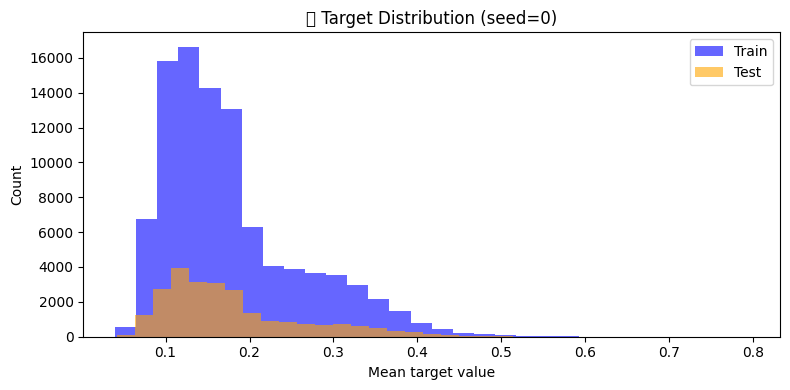

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1015/10000 [00:07<01:02, 142.66it/s]

Epoch [1000/10000], Loss: 0.0039


Epochs:  20%|██        | 2020/10000 [00:14<00:56, 140.83it/s]

Epoch [2000/10000], Loss: 0.0028


Epochs:  30%|███       | 3016/10000 [00:21<00:50, 139.48it/s]

Epoch [3000/10000], Loss: 0.0023


Epochs:  40%|████      | 4014/10000 [00:28<00:43, 138.81it/s]

Epoch [4000/10000], Loss: 0.0019


Epochs:  50%|█████     | 5020/10000 [00:35<00:35, 139.14it/s]

Epoch [5000/10000], Loss: 0.0018


Epochs:  57%|█████▋    | 5708/10000 [00:40<00:30, 140.34it/s]


⏹️ Early stopping at epoch 5709

📊 Metrics:
{'MSE': 0.0019310734, 'MAE': 0.03066626, 'R2': 0.7209466427917921}

🔁 Run 2 / 50 (seed = 1)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


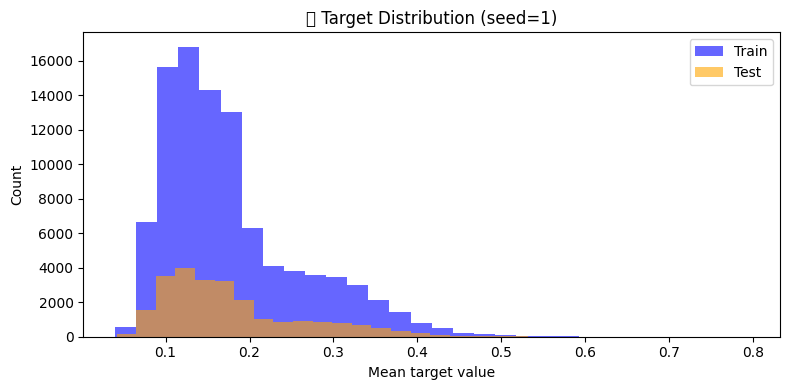

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1022/10000 [00:07<01:03, 140.80it/s]

Epoch [1000/10000], Loss: 0.0038


Epochs:  20%|██        | 2027/10000 [00:14<00:56, 141.33it/s]

Epoch [2000/10000], Loss: 0.0029


Epochs:  30%|███       | 3017/10000 [00:21<00:49, 142.07it/s]

Epoch [3000/10000], Loss: 0.0028


Epochs:  40%|████      | 4022/10000 [00:28<00:41, 142.34it/s]

Epoch [4000/10000], Loss: 0.0020


Epochs:  50%|█████     | 5027/10000 [00:35<00:34, 142.16it/s]

Epoch [5000/10000], Loss: 0.0023


Epochs:  51%|█████     | 5056/10000 [00:35<00:34, 141.48it/s]


⏹️ Early stopping at epoch 5057

📊 Metrics:
{'MSE': 0.0024027652, 'MAE': 0.034918267, 'R2': 0.6549463233367021}

🔁 Run 3 / 50 (seed = 2)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


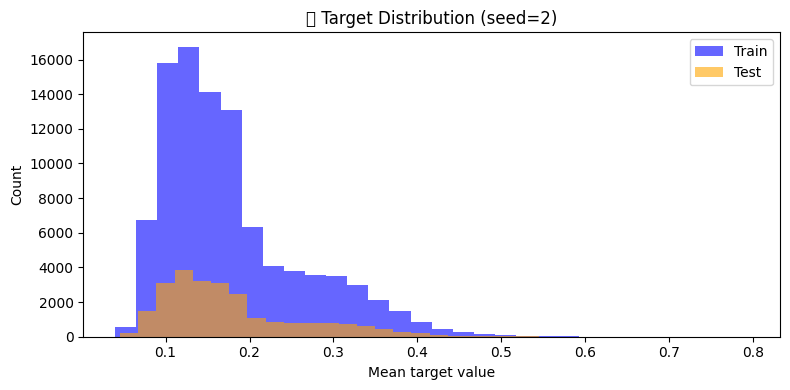

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1022/10000 [00:07<01:03, 142.29it/s]

Epoch [1000/10000], Loss: 0.0041


Epochs:  20%|██        | 2027/10000 [00:14<00:56, 142.09it/s]

Epoch [2000/10000], Loss: 0.0030


Epochs:  20%|██        | 2031/10000 [00:14<00:56, 142.13it/s]


⏹️ Early stopping at epoch 2032

📊 Metrics:
{'MSE': 0.002900067, 'MAE': 0.03934232, 'R2': 0.5836157656593558}

🔁 Run 4 / 50 (seed = 3)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


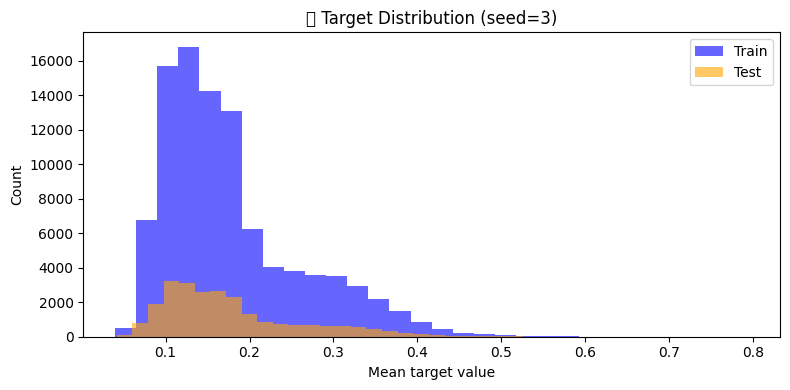

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1022/10000 [00:07<01:03, 141.05it/s]

Epoch [1000/10000], Loss: 0.0039


Epochs:  20%|██        | 2027/10000 [00:14<00:56, 141.05it/s]

Epoch [2000/10000], Loss: 0.0027


Epochs:  30%|███       | 3017/10000 [00:21<00:49, 140.49it/s]

Epoch [3000/10000], Loss: 0.0037


Epochs:  40%|████      | 4021/10000 [00:28<00:42, 140.53it/s]

Epoch [4000/10000], Loss: 0.0021


Epochs:  50%|█████     | 5023/10000 [00:35<00:35, 140.35it/s]

Epoch [5000/10000], Loss: 0.0016


Epochs:  60%|██████    | 6026/10000 [00:42<00:28, 140.65it/s]

Epoch [6000/10000], Loss: 0.0013


Epochs:  70%|███████   | 7016/10000 [00:49<00:21, 140.75it/s]

Epoch [7000/10000], Loss: 0.0013


Epochs:  71%|███████▏  | 7141/10000 [00:50<00:20, 140.79it/s]


⏹️ Early stopping at epoch 7142

📊 Metrics:
{'MSE': 0.0011726215, 'MAE': 0.024050124, 'R2': 0.8290506222991283}

🔁 Run 5 / 50 (seed = 4)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


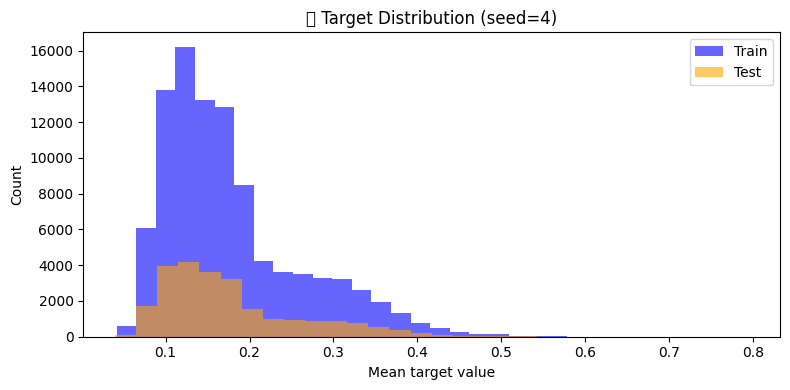

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1022/10000 [00:07<01:03, 141.03it/s]

Epoch [1000/10000], Loss: 0.0041


Epochs:  20%|██        | 2027/10000 [00:14<00:56, 140.86it/s]

Epoch [2000/10000], Loss: 0.0034


Epochs:  30%|███       | 3017/10000 [00:21<00:49, 141.13it/s]

Epoch [3000/10000], Loss: 0.0020


Epochs:  40%|████      | 4022/10000 [00:28<00:42, 141.57it/s]

Epoch [4000/10000], Loss: 0.0015


Epochs:  50%|█████     | 5027/10000 [00:35<00:35, 141.17it/s]

Epoch [5000/10000], Loss: 0.0013


Epochs:  52%|█████▏    | 5207/10000 [00:36<00:33, 141.35it/s]


⏹️ Early stopping at epoch 5208

📊 Metrics:
{'MSE': 0.0013661189, 'MAE': 0.025848664, 'R2': 0.8017147457264691}

🔁 Run 6 / 50 (seed = 5)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


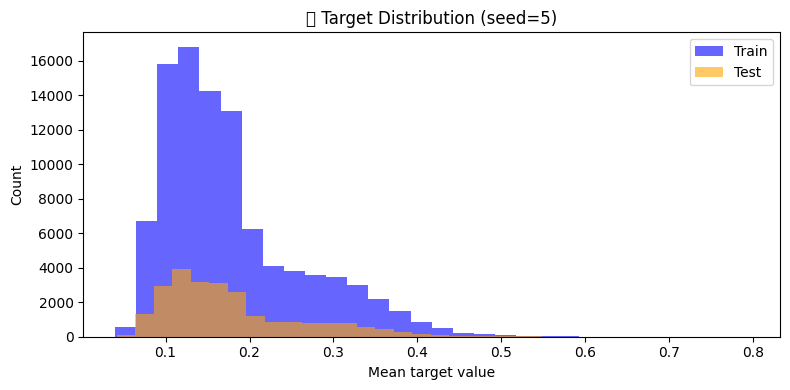

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1022/10000 [00:07<01:03, 141.60it/s]

Epoch [1000/10000], Loss: 0.0047


Epochs:  20%|██        | 2027/10000 [00:14<00:56, 141.51it/s]

Epoch [2000/10000], Loss: 0.0043


Epochs:  30%|███       | 3017/10000 [00:21<00:49, 142.03it/s]

Epoch [3000/10000], Loss: 0.0040


Epochs:  40%|████      | 4022/10000 [00:28<00:42, 141.55it/s]

Epoch [4000/10000], Loss: 0.0024


Epochs:  50%|████▉     | 4996/10000 [00:35<00:35, 141.73it/s]


⏹️ Early stopping at epoch 4997

📊 Metrics:
{'MSE': 0.0030406245, 'MAE': 0.045390297, 'R2': 0.564555004818715}

🔁 Run 7 / 50 (seed = 6)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


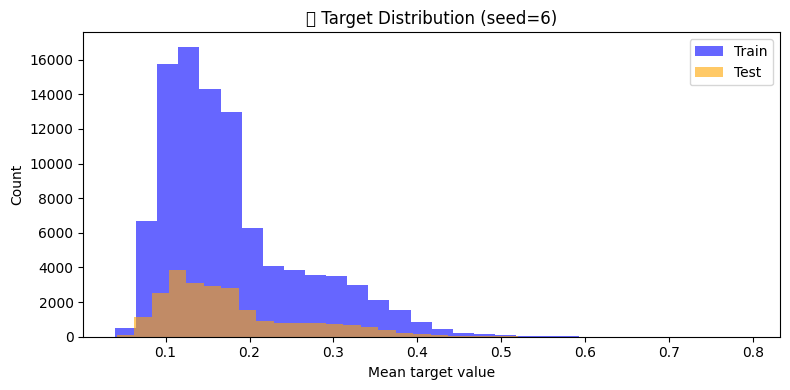

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1022/10000 [00:07<01:03, 142.35it/s]

Epoch [1000/10000], Loss: 0.0041


Epochs:  20%|██        | 2027/10000 [00:14<00:56, 142.07it/s]

Epoch [2000/10000], Loss: 0.0028


Epochs:  30%|███       | 3017/10000 [00:21<00:49, 142.02it/s]

Epoch [3000/10000], Loss: 0.0024


Epochs:  40%|████      | 4022/10000 [00:28<00:42, 141.85it/s]

Epoch [4000/10000], Loss: 0.0025


Epochs:  50%|█████     | 5027/10000 [00:35<00:35, 141.68it/s]

Epoch [5000/10000], Loss: 0.0016


Epochs:  60%|██████    | 6017/10000 [00:42<00:28, 141.84it/s]

Epoch [6000/10000], Loss: 0.0015


Epochs:  70%|███████   | 7022/10000 [00:49<00:21, 140.58it/s]

Epoch [7000/10000], Loss: 0.0012


Epochs:  80%|████████  | 8027/10000 [00:56<00:13, 141.43it/s]

Epoch [8000/10000], Loss: 0.0009


Epochs:  84%|████████▍ | 8380/10000 [00:59<00:11, 141.71it/s]


⏹️ Early stopping at epoch 8381

📊 Metrics:
{'MSE': 0.0010430967, 'MAE': 0.023849308, 'R2': 0.8486351432196259}

🔁 Run 8 / 50 (seed = 7)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


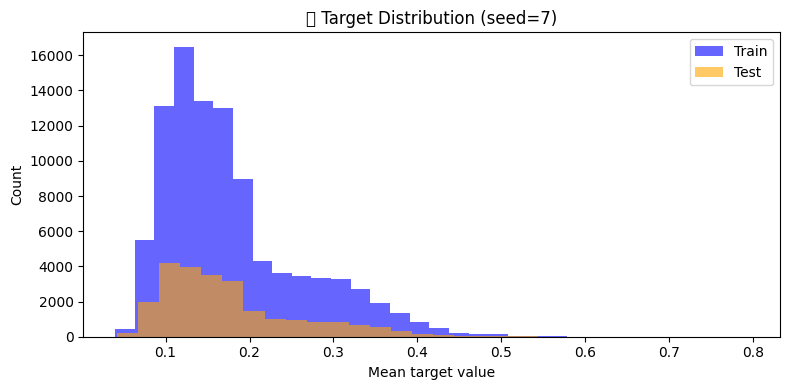

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1022/10000 [00:07<01:03, 141.60it/s]

Epoch [1000/10000], Loss: 0.0039


Epochs:  20%|██        | 2027/10000 [00:14<00:56, 141.43it/s]

Epoch [2000/10000], Loss: 0.0026


Epochs:  30%|███       | 3017/10000 [00:21<00:49, 141.43it/s]

Epoch [3000/10000], Loss: 0.0021


Epochs:  40%|████      | 4022/10000 [00:28<00:42, 141.68it/s]

Epoch [4000/10000], Loss: 0.0020


Epochs:  50%|█████     | 5027/10000 [00:35<00:35, 140.51it/s]

Epoch [5000/10000], Loss: 0.0016


Epochs:  59%|█████▊    | 5873/10000 [00:41<00:29, 141.61it/s]


⏹️ Early stopping at epoch 5874

📊 Metrics:
{'MSE': 0.00136283, 'MAE': 0.024897438, 'R2': 0.8014271245769271}

🔁 Run 9 / 50 (seed = 8)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


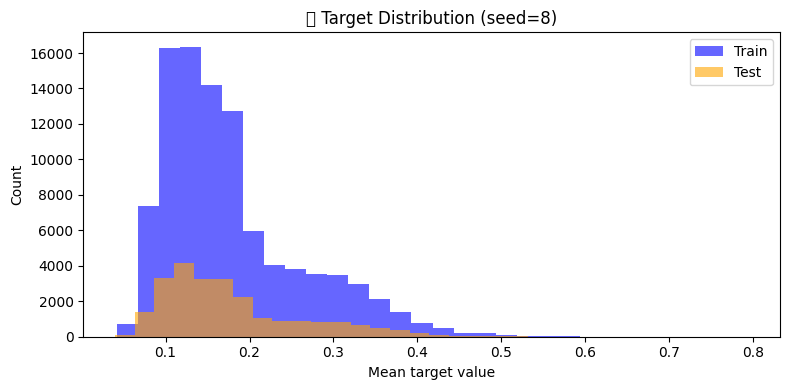

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1022/10000 [00:07<01:03, 141.74it/s]

Epoch [1000/10000], Loss: 0.0044


Epochs:  20%|██        | 2027/10000 [00:14<00:56, 142.01it/s]

Epoch [2000/10000], Loss: 0.0035


Epochs:  30%|███       | 3017/10000 [00:21<00:49, 141.63it/s]

Epoch [3000/10000], Loss: 0.0029


Epochs:  40%|████      | 4022/10000 [00:28<00:42, 141.02it/s]

Epoch [4000/10000], Loss: 0.0023


Epochs:  50%|█████     | 5027/10000 [00:35<00:35, 141.34it/s]

Epoch [5000/10000], Loss: 0.0019


Epochs:  60%|██████    | 6017/10000 [00:42<00:28, 141.09it/s]

Epoch [6000/10000], Loss: 0.0015


Epochs:  68%|██████▊   | 6809/10000 [00:48<00:22, 141.76it/s]


⏹️ Early stopping at epoch 6810

📊 Metrics:
{'MSE': 0.0012910566, 'MAE': 0.024991477, 'R2': 0.8151387462964613}

🔁 Run 10 / 50 (seed = 9)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


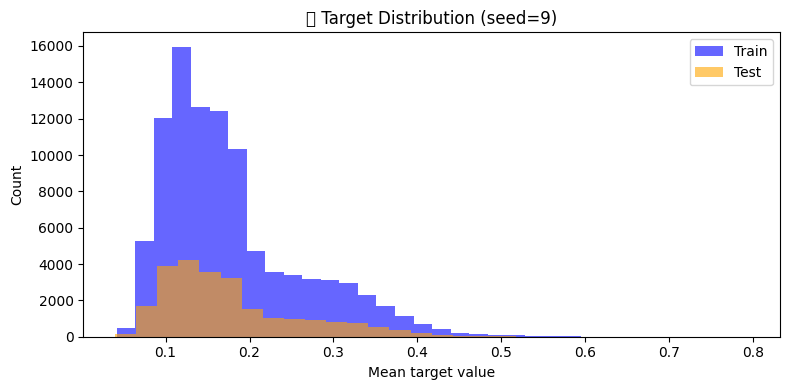

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1022/10000 [00:07<01:03, 141.12it/s]

Epoch [1000/10000], Loss: 0.0040


Epochs:  20%|██        | 2027/10000 [00:14<00:56, 140.87it/s]

Epoch [2000/10000], Loss: 0.0029


Epochs:  20%|██        | 2028/10000 [00:14<00:56, 141.28it/s]


⏹️ Early stopping at epoch 2029

📊 Metrics:
{'MSE': 0.002875685, 'MAE': 0.038882483, 'R2': 0.5842396507814399}

🔁 Run 11 / 50 (seed = 10)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


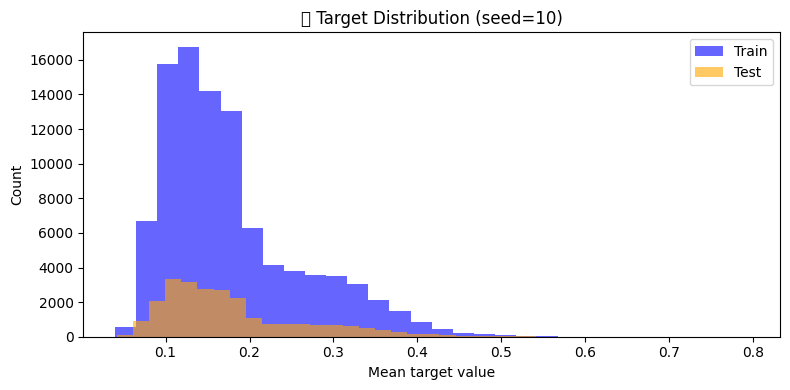

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1022/10000 [00:07<01:03, 141.47it/s]

Epoch [1000/10000], Loss: 0.0041


Epochs:  20%|██        | 2027/10000 [00:14<00:56, 141.43it/s]

Epoch [2000/10000], Loss: 0.0029


Epochs:  30%|███       | 3017/10000 [00:21<00:49, 140.89it/s]

Epoch [3000/10000], Loss: 0.0022


Epochs:  40%|████      | 4022/10000 [00:28<00:42, 141.34it/s]

Epoch [4000/10000], Loss: 0.0018


Epochs:  50%|█████     | 5027/10000 [00:35<00:35, 141.20it/s]

Epoch [5000/10000], Loss: 0.0017


Epochs:  60%|██████    | 6017/10000 [00:42<00:28, 141.41it/s]

Epoch [6000/10000], Loss: 0.0012


Epochs:  61%|██████    | 6063/10000 [00:42<00:27, 141.21it/s]


⏹️ Early stopping at epoch 6064

📊 Metrics:
{'MSE': 0.0013802084, 'MAE': 0.026147595, 'R2': 0.8026150275030568}

🔁 Run 12 / 50 (seed = 11)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


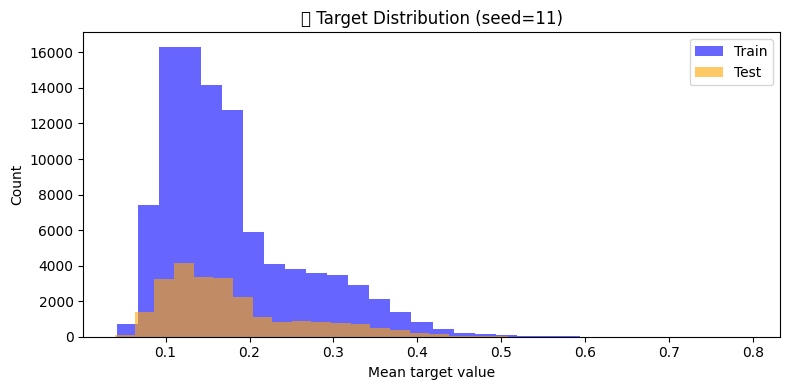

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1022/10000 [00:07<01:03, 142.12it/s]

Epoch [1000/10000], Loss: 0.0043


Epochs:  20%|██        | 2027/10000 [00:14<00:56, 141.87it/s]

Epoch [2000/10000], Loss: 0.0037


Epochs:  30%|███       | 3017/10000 [00:21<00:49, 141.02it/s]

Epoch [3000/10000], Loss: 0.0030


Epochs:  40%|████      | 4022/10000 [00:28<00:42, 141.48it/s]

Epoch [4000/10000], Loss: 0.0021


Epochs:  50%|█████     | 5027/10000 [00:35<00:35, 141.74it/s]

Epoch [5000/10000], Loss: 0.0016


Epochs:  60%|██████    | 6017/10000 [00:42<00:28, 141.52it/s]

Epoch [6000/10000], Loss: 0.0015


Epochs:  70%|███████   | 7022/10000 [00:49<00:20, 141.85it/s]

Epoch [7000/10000], Loss: 0.0013


Epochs:  72%|███████▏  | 7185/10000 [00:50<00:19, 141.60it/s]


⏹️ Early stopping at epoch 7186

📊 Metrics:
{'MSE': 0.0012475983, 'MAE': 0.025140475, 'R2': 0.819097937458403}

🔁 Run 13 / 50 (seed = 12)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


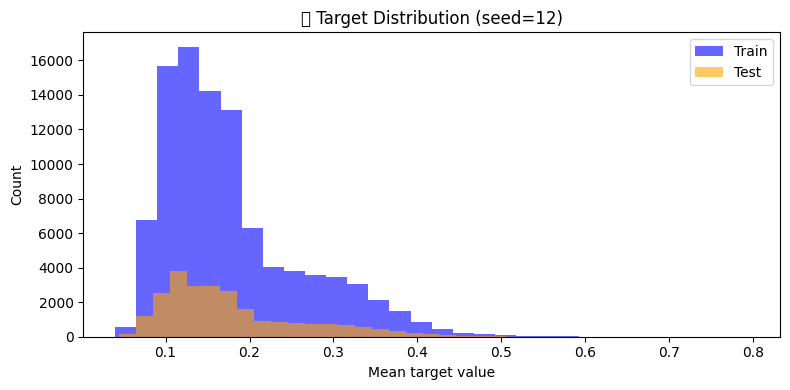

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1022/10000 [00:07<01:03, 141.74it/s]

Epoch [1000/10000], Loss: 0.0049


Epochs:  20%|██        | 2027/10000 [00:14<00:56, 141.63it/s]

Epoch [2000/10000], Loss: 0.0034


Epochs:  30%|███       | 3017/10000 [00:21<00:49, 141.58it/s]

Epoch [3000/10000], Loss: 0.0026


Epochs:  40%|████      | 4022/10000 [00:28<00:42, 141.51it/s]

Epoch [4000/10000], Loss: 0.0023


Epochs:  50%|█████     | 5027/10000 [00:35<00:35, 141.00it/s]

Epoch [5000/10000], Loss: 0.0015


Epochs:  60%|█████▉    | 5955/10000 [00:42<00:28, 141.54it/s]


⏹️ Early stopping at epoch 5956

📊 Metrics:
{'MSE': 0.0023479983, 'MAE': 0.03646044, 'R2': 0.6605622898939366}

🔁 Run 14 / 50 (seed = 13)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


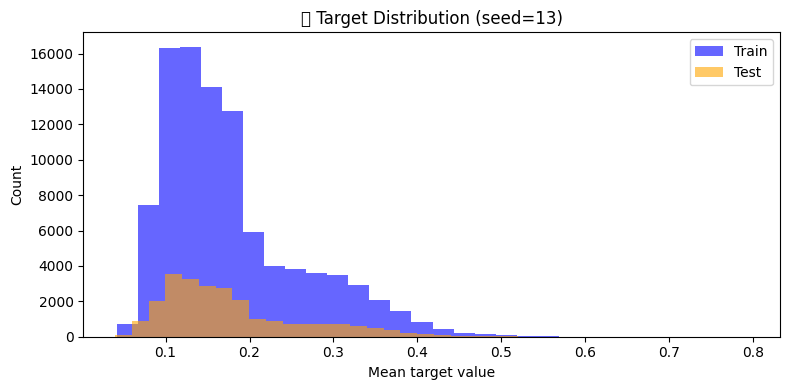

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1022/10000 [00:07<01:03, 141.73it/s]

Epoch [1000/10000], Loss: 0.0044


Epochs:  20%|██        | 2027/10000 [00:14<00:56, 142.09it/s]

Epoch [2000/10000], Loss: 0.0031


Epochs:  30%|███       | 3017/10000 [00:21<00:48, 142.53it/s]

Epoch [3000/10000], Loss: 0.0036


Epochs:  40%|████      | 4022/10000 [00:28<00:42, 141.81it/s]

Epoch [4000/10000], Loss: 0.0026


Epochs:  50%|█████     | 5027/10000 [00:35<00:35, 142.04it/s]

Epoch [5000/10000], Loss: 0.0020


Epochs:  60%|██████    | 6017/10000 [00:42<00:28, 141.55it/s]

Epoch [6000/10000], Loss: 0.0022


Epochs:  63%|██████▎   | 6288/10000 [00:44<00:26, 141.98it/s]


⏹️ Early stopping at epoch 6289

📊 Metrics:
{'MSE': 0.0018512427, 'MAE': 0.032577604, 'R2': 0.7338756847612904}

🔁 Run 15 / 50 (seed = 14)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


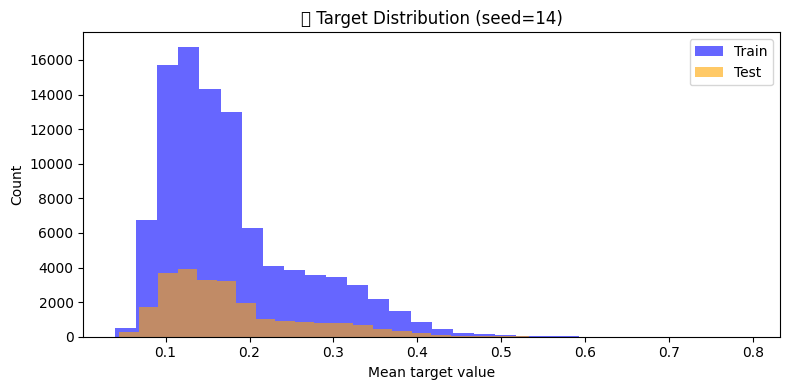

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1022/10000 [00:07<01:03, 141.56it/s]

Epoch [1000/10000], Loss: 0.0044


Epochs:  20%|██        | 2027/10000 [00:14<00:56, 141.86it/s]

Epoch [2000/10000], Loss: 0.0030


Epochs:  30%|███       | 3017/10000 [00:21<00:49, 140.73it/s]

Epoch [3000/10000], Loss: 0.0031


Epochs:  40%|████      | 4022/10000 [00:28<00:42, 140.89it/s]

Epoch [4000/10000], Loss: 0.0022


Epochs:  44%|████▍     | 4390/10000 [00:31<00:39, 141.49it/s]


⏹️ Early stopping at epoch 4391

📊 Metrics:
{'MSE': 0.0019491517, 'MAE': 0.030749246, 'R2': 0.7190342982702627}

🔁 Run 16 / 50 (seed = 15)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


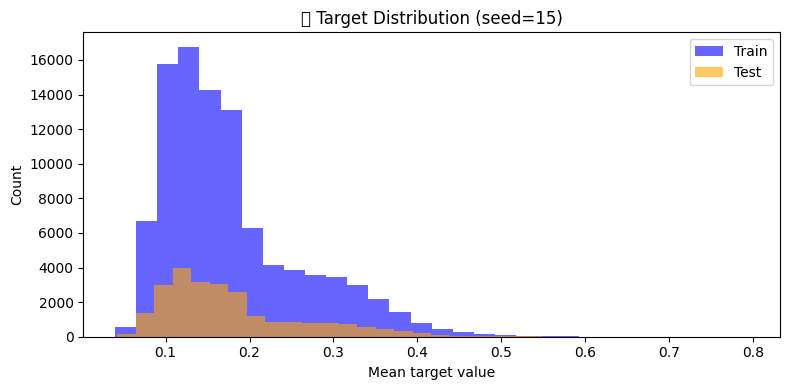

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1022/10000 [00:07<01:03, 142.23it/s]

Epoch [1000/10000], Loss: 0.0049


Epochs:  20%|██        | 2027/10000 [00:14<00:56, 141.62it/s]

Epoch [2000/10000], Loss: 0.0034


Epochs:  30%|███       | 3017/10000 [00:21<00:49, 141.07it/s]

Epoch [3000/10000], Loss: 0.0023


Epochs:  40%|████      | 4022/10000 [00:28<00:42, 141.72it/s]

Epoch [4000/10000], Loss: 0.0021


Epochs:  50%|█████     | 5027/10000 [00:35<00:35, 141.60it/s]

Epoch [5000/10000], Loss: 0.0030


Epochs:  54%|█████▍    | 5375/10000 [00:37<00:32, 141.79it/s]


⏹️ Early stopping at epoch 5376

📊 Metrics:
{'MSE': 0.001641964, 'MAE': 0.02956336, 'R2': 0.7683189284681897}

🔁 Run 17 / 50 (seed = 16)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


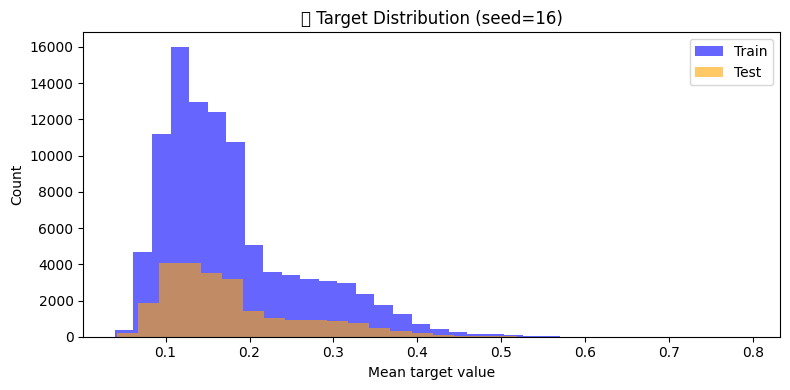

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1022/10000 [00:07<01:03, 141.65it/s]

Epoch [1000/10000], Loss: 0.0048


Epochs:  20%|██        | 2027/10000 [00:14<00:56, 141.63it/s]

Epoch [2000/10000], Loss: 0.0040


Epochs:  30%|███       | 3017/10000 [00:21<00:49, 141.22it/s]

Epoch [3000/10000], Loss: 0.0025


Epochs:  39%|███▉      | 3934/10000 [00:27<00:42, 141.48it/s]


⏹️ Early stopping at epoch 3935

📊 Metrics:
{'MSE': 0.0020279542, 'MAE': 0.031531036, 'R2': 0.7059793588638581}

🔁 Run 18 / 50 (seed = 17)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


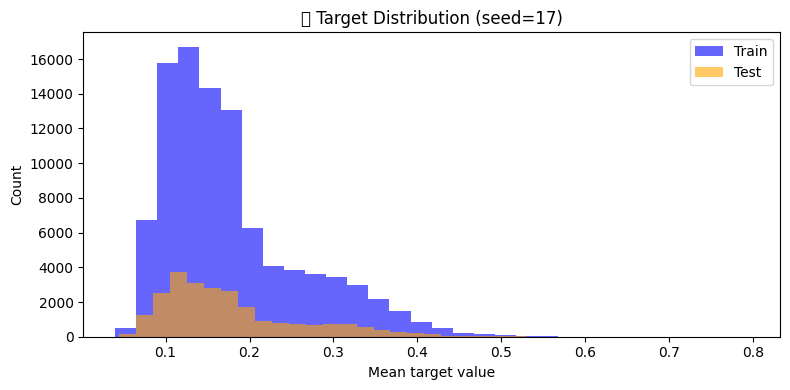

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1022/10000 [00:07<01:03, 141.15it/s]

Epoch [1000/10000], Loss: 0.0040


Epochs:  20%|██        | 2027/10000 [00:14<00:56, 141.17it/s]

Epoch [2000/10000], Loss: 0.0024


Epochs:  30%|███       | 3017/10000 [00:21<00:49, 141.08it/s]

Epoch [3000/10000], Loss: 0.0021


Epochs:  40%|████      | 4022/10000 [00:28<00:42, 141.35it/s]

Epoch [4000/10000], Loss: 0.0017


Epochs:  50%|█████     | 5027/10000 [00:35<00:35, 141.20it/s]

Epoch [5000/10000], Loss: 0.0017


Epochs:  56%|█████▋    | 5650/10000 [00:40<00:30, 141.22it/s]


⏹️ Early stopping at epoch 5651

📊 Metrics:
{'MSE': 0.0015951274, 'MAE': 0.02972833, 'R2': 0.7730557251899635}

🔁 Run 19 / 50 (seed = 18)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


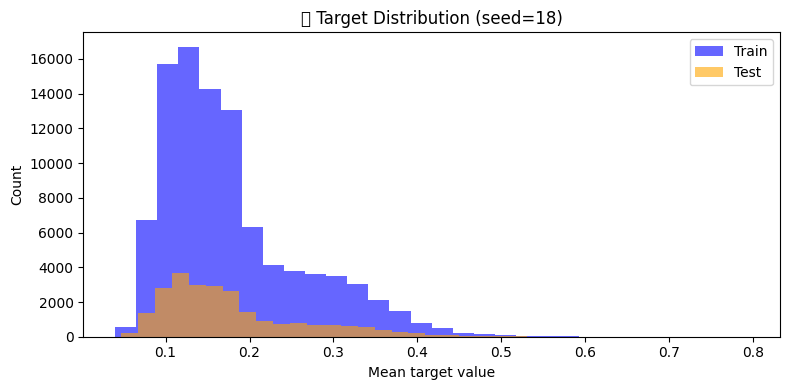

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1022/10000 [00:07<01:03, 141.82it/s]

Epoch [1000/10000], Loss: 0.0045


Epochs:  20%|██        | 2027/10000 [00:14<00:56, 141.62it/s]

Epoch [2000/10000], Loss: 0.0034


Epochs:  30%|███       | 3017/10000 [00:21<00:49, 141.98it/s]

Epoch [3000/10000], Loss: 0.0030


Epochs:  40%|████      | 4022/10000 [00:28<00:42, 141.73it/s]

Epoch [4000/10000], Loss: 0.0021


Epochs:  50%|█████     | 5027/10000 [00:35<00:35, 141.46it/s]

Epoch [5000/10000], Loss: 0.0017


Epochs:  60%|██████    | 6017/10000 [00:42<00:28, 141.68it/s]

Epoch [6000/10000], Loss: 0.0014


Epochs:  64%|██████▎   | 6354/10000 [00:44<00:25, 141.69it/s]


⏹️ Early stopping at epoch 6355

📊 Metrics:
{'MSE': 0.0014512226, 'MAE': 0.02611821, 'R2': 0.7917216468477548}

🔁 Run 20 / 50 (seed = 19)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


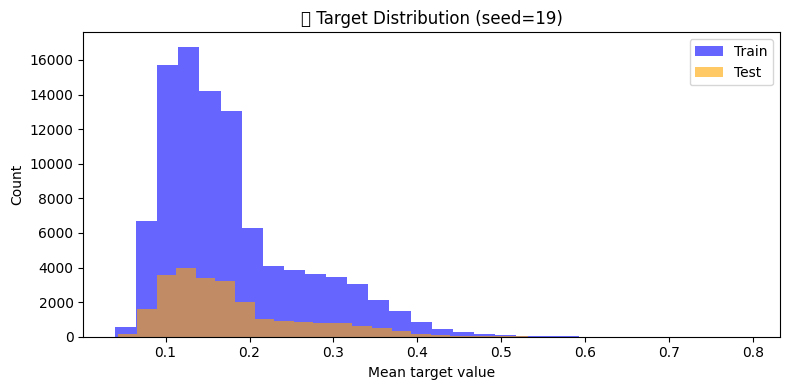

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1022/10000 [00:07<01:03, 142.27it/s]

Epoch [1000/10000], Loss: 0.0038


Epochs:  20%|██        | 2027/10000 [00:14<00:56, 141.66it/s]

Epoch [2000/10000], Loss: 0.0027


Epochs:  30%|███       | 3017/10000 [00:21<00:49, 141.59it/s]

Epoch [3000/10000], Loss: 0.0027


Epochs:  40%|████      | 4022/10000 [00:28<00:42, 139.87it/s]

Epoch [4000/10000], Loss: 0.0021


Epochs:  50%|█████     | 5027/10000 [00:35<00:35, 141.58it/s]

Epoch [5000/10000], Loss: 0.0019


Epochs:  60%|██████    | 6017/10000 [00:42<00:28, 142.09it/s]

Epoch [6000/10000], Loss: 0.0021


Epochs:  60%|██████    | 6050/10000 [00:42<00:27, 141.77it/s]


⏹️ Early stopping at epoch 6051

📊 Metrics:
{'MSE': 0.0013444447, 'MAE': 0.025356483, 'R2': 0.8060346151192651}

🔁 Run 21 / 50 (seed = 20)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


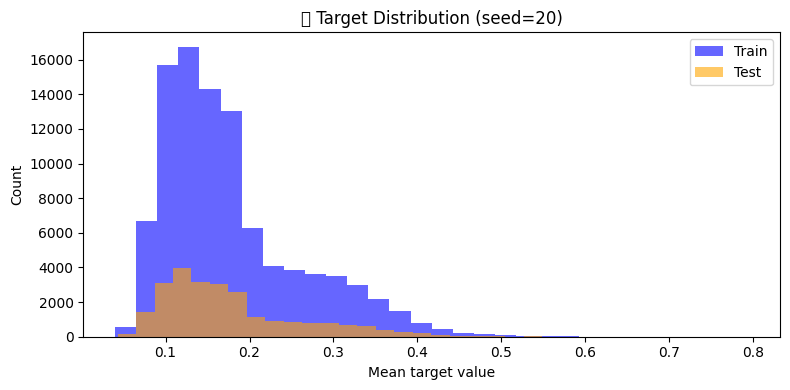

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1022/10000 [00:07<01:03, 141.99it/s]

Epoch [1000/10000], Loss: 0.0038


Epochs:  20%|██        | 2027/10000 [00:14<00:55, 142.38it/s]

Epoch [2000/10000], Loss: 0.0033


Epochs:  30%|███       | 3017/10000 [00:21<00:49, 141.92it/s]

Epoch [3000/10000], Loss: 0.0025


Epochs:  40%|████      | 4022/10000 [00:28<00:42, 141.68it/s]

Epoch [4000/10000], Loss: 0.0020


Epochs:  50%|█████     | 5027/10000 [00:35<00:35, 141.94it/s]

Epoch [5000/10000], Loss: 0.0015


Epochs:  58%|█████▊    | 5784/10000 [00:40<00:29, 141.98it/s]


⏹️ Early stopping at epoch 5785

📊 Metrics:
{'MSE': 0.0013477155, 'MAE': 0.025577094, 'R2': 0.8046508681344238}

🔁 Run 22 / 50 (seed = 21)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


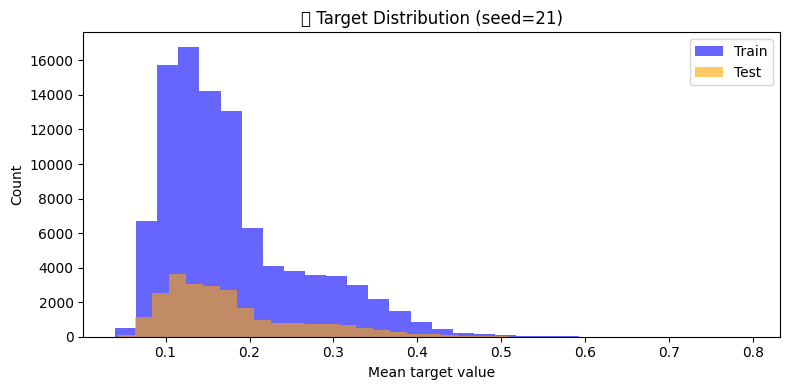

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1022/10000 [00:07<01:03, 141.26it/s]

Epoch [1000/10000], Loss: 0.0041


Epochs:  20%|██        | 2027/10000 [00:14<00:56, 142.02it/s]

Epoch [2000/10000], Loss: 0.0027


Epochs:  30%|███       | 3017/10000 [00:21<00:49, 141.81it/s]

Epoch [3000/10000], Loss: 0.0039


Epochs:  40%|████      | 4022/10000 [00:28<00:42, 141.58it/s]

Epoch [4000/10000], Loss: 0.0038


Epochs:  50%|█████     | 5027/10000 [00:35<00:34, 142.14it/s]

Epoch [5000/10000], Loss: 0.0027


Epochs:  60%|██████    | 6017/10000 [00:42<00:28, 141.60it/s]

Epoch [6000/10000], Loss: 0.0015


Epochs:  61%|██████    | 6100/10000 [00:43<00:27, 141.84it/s]


⏹️ Early stopping at epoch 6101

📊 Metrics:
{'MSE': 0.0015490082, 'MAE': 0.026864167, 'R2': 0.7752095813636203}

🔁 Run 23 / 50 (seed = 22)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


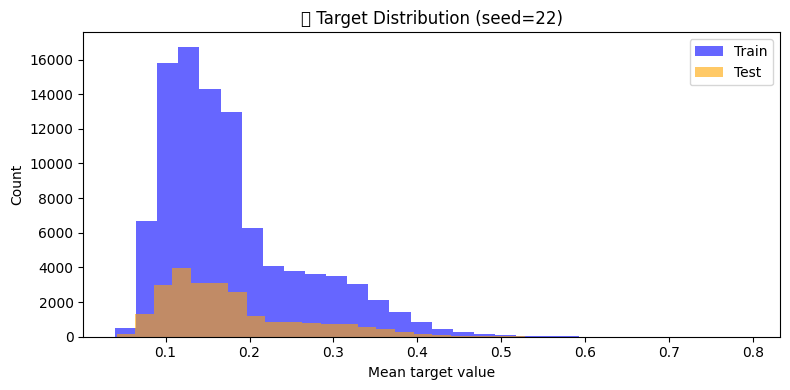

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1022/10000 [00:07<01:03, 141.71it/s]

Epoch [1000/10000], Loss: 0.0035


Epochs:  20%|██        | 2027/10000 [00:14<00:56, 141.23it/s]

Epoch [2000/10000], Loss: 0.0027


Epochs:  30%|███       | 3017/10000 [00:21<00:49, 141.25it/s]

Epoch [3000/10000], Loss: 0.0027


Epochs:  40%|████      | 4022/10000 [00:28<00:42, 141.54it/s]

Epoch [4000/10000], Loss: 0.0021


Epochs:  50%|█████     | 5027/10000 [00:35<00:35, 141.14it/s]

Epoch [5000/10000], Loss: 0.0019


Epochs:  60%|██████    | 6017/10000 [00:42<00:28, 140.85it/s]

Epoch [6000/10000], Loss: 0.0014


Epochs:  70%|███████   | 7022/10000 [00:49<00:21, 140.74it/s]

Epoch [7000/10000], Loss: 0.0012


Epochs:  80%|████████  | 8027/10000 [00:56<00:13, 141.08it/s]

Epoch [8000/10000], Loss: 0.0011


Epochs:  88%|████████▊ | 8806/10000 [01:02<00:08, 141.28it/s]


⏹️ Early stopping at epoch 8807

📊 Metrics:
{'MSE': 0.006347703, 'MAE': 0.05705691, 'R2': 0.08623147195317282}

🔁 Run 24 / 50 (seed = 23)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


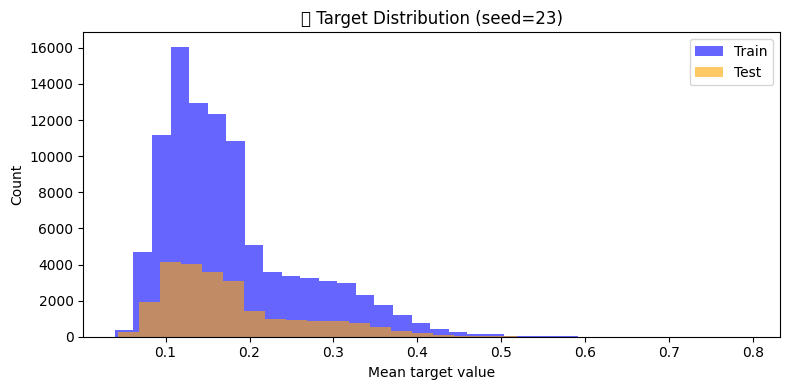

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1022/10000 [00:07<01:03, 141.60it/s]

Epoch [1000/10000], Loss: 0.0045


Epochs:  20%|██        | 2027/10000 [00:14<00:56, 141.17it/s]

Epoch [2000/10000], Loss: 0.0037


Epochs:  30%|███       | 3017/10000 [00:21<00:49, 141.89it/s]

Epoch [3000/10000], Loss: 0.0035


Epochs:  40%|████      | 4022/10000 [00:28<00:42, 141.31it/s]

Epoch [4000/10000], Loss: 0.0023


Epochs:  50%|█████     | 5027/10000 [00:35<00:35, 141.39it/s]

Epoch [5000/10000], Loss: 0.0020


Epochs:  60%|██████    | 6017/10000 [00:42<00:28, 141.33it/s]

Epoch [6000/10000], Loss: 0.0014


Epochs:  70%|███████   | 7018/10000 [00:49<00:21, 141.49it/s]


Epoch [7000/10000], Loss: 0.0012
⏹️ Early stopping at epoch 7019

📊 Metrics:
{'MSE': 0.0012931791, 'MAE': 0.024979044, 'R2': 0.8156021108652598}

🔁 Run 25 / 50 (seed = 24)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


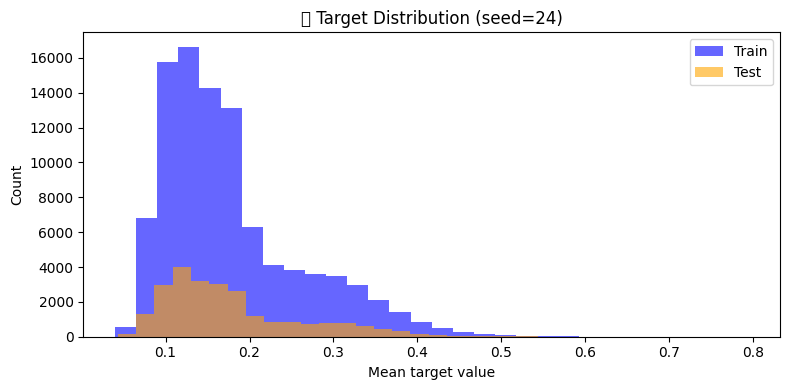

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1022/10000 [00:07<01:03, 141.44it/s]

Epoch [1000/10000], Loss: 0.0036


Epochs:  20%|██        | 2027/10000 [00:14<00:56, 141.48it/s]

Epoch [2000/10000], Loss: 0.0029


Epochs:  30%|███       | 3017/10000 [00:21<00:49, 141.35it/s]

Epoch [3000/10000], Loss: 0.0023


Epochs:  40%|████      | 4022/10000 [00:28<00:42, 141.69it/s]

Epoch [4000/10000], Loss: 0.0019


Epochs:  48%|████▊     | 4781/10000 [00:33<00:36, 141.49it/s]


⏹️ Early stopping at epoch 4782

📊 Metrics:
{'MSE': 0.0017629535, 'MAE': 0.029690828, 'R2': 0.746724105668279}

🔁 Run 26 / 50 (seed = 25)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


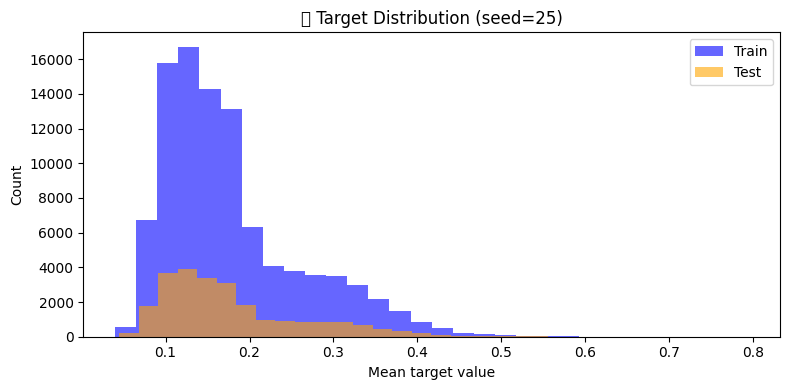

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1022/10000 [00:07<01:03, 141.68it/s]

Epoch [1000/10000], Loss: 0.0040


Epochs:  20%|██        | 2027/10000 [00:14<00:56, 141.51it/s]

Epoch [2000/10000], Loss: 0.0029


Epochs:  30%|███       | 3017/10000 [00:21<00:49, 141.94it/s]

Epoch [3000/10000], Loss: 0.0031


Epochs:  40%|████      | 4022/10000 [00:28<00:42, 141.51it/s]

Epoch [4000/10000], Loss: 0.0021


Epochs:  50%|█████     | 5027/10000 [00:35<00:35, 141.06it/s]

Epoch [5000/10000], Loss: 0.0017


Epochs:  60%|██████    | 6017/10000 [00:42<00:28, 141.07it/s]

Epoch [6000/10000], Loss: 0.0013


Epochs:  69%|██████▉   | 6932/10000 [00:49<00:21, 141.34it/s]


⏹️ Early stopping at epoch 6933

📊 Metrics:
{'MSE': 0.0012645777, 'MAE': 0.025236584, 'R2': 0.8221670193973324}

🔁 Run 27 / 50 (seed = 26)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


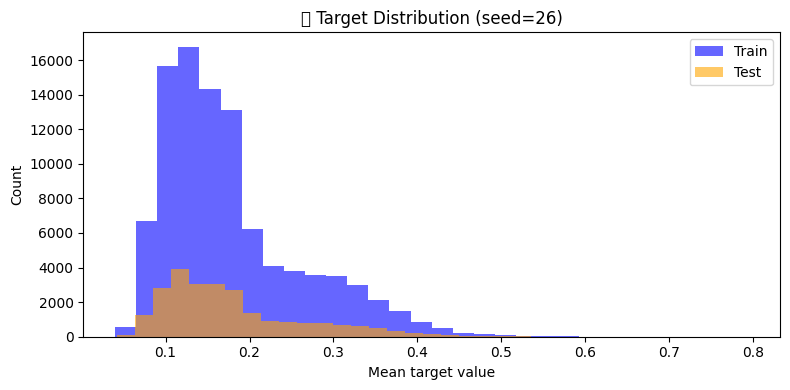

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1022/10000 [00:07<01:03, 142.03it/s]

Epoch [1000/10000], Loss: 0.0042


Epochs:  20%|██        | 2027/10000 [00:14<00:56, 141.24it/s]

Epoch [2000/10000], Loss: 0.0066


Epochs:  30%|███       | 3017/10000 [00:21<00:49, 141.22it/s]

Epoch [3000/10000], Loss: 0.0028


Epochs:  40%|████      | 4022/10000 [00:28<00:42, 141.51it/s]

Epoch [4000/10000], Loss: 0.0027


Epochs:  50%|█████     | 5027/10000 [00:35<00:35, 141.21it/s]

Epoch [5000/10000], Loss: 0.0031


Epochs:  59%|█████▉    | 5911/10000 [00:41<00:28, 141.54it/s]


⏹️ Early stopping at epoch 5912

📊 Metrics:
{'MSE': 0.0019029455, 'MAE': 0.03192819, 'R2': 0.7243745560092913}

🔁 Run 28 / 50 (seed = 27)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


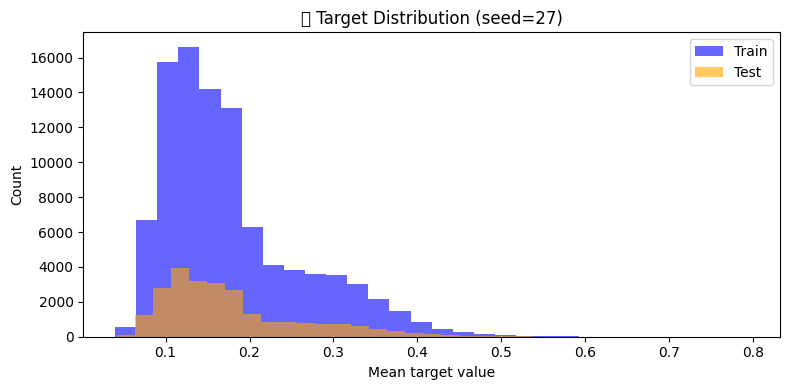

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1022/10000 [00:07<01:03, 141.26it/s]

Epoch [1000/10000], Loss: 0.0038


Epochs:  20%|██        | 2027/10000 [00:14<00:56, 141.48it/s]

Epoch [2000/10000], Loss: 0.0026


Epochs:  30%|███       | 3017/10000 [00:21<00:49, 141.51it/s]

Epoch [3000/10000], Loss: 0.0022


Epochs:  31%|███       | 3073/10000 [00:21<00:48, 141.51it/s]


⏹️ Early stopping at epoch 3074

📊 Metrics:
{'MSE': 0.0033508588, 'MAE': 0.041611418, 'R2': 0.5131448095449868}

🔁 Run 29 / 50 (seed = 28)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


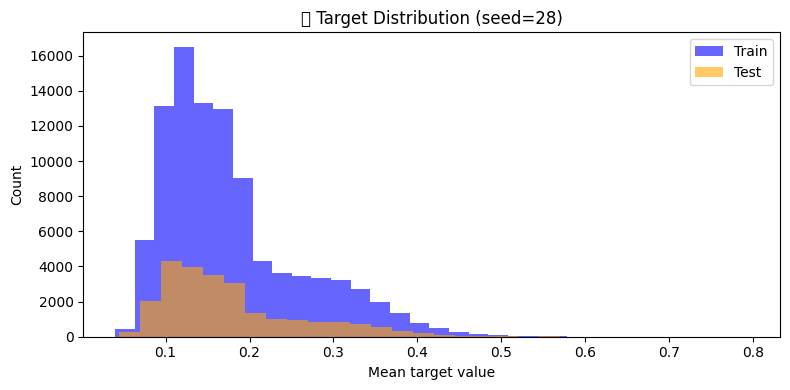

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1022/10000 [00:07<01:03, 141.54it/s]

Epoch [1000/10000], Loss: 0.0047


Epochs:  20%|██        | 2027/10000 [00:14<00:56, 141.54it/s]

Epoch [2000/10000], Loss: 0.0034


Epochs:  30%|███       | 3017/10000 [00:21<00:49, 141.73it/s]

Epoch [3000/10000], Loss: 0.0029


Epochs:  40%|████      | 4022/10000 [00:28<00:42, 141.27it/s]

Epoch [4000/10000], Loss: 0.0029


Epochs:  44%|████▎     | 4370/10000 [00:30<00:39, 141.56it/s]


⏹️ Early stopping at epoch 4371

📊 Metrics:
{'MSE': 0.0023804666, 'MAE': 0.03699399, 'R2': 0.6521754949481984}

🔁 Run 30 / 50 (seed = 29)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


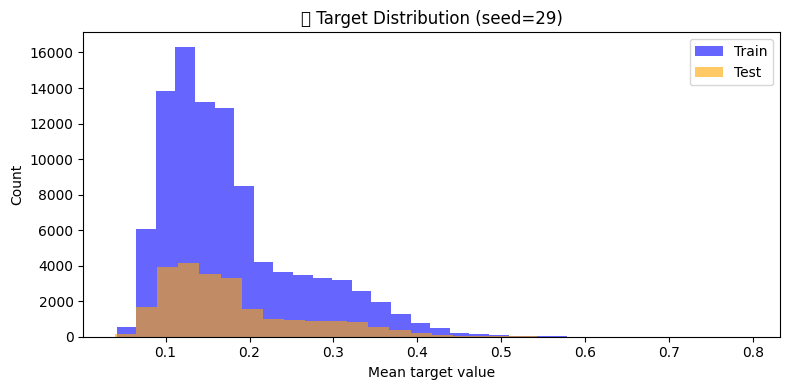

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1022/10000 [00:07<01:03, 141.52it/s]

Epoch [1000/10000], Loss: 0.0044


Epochs:  20%|██        | 2027/10000 [00:14<00:56, 141.93it/s]

Epoch [2000/10000], Loss: 0.0030


Epochs:  30%|███       | 3017/10000 [00:21<00:49, 141.44it/s]

Epoch [3000/10000], Loss: 0.0024


Epochs:  38%|███▊      | 3783/10000 [00:26<00:43, 141.57it/s]


⏹️ Early stopping at epoch 3784

📊 Metrics:
{'MSE': 0.0020850804, 'MAE': 0.033321094, 'R2': 0.7033542635957568}

🔁 Run 31 / 50 (seed = 30)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


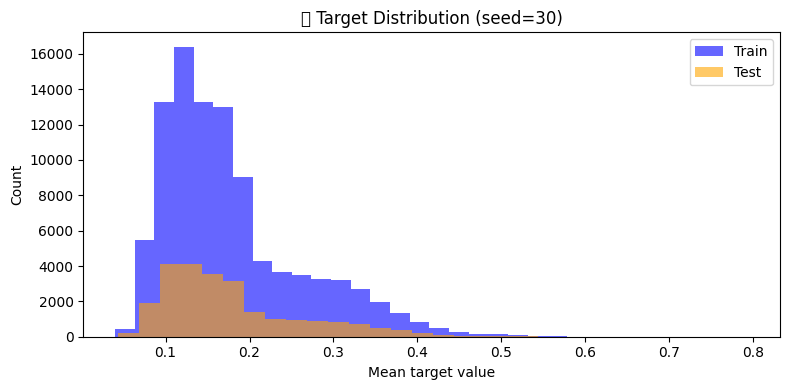

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1022/10000 [00:07<01:03, 142.07it/s]

Epoch [1000/10000], Loss: 0.0038


Epochs:  20%|██        | 2027/10000 [00:14<00:56, 141.97it/s]

Epoch [2000/10000], Loss: 0.0025


Epochs:  26%|██▋       | 2645/10000 [00:18<00:51, 141.79it/s]


⏹️ Early stopping at epoch 2646

📊 Metrics:
{'MSE': 0.0023160412, 'MAE': 0.03362838, 'R2': 0.6628008025679566}

🔁 Run 32 / 50 (seed = 31)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


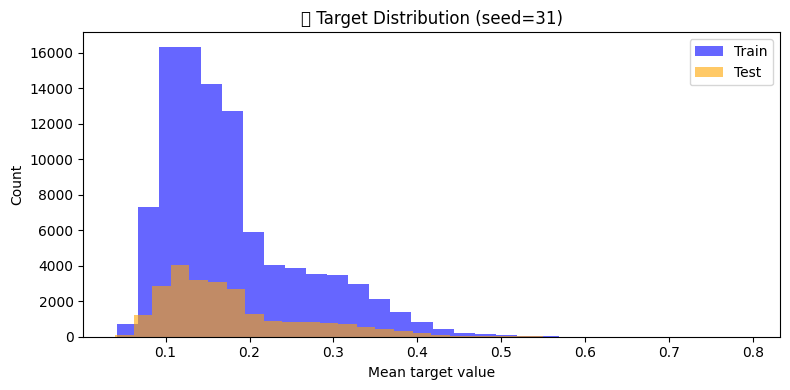

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1022/10000 [00:07<01:03, 141.88it/s]

Epoch [1000/10000], Loss: 0.0047


Epochs:  20%|█▉        | 1957/10000 [00:13<00:56, 142.22it/s]


⏹️ Early stopping at epoch 1958

📊 Metrics:
{'MSE': 0.0035536692, 'MAE': 0.043667257, 'R2': 0.49113252507322114}

🔁 Run 33 / 50 (seed = 32)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


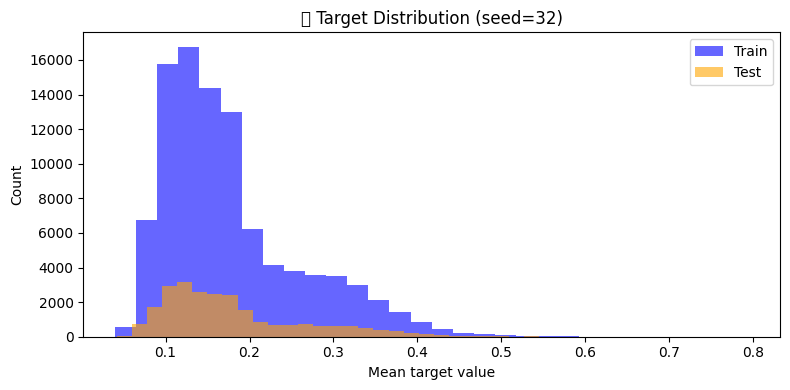

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1022/10000 [00:07<01:03, 141.47it/s]

Epoch [1000/10000], Loss: 0.0045


Epochs:  20%|██        | 2027/10000 [00:14<00:56, 141.70it/s]

Epoch [2000/10000], Loss: 0.0031


Epochs:  30%|███       | 3017/10000 [00:21<00:49, 140.94it/s]

Epoch [3000/10000], Loss: 0.0025


Epochs:  40%|████      | 4022/10000 [00:28<00:42, 141.10it/s]

Epoch [4000/10000], Loss: 0.0021


Epochs:  50%|█████     | 5027/10000 [00:35<00:35, 141.53it/s]

Epoch [5000/10000], Loss: 0.0022


Epochs:  60%|██████    | 6017/10000 [00:42<00:28, 141.25it/s]

Epoch [6000/10000], Loss: 0.0021


Epochs:  66%|██████▌   | 6556/10000 [00:46<00:24, 141.41it/s]


⏹️ Early stopping at epoch 6557

📊 Metrics:
{'MSE': 0.0014534815, 'MAE': 0.026752349, 'R2': 0.791961505161157}

🔁 Run 34 / 50 (seed = 33)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


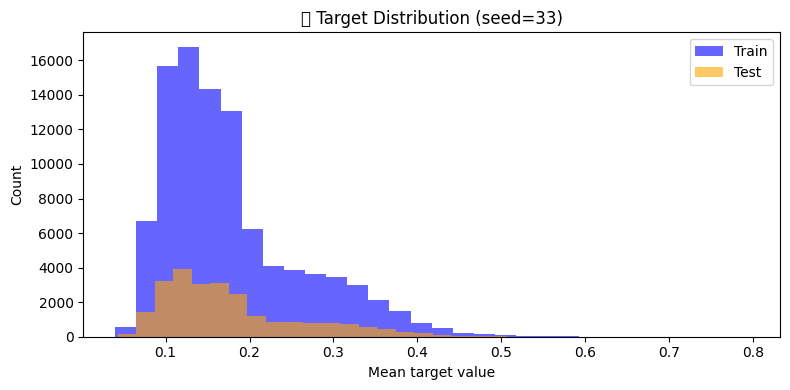

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1021/10000 [00:07<01:03, 141.88it/s]

Epoch [1000/10000], Loss: 0.0042


Epochs:  20%|██        | 2026/10000 [00:14<00:56, 141.52it/s]

Epoch [2000/10000], Loss: 0.0030


Epochs:  30%|███       | 3016/10000 [00:21<00:49, 141.70it/s]

Epoch [3000/10000], Loss: 0.0023


Epochs:  40%|████      | 4021/10000 [00:28<00:42, 141.56it/s]

Epoch [4000/10000], Loss: 0.0018


Epochs:  47%|████▋     | 4660/10000 [00:32<00:37, 141.53it/s]


⏹️ Early stopping at epoch 4661

📊 Metrics:
{'MSE': 0.0017739047, 'MAE': 0.029035127, 'R2': 0.746899200955656}

🔁 Run 35 / 50 (seed = 34)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


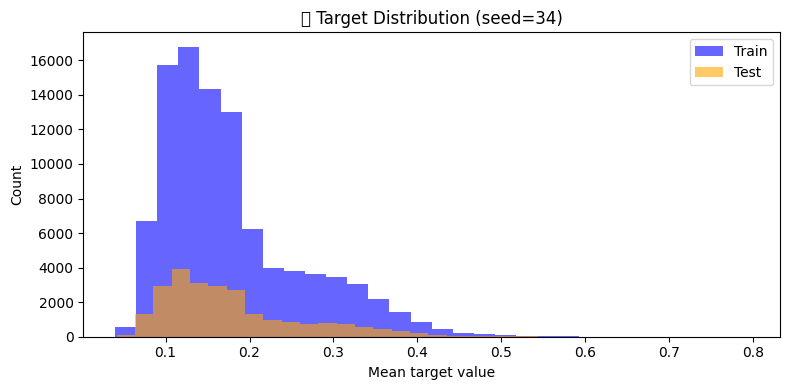

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1022/10000 [00:07<01:03, 141.32it/s]

Epoch [1000/10000], Loss: 0.0039


Epochs:  20%|██        | 2027/10000 [00:14<00:56, 141.02it/s]

Epoch [2000/10000], Loss: 0.0029


Epochs:  29%|██▉       | 2920/10000 [00:20<00:50, 141.20it/s]


⏹️ Early stopping at epoch 2921

📊 Metrics:
{'MSE': 0.0026788833, 'MAE': 0.036023695, 'R2': 0.6130963395388269}

🔁 Run 36 / 50 (seed = 35)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


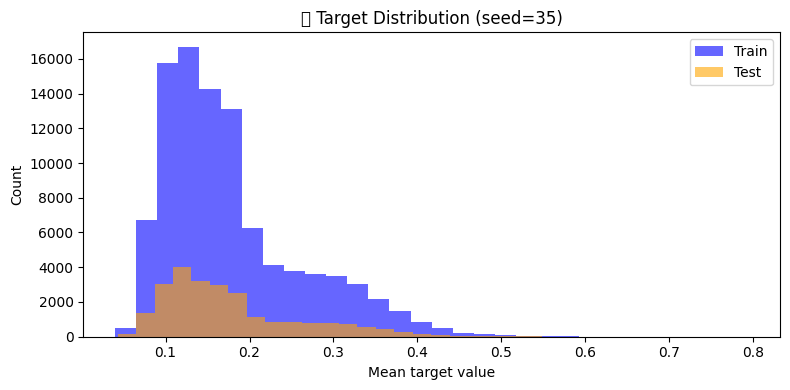

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1022/10000 [00:07<01:03, 141.39it/s]

Epoch [1000/10000], Loss: 0.0044


Epochs:  20%|██        | 2027/10000 [00:14<00:56, 140.81it/s]

Epoch [2000/10000], Loss: 0.0034


Epochs:  30%|███       | 3015/10000 [00:21<00:49, 141.10it/s]

Epoch [3000/10000], Loss: 0.0031


Epochs:  40%|████      | 4020/10000 [00:28<00:42, 141.06it/s]

Epoch [4000/10000], Loss: 0.0020


Epochs:  50%|█████     | 5025/10000 [00:35<00:35, 140.80it/s]

Epoch [5000/10000], Loss: 0.0022


Epochs:  60%|██████    | 6015/10000 [00:42<00:28, 140.80it/s]

Epoch [6000/10000], Loss: 0.0013


Epochs:  70%|███████   | 7019/10000 [00:49<00:21, 141.10it/s]

Epoch [7000/10000], Loss: 0.0051


Epochs:  71%|███████   | 7082/10000 [00:50<00:20, 141.06it/s]


⏹️ Early stopping at epoch 7083

📊 Metrics:
{'MSE': 0.001174406, 'MAE': 0.023956053, 'R2': 0.8318709505628015}

🔁 Run 37 / 50 (seed = 36)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


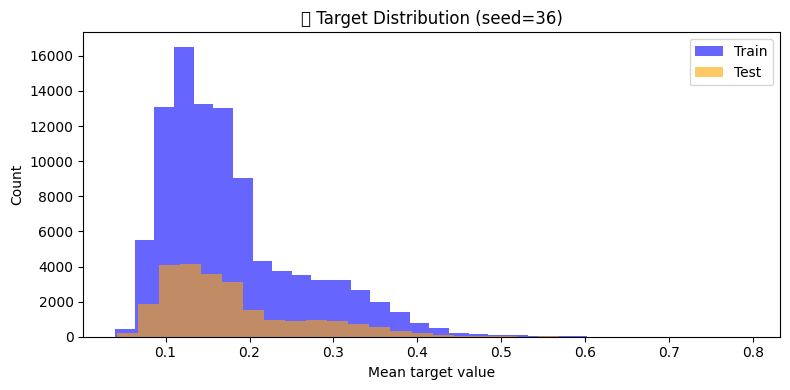

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1022/10000 [00:07<01:03, 141.73it/s]

Epoch [1000/10000], Loss: 0.0042


Epochs:  20%|██        | 2027/10000 [00:14<00:56, 141.79it/s]

Epoch [2000/10000], Loss: 0.0027


Epochs:  30%|███       | 3017/10000 [00:21<00:48, 142.51it/s]

Epoch [3000/10000], Loss: 0.0026


Epochs:  40%|████      | 4022/10000 [00:28<00:42, 141.93it/s]

Epoch [4000/10000], Loss: 0.0021


Epochs:  50%|█████     | 5027/10000 [00:35<00:35, 140.98it/s]

Epoch [5000/10000], Loss: 0.0018


Epochs:  60%|██████    | 6017/10000 [00:42<00:28, 141.76it/s]

Epoch [6000/10000], Loss: 0.0015


Epochs:  68%|██████▊   | 6822/10000 [00:48<00:22, 141.75it/s]


⏹️ Early stopping at epoch 6823

📊 Metrics:
{'MSE': 0.0014730477, 'MAE': 0.027664183, 'R2': 0.786993073279763}

🔁 Run 38 / 50 (seed = 37)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


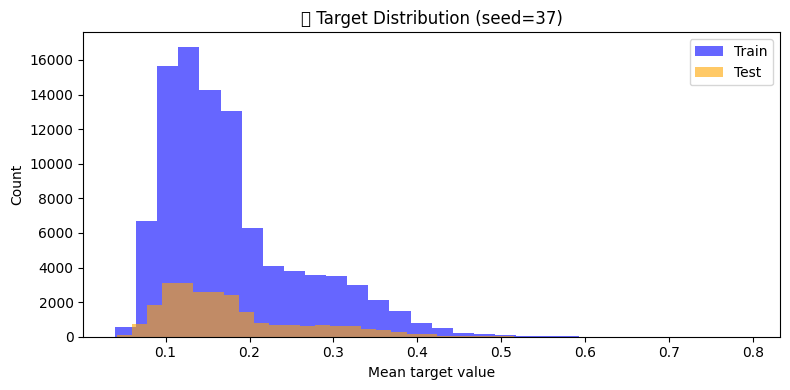

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1022/10000 [00:07<01:03, 141.93it/s]

Epoch [1000/10000], Loss: 0.0048


Epochs:  20%|██        | 2023/10000 [00:14<00:56, 141.93it/s]


Epoch [2000/10000], Loss: 0.0039
⏹️ Early stopping at epoch 2024

📊 Metrics:
{'MSE': 0.0038635076, 'MAE': 0.045455568, 'R2': 0.4433512667236704}

🔁 Run 39 / 50 (seed = 38)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


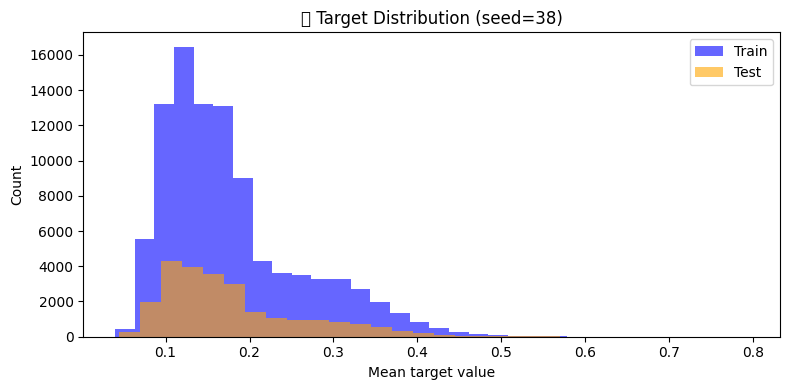

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1022/10000 [00:07<01:03, 140.91it/s]

Epoch [1000/10000], Loss: 0.0041


Epochs:  20%|██        | 2027/10000 [00:14<00:56, 141.08it/s]

Epoch [2000/10000], Loss: 0.0030


Epochs:  30%|███       | 3017/10000 [00:21<00:49, 141.22it/s]

Epoch [3000/10000], Loss: 0.0021


Epochs:  40%|████      | 4022/10000 [00:28<00:42, 141.16it/s]

Epoch [4000/10000], Loss: 0.0016


Epochs:  49%|████▉     | 4922/10000 [00:34<00:36, 141.03it/s]


⏹️ Early stopping at epoch 4923

📊 Metrics:
{'MSE': 0.0016961212, 'MAE': 0.02841604, 'R2': 0.7561098185191777}

🔁 Run 40 / 50 (seed = 39)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


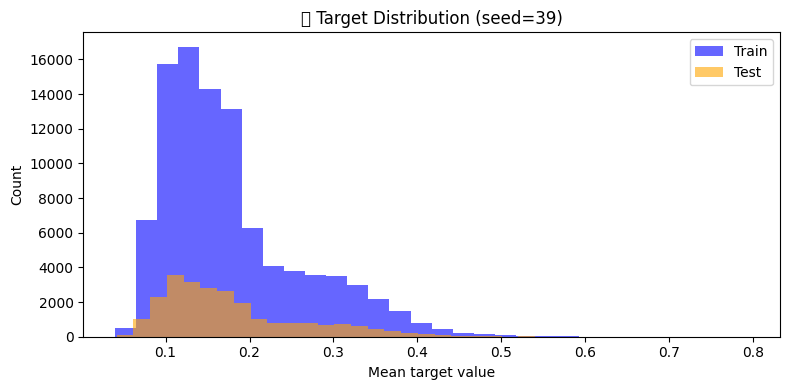

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1022/10000 [00:07<01:03, 141.32it/s]

Epoch [1000/10000], Loss: 0.0046


Epochs:  20%|██        | 2027/10000 [00:14<00:56, 141.81it/s]

Epoch [2000/10000], Loss: 0.0035


Epochs:  30%|███       | 3017/10000 [00:21<00:49, 141.38it/s]

Epoch [3000/10000], Loss: 0.0041


Epochs:  40%|████      | 4022/10000 [00:28<00:42, 141.26it/s]

Epoch [4000/10000], Loss: 0.0020


Epochs:  50%|█████     | 5027/10000 [00:35<00:35, 141.52it/s]

Epoch [5000/10000], Loss: 0.0017


Epochs:  52%|█████▏    | 5233/10000 [00:36<00:33, 141.66it/s]


⏹️ Early stopping at epoch 5234

📊 Metrics:
{'MSE': 0.002880864, 'MAE': 0.038073204, 'R2': 0.5912068763442151}

🔁 Run 41 / 50 (seed = 40)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


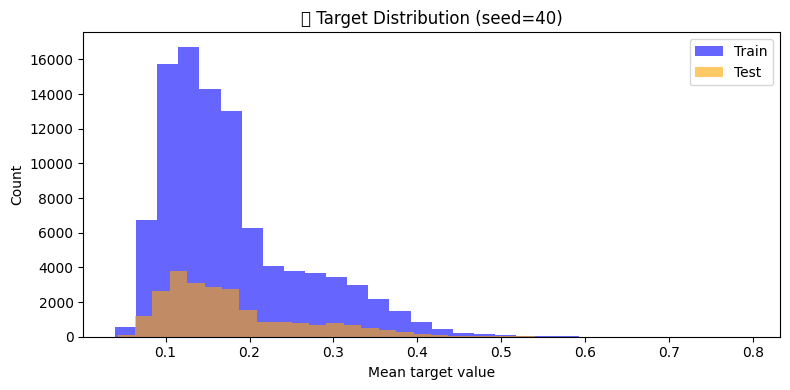

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1022/10000 [00:07<01:03, 141.50it/s]

Epoch [1000/10000], Loss: 0.0039


Epochs:  20%|██        | 2027/10000 [00:14<00:56, 141.74it/s]

Epoch [2000/10000], Loss: 0.0031


Epochs:  30%|███       | 3017/10000 [00:21<00:49, 141.49it/s]

Epoch [3000/10000], Loss: 0.0022


Epochs:  40%|████      | 4022/10000 [00:28<00:42, 141.04it/s]

Epoch [4000/10000], Loss: 0.0020


Epochs:  50%|█████     | 5027/10000 [00:35<00:35, 141.66it/s]

Epoch [5000/10000], Loss: 0.0016


Epochs:  56%|█████▋    | 5634/10000 [00:39<00:30, 141.67it/s]


⏹️ Early stopping at epoch 5635

📊 Metrics:
{'MSE': 0.0019300065, 'MAE': 0.030730618, 'R2': 0.7208443787357522}

🔁 Run 42 / 50 (seed = 41)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


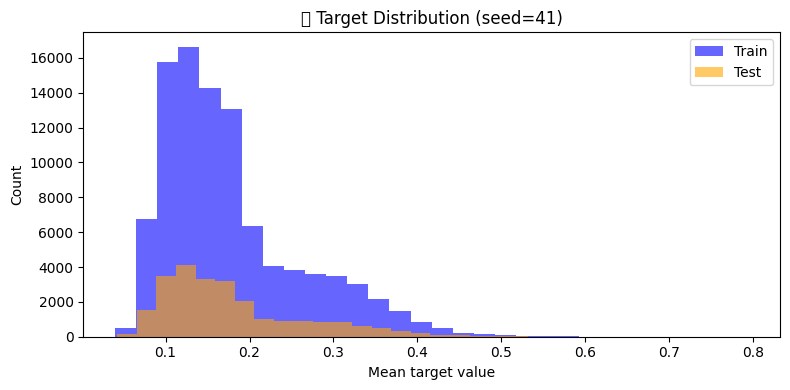

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1022/10000 [00:07<01:03, 141.81it/s]

Epoch [1000/10000], Loss: 0.0039


Epochs:  20%|██        | 2027/10000 [00:14<00:56, 141.55it/s]

Epoch [2000/10000], Loss: 0.0031


Epochs:  30%|███       | 3017/10000 [00:21<00:49, 141.82it/s]

Epoch [3000/10000], Loss: 0.0025


Epochs:  40%|████      | 4022/10000 [00:28<00:42, 141.72it/s]

Epoch [4000/10000], Loss: 0.0021


Epochs:  50%|█████     | 5027/10000 [00:35<00:35, 141.34it/s]

Epoch [5000/10000], Loss: 0.0017


Epochs:  57%|█████▋    | 5676/10000 [00:40<00:30, 141.57it/s]


⏹️ Early stopping at epoch 5677

📊 Metrics:
{'MSE': 0.0016713823, 'MAE': 0.028443597, 'R2': 0.7602965736035338}

🔁 Run 43 / 50 (seed = 42)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


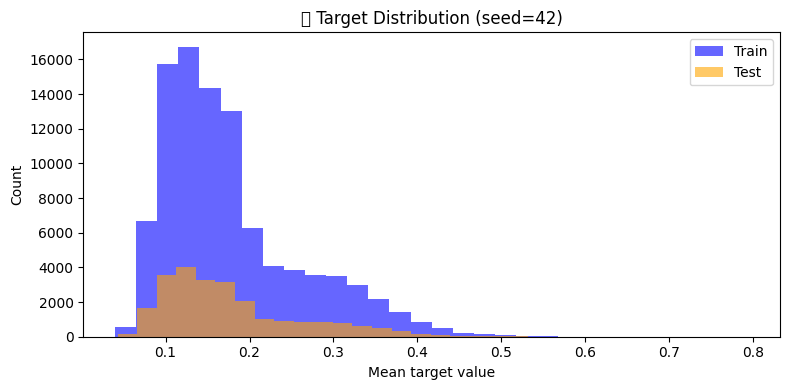

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1022/10000 [00:07<01:03, 141.67it/s]

Epoch [1000/10000], Loss: 0.0034


Epochs:  20%|██        | 2027/10000 [00:14<00:56, 141.43it/s]

Epoch [2000/10000], Loss: 0.0027


Epochs:  30%|███       | 3017/10000 [00:21<00:49, 141.13it/s]

Epoch [3000/10000], Loss: 0.0023


Epochs:  40%|████      | 4022/10000 [00:28<00:42, 140.94it/s]

Epoch [4000/10000], Loss: 0.0020


Epochs:  50%|█████     | 5027/10000 [00:35<00:35, 141.48it/s]

Epoch [5000/10000], Loss: 0.0019


Epochs:  57%|█████▋    | 5690/10000 [00:40<00:30, 141.47it/s]


⏹️ Early stopping at epoch 5691

📊 Metrics:
{'MSE': 0.0015073442, 'MAE': 0.027378265, 'R2': 0.783930491875256}

🔁 Run 44 / 50 (seed = 43)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


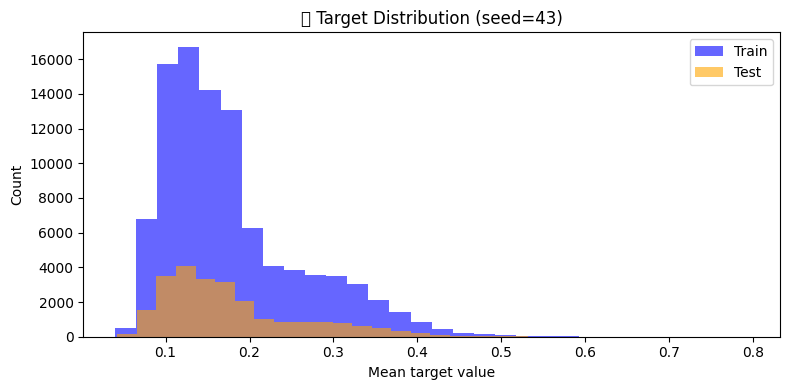

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1022/10000 [00:07<01:03, 142.00it/s]

Epoch [1000/10000], Loss: 0.0042


Epochs:  19%|█▉        | 1905/10000 [00:13<00:57, 141.62it/s]


⏹️ Early stopping at epoch 1906

📊 Metrics:
{'MSE': 0.0032688512, 'MAE': 0.042101033, 'R2': 0.5298072507619946}

🔁 Run 45 / 50 (seed = 44)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


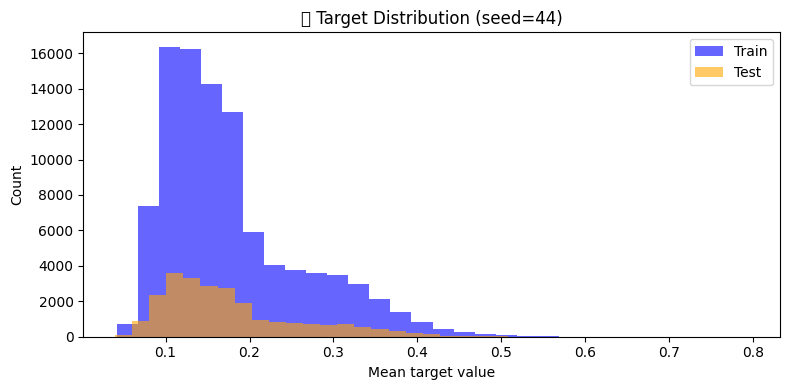

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1022/10000 [00:07<01:03, 141.54it/s]

Epoch [1000/10000], Loss: 0.0043


Epochs:  20%|██        | 2027/10000 [00:14<00:56, 141.63it/s]

Epoch [2000/10000], Loss: 0.0028


Epochs:  30%|███       | 3017/10000 [00:21<00:49, 141.28it/s]

Epoch [3000/10000], Loss: 0.0022


Epochs:  40%|████      | 4022/10000 [00:28<00:42, 141.35it/s]

Epoch [4000/10000], Loss: 0.0022


Epochs:  50%|█████     | 5027/10000 [00:35<00:35, 140.92it/s]

Epoch [5000/10000], Loss: 0.0017


Epochs:  60%|██████    | 6017/10000 [00:42<00:28, 141.16it/s]

Epoch [6000/10000], Loss: 0.0016


Epochs:  67%|██████▋   | 6708/10000 [00:47<00:23, 141.35it/s]


⏹️ Early stopping at epoch 6709

📊 Metrics:
{'MSE': 0.0013945524, 'MAE': 0.025979977, 'R2': 0.7970288482797401}

🔁 Run 46 / 50 (seed = 45)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


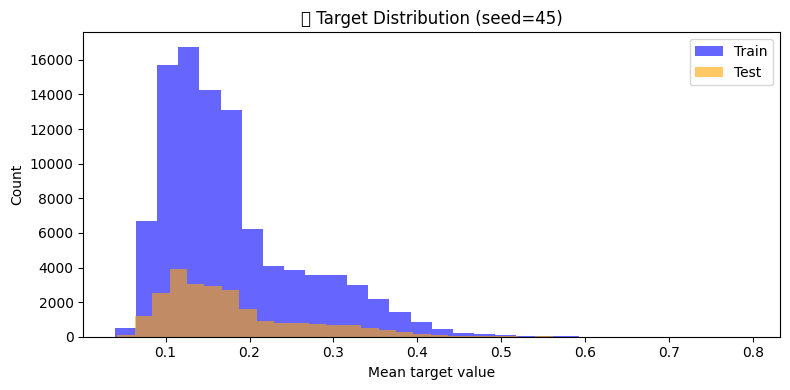

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1022/10000 [00:07<01:03, 141.64it/s]

Epoch [1000/10000], Loss: 0.0047


Epochs:  20%|██        | 2027/10000 [00:14<00:56, 141.90it/s]

Epoch [2000/10000], Loss: 0.0038


Epochs:  30%|███       | 3017/10000 [00:21<00:49, 142.09it/s]

Epoch [3000/10000], Loss: 0.0029


Epochs:  40%|████      | 4022/10000 [00:28<00:42, 141.38it/s]

Epoch [4000/10000], Loss: 0.0029


Epochs:  50%|█████     | 5027/10000 [00:35<00:35, 141.50it/s]

Epoch [5000/10000], Loss: 0.0022


Epochs:  60%|██████    | 6017/10000 [00:42<00:28, 141.23it/s]

Epoch [6000/10000], Loss: 0.0016


Epochs:  65%|██████▌   | 6510/10000 [00:46<00:24, 141.52it/s]


⏹️ Early stopping at epoch 6511

📊 Metrics:
{'MSE': 0.0016361481, 'MAE': 0.029271077, 'R2': 0.7643621854283692}

🔁 Run 47 / 50 (seed = 46)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


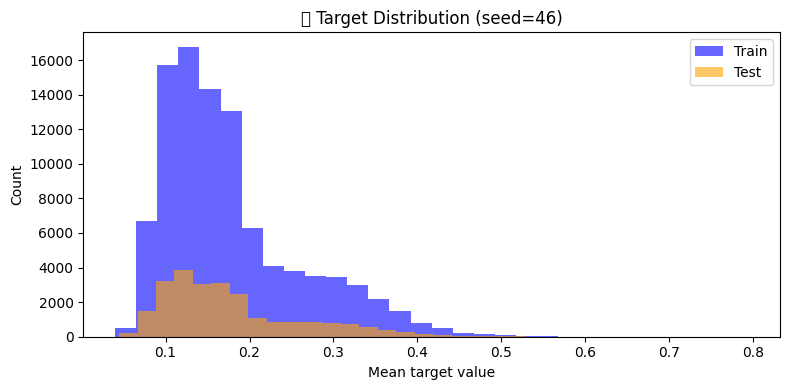

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1022/10000 [00:07<01:03, 141.33it/s]

Epoch [1000/10000], Loss: 0.0047


Epochs:  19%|█▉        | 1931/10000 [00:13<00:57, 141.49it/s]


⏹️ Early stopping at epoch 1932

📊 Metrics:
{'MSE': 0.003468012, 'MAE': 0.043337066, 'R2': 0.502956032384436}

🔁 Run 48 / 50 (seed = 47)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


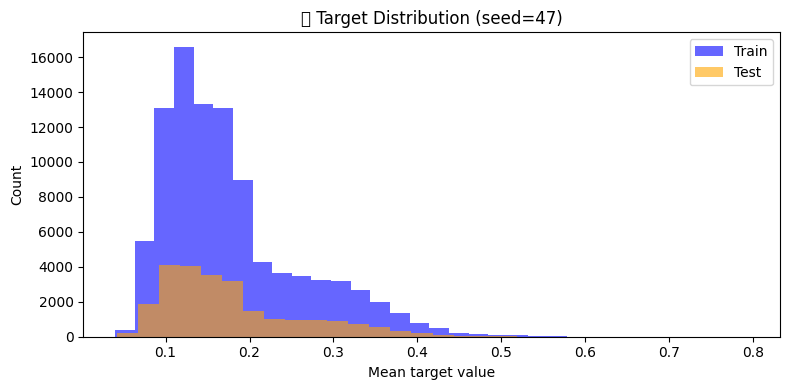

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1022/10000 [00:07<01:03, 141.06it/s]

Epoch [1000/10000], Loss: 0.0037


Epochs:  20%|██        | 2027/10000 [00:14<00:56, 141.48it/s]

Epoch [2000/10000], Loss: 0.0027


Epochs:  30%|███       | 3017/10000 [00:21<00:49, 141.26it/s]

Epoch [3000/10000], Loss: 0.0020


Epochs:  37%|███▋      | 3726/10000 [00:26<00:44, 141.37it/s]


⏹️ Early stopping at epoch 3727

📊 Metrics:
{'MSE': 0.0017483643, 'MAE': 0.02963665, 'R2': 0.7437887847813127}

🔁 Run 49 / 50 (seed = 48)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


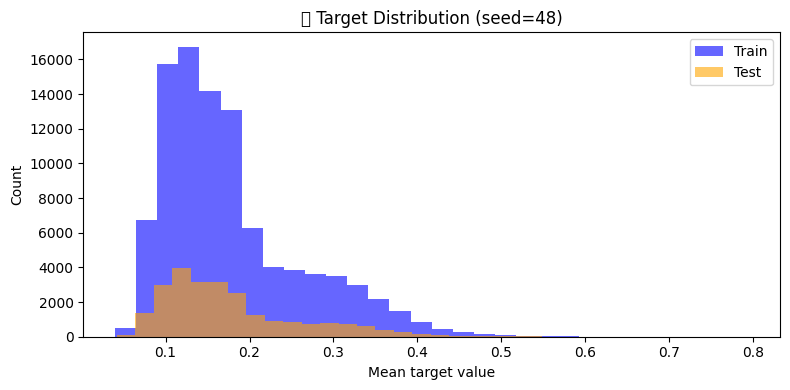

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1022/10000 [00:07<01:03, 141.73it/s]

Epoch [1000/10000], Loss: 0.0043


Epochs:  20%|██        | 2027/10000 [00:14<00:56, 141.80it/s]

Epoch [2000/10000], Loss: 0.0034


Epochs:  30%|███       | 3017/10000 [00:21<00:49, 141.11it/s]

Epoch [3000/10000], Loss: 0.0032


Epochs:  40%|████      | 4022/10000 [00:28<00:42, 140.99it/s]

Epoch [4000/10000], Loss: 0.0021


Epochs:  50%|█████     | 5027/10000 [00:35<00:35, 141.20it/s]

Epoch [5000/10000], Loss: 0.0016


Epochs:  60%|██████    | 6017/10000 [00:42<00:28, 140.76it/s]

Epoch [6000/10000], Loss: 0.0017


Epochs:  63%|██████▎   | 6253/10000 [00:44<00:26, 141.30it/s]


⏹️ Early stopping at epoch 6254

📊 Metrics:
{'MSE': 0.0014767338, 'MAE': 0.026708037, 'R2': 0.7847560829998848}

🔁 Run 50 / 50 (seed = 49)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


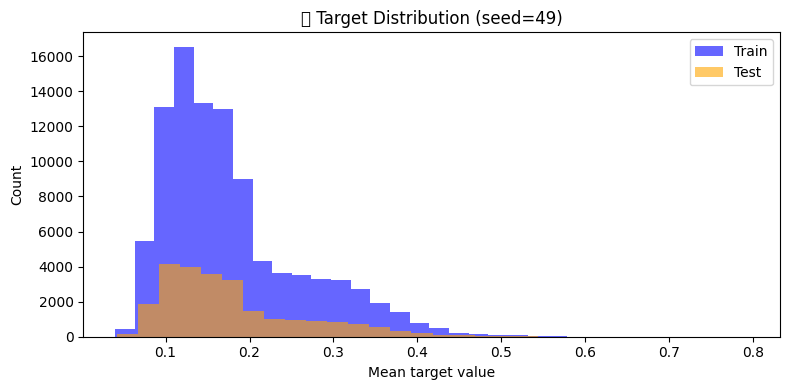

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1022/10000 [00:07<01:03, 141.68it/s]

Epoch [1000/10000], Loss: 0.0045


Epochs:  20%|██        | 2027/10000 [00:14<00:56, 141.54it/s]

Epoch [2000/10000], Loss: 0.0025


Epochs:  30%|███       | 3017/10000 [00:21<00:49, 141.71it/s]

Epoch [3000/10000], Loss: 0.0024


Epochs:  40%|████      | 4022/10000 [00:28<00:42, 141.19it/s]

Epoch [4000/10000], Loss: 0.0025


Epochs:  50%|█████     | 5027/10000 [00:35<00:35, 141.39it/s]

Epoch [5000/10000], Loss: 0.0020


Epochs:  60%|██████    | 6017/10000 [00:42<00:28, 141.36it/s]

Epoch [6000/10000], Loss: 0.0016


Epochs:  67%|██████▋   | 6695/10000 [00:47<00:23, 141.41it/s]

⏹️ Early stopping at epoch 6696

📊 Metrics:
{'MSE': 0.001219787, 'MAE': 0.024054792, 'R2': 0.8238486395710998}
📁 Best weights saved to: /kaggle/working/config_mlp_128h_6e-03lr/best_model_weights_mlp_128h_6e-03lr_16bs_10000ep_Tanh_Adam.pt
🏆 Best run: run_seed_6 with R2 = 0.8486
   R2   = 0.8486
   MAE  = 0.0238
   MSE  = 0.001043


In [12]:
# 📁 src/tuning/run_experiments.py
# ➤ Run MLP training multiple times with different random seeds to assess stability
# ➤ Track and save best model based on R² score
# ➤ Store metrics for each run, save best weights and evaluation report


# 🧠 Prepare model
# 📌 Fixed parameters
EPOCHS = 10000
OUTPUT_DIM = 1
N_RUNS = 50  # Total number of runs

# 📊 Containers to collect results
results_all = []
results_header = ["run", "run_id", "R2", "MAE", "MSE"]
best_r2 = -float("inf")
best_model = None
best_metrics = None
best_run_id = None
train_loss_history = [] 
weights_registry = {}  # run_id -> weights
weights_registry.clear()


# 🔁 Run the same config with different random seeds
for seed in range(N_RUNS):
    print(f"\n🔁 Run {seed + 1} / {N_RUNS} (seed = {seed})")

    # 🏃 Train model with current seed
    run_id, metrics = train_mlp(
        hidden_dim=config["hidden_dim"],
        lr=config["lr"],
        batch_size=config["batch_size"],
        epochs=EPOCHS,
        output_dim=config["output_dim"],
        activation_fn=config["activation_fn"],
        optimizer_name=config["optimizer_name"],
        seed=seed
    )

    # 📥 Collect result for this run
    results_all.append({
        "run": seed,
        "run_id": run_id,
        "R2": metrics["R2"],
        "MAE": metrics["MAE"],
        "MSE": metrics["MSE"]
    })

    # 🏆 Check if it's the best so far
    if metrics["R2"] > best_r2:
        best_r2 = metrics["R2"]
        best_metrics = metrics
        best_run_id = run_id

# 💾 Ensure save directory exists
os.makedirs(SAVE_ROOT, exist_ok=True)

# 💾 Save full metrics log
results_csv_path = os.path.join(SAVE_ROOT, f"results_{arch_label}.csv")
df_results = pd.DataFrame(results_all, columns=results_header)
df_results.to_csv(results_csv_path, index=False)

# 💾 Save best model weights
best_weights = weights_registry[best_run_id]
weights_save_path = os.path.join(SAVE_ROOT, f"best_model_weights_{arch_label}.pt")
torch.save(best_weights, weights_save_path)
print(f"📁 Best weights saved to: {weights_save_path}")

# 💾 Save best run's metrics
best_metrics = {k: float(v) for k, v in best_metrics.items()}
metrics_json_path = os.path.join(SAVE_ROOT, f"metrics_best_{arch_label}.json")
with open(metrics_json_path, "w") as f:
    json.dump(best_metrics, f, indent=4)

print(f"🏆 Best run: {best_run_id} with R2 = {best_r2:.4f}")
print(f"   R2   = {best_metrics['R2']:.4f}")
print(f"   MAE  = {best_metrics['MAE']:.4f}")
print(f"   MSE  = {best_metrics['MSE']:.6f}")


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


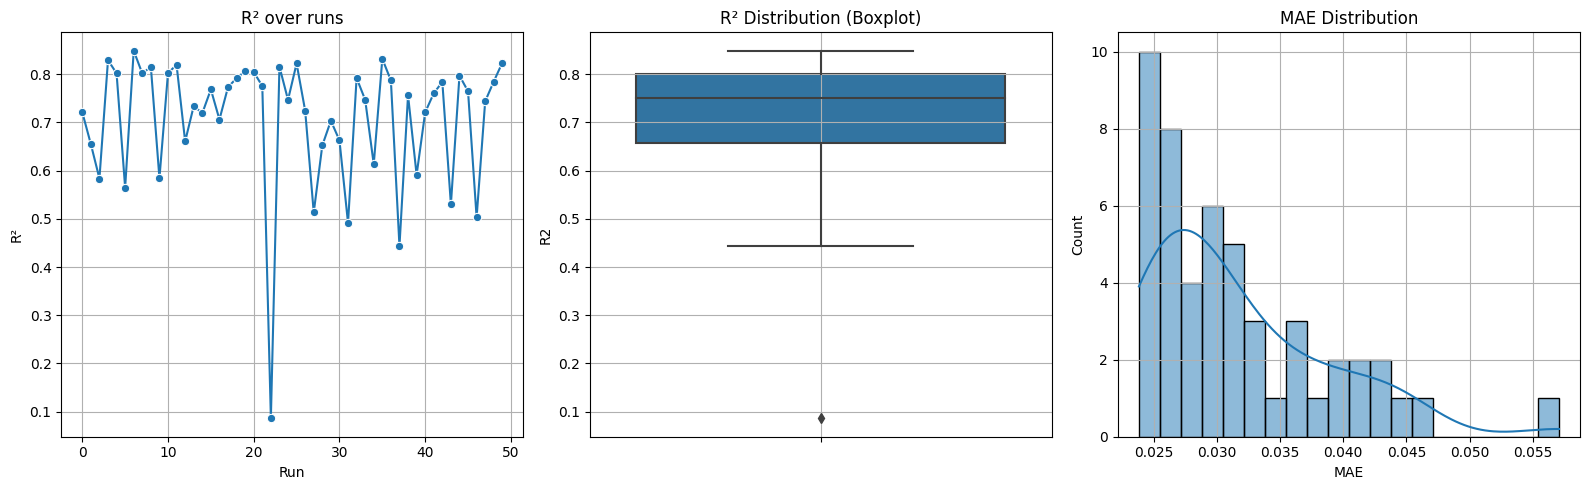

📈 Stability analysis complete:
{
    "R2_mean": 0.7071,
    "R2_std": 0.1372,
    "MAE_mean": 0.0316,
    "MAE_std": 0.0072,
    "MSE_mean": 0.002034,
    "MSE_std": 0.000954,
    "runs": 50
}
📁 Saved metrics: /kaggle/working/config_mlp_128h_6e-03lr/stability_mlp_128h_6e-03lr_16bs_10000ep_Tanh_Adam.json
🖼️  Saved plot: /kaggle/working/config_mlp_128h_6e-03lr/stability_plot_mlp_128h_6e-03lr_16bs_10000ep_Tanh_Adam.png


In [13]:
# 📁 src/tuning/analyze_stability.py
# ➤ Analyze stability of model performance across multiple seeds
# ➤ Compute mean and std for R², MAE, MSE
# ➤ Generate and save visualizations (line plot, boxplot, histogram)
# ➤ Save stability metrics to JSON for reporting and comparison


# 📥 Load results
df = pd.read_csv(results_csv_path)

# 📊 Compute stability stats
stability = {
    "R2_mean":  round(df["R2"].mean(), 4),
    "R2_std":   round(df["R2"].std(), 4),
    "MAE_mean": round(df["MAE"].mean(), 4),
    "MAE_std":  round(df["MAE"].std(), 4),
    "MSE_mean": round(df["MSE"].mean(), 6),
    "MSE_std":  round(df["MSE"].std(), 6),
    "runs": len(df)
}

# 💾 Save stability metrics
stability_path = os.path.join(SAVE_ROOT, f"stability_{arch_label}.json")
with open(stability_path, "w") as f:
    json.dump(stability, f, indent=4)

# 📈 Visualization
plt.figure(figsize=(16, 5))

# 📌 Plot 1: R² over runs
plt.subplot(1, 3, 1)
sns.lineplot(x="run", y="R2", data=df, marker="o", linewidth=1.5)
plt.title("R² over runs")
plt.xlabel("Run")
plt.ylabel("R²")
plt.grid(True)

# 📌 Plot 2: Boxplot of R²
plt.subplot(1, 3, 2)
sns.boxplot(y="R2", data=df)
plt.title("R² Distribution (Boxplot)")
plt.grid(True)

# 📌 Plot 3: Histogram of MAE
plt.subplot(1, 3, 3)
sns.histplot(df["MAE"], bins=20, kde=True)
plt.title("MAE Distribution")
plt.xlabel("MAE")
plt.grid(True)

# 💾 Save the plot
fig_path = os.path.join(SAVE_ROOT, f"stability_plot_{arch_label}.png")
plt.tight_layout()
plt.savefig(fig_path)
plt.show()

# ✅ Output
print("📈 Stability analysis complete:")
print(json.dumps(stability, indent=4))
print(f"📁 Saved metrics: {stability_path}")
print(f"🖼️  Saved plot: {fig_path}")


Third model configuration
config_mlp_64h_8e-03lr

In [14]:
# 📁 src/tuning/setup_paths.py
# ➤ Paths for hyperparameter search: tuning runs, logs, results

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

DATA_PATH = "/kaggle/input/windloading-train/WindLoading_Train.csv"
SAVE_ROOT = "/kaggle/working/config_mlp_64h_8e-03lr"
config_path = '/kaggle/input/wind-fluctuation-prediction-final-model/config_mlp_64h_8e-03lr_ex.json'

# DATA_PATH = "/mnt/d/projects/wind_fluctuation_prediction_2025/data/processed/windloading_train.csv"
# SAVE_ROOT = "/mnt/d/projects/wind_fluctuation_prediction_2025/final_models/config_001"

In [15]:
# 📁 src/tuning/load_config.py
# ➤ Load best configuration from saved JSON, convert activation string to function,
# ➤ build readable architecture label for logging and saving results

# 🔁 Mapping string from config.json to actual PyTorch activation function
activation_map = {
    "ReLU": torch.nn.ReLU,
    "Tanh": torch.nn.Tanh,
    "LeakyReLU": torch.nn.LeakyReLU
}

# 📦 Load and decode configuration
with open(config_path, "r") as f:
    config = json.load(f)

# 🔧 Convert activation function string to callable object
config["activation_fn"] = activation_map[config["activation_fn"]]

# 🏷 Extract config name from path
# config_name = os.path.basename(os.path.dirname(config_path))  # → 'config_001'
# 🏷 Get config filename (without extension) to use as config_name
config_filename = os.path.basename(config_path)
config_name = os.path.splitext(config_filename)[0]

# 🧠 Build architecture label
arch_label = (
    f"mlp_{config['hidden_dim']}h_"
    f"{config['lr']:.0e}lr_"
    f"{config['batch_size']}bs_"
    f"{config['epochs']}ep_"
    f"{config['activation_fn'].__name__}_"
    f"{config['optimizer_name']}"
)

print("✅ Loaded config:")
print(config)
print(f"📂 SAVE_ROOT: {SAVE_ROOT}")
print(f"📁 arch_label: {arch_label}")

✅ Loaded config:
{'input_dim': 5, 'hidden_dim': 64, 'output_dim': 1, 'lr': 0.008, 'epochs': 10000, 'batch_size': 16, 'activation_fn': <class 'torch.nn.modules.activation.Tanh'>, 'optimizer_name': 'Adam', 'features': ['X_int', 'Y_int', 'X_fac', 'Y_fac', 'Ang'], 'targets': ['StdDev']}
📂 SAVE_ROOT: /kaggle/working/config_mlp_64h_8e-03lr
📁 arch_label: mlp_64h_8e-03lr_16bs_10000ep_Tanh_Adam



🔁 Run 1 / 50 (seed = 0)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


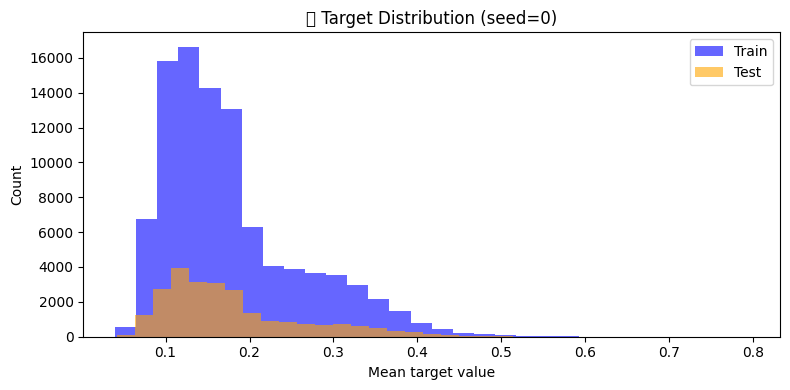

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1049/10000 [00:04<00:34, 257.62it/s]

Epoch [1000/10000], Loss: 0.0038


Epochs:  20%|██        | 2037/10000 [00:07<00:31, 255.37it/s]

Epoch [2000/10000], Loss: 0.0029


Epochs:  30%|███       | 3025/10000 [00:11<00:27, 253.82it/s]

Epoch [3000/10000], Loss: 0.0019


Epochs:  40%|████      | 4039/10000 [00:15<00:23, 252.91it/s]

Epoch [4000/10000], Loss: 0.0029


Epochs:  50%|█████     | 5027/10000 [00:19<00:19, 252.82it/s]

Epoch [5000/10000], Loss: 0.0020


Epochs:  57%|█████▋    | 5705/10000 [00:22<00:16, 253.70it/s]


⏹️ Early stopping at epoch 5706

📊 Metrics:
{'MSE': 0.0014054398, 'MAE': 0.027372783, 'R2': 0.7969043091428608}

🔁 Run 2 / 50 (seed = 1)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


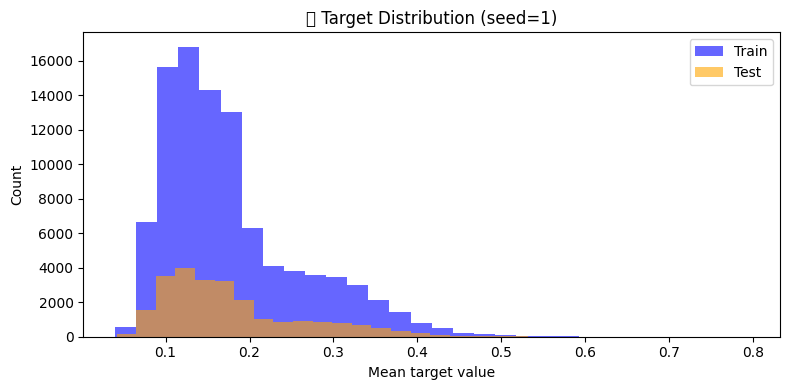

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1042/10000 [00:04<00:35, 251.33it/s]

Epoch [1000/10000], Loss: 0.0042


Epochs:  20%|██        | 2049/10000 [00:08<00:31, 248.60it/s]

Epoch [2000/10000], Loss: 0.0031


Epochs:  30%|███       | 3035/10000 [00:12<00:27, 251.61it/s]

Epoch [3000/10000], Loss: 0.0024


Epochs:  40%|████      | 4049/10000 [00:16<00:23, 252.54it/s]

Epoch [4000/10000], Loss: 0.0019


Epochs:  50%|█████     | 5037/10000 [00:20<00:19, 253.11it/s]

Epoch [5000/10000], Loss: 0.0017


Epochs:  60%|██████    | 6025/10000 [00:23<00:15, 253.26it/s]

Epoch [6000/10000], Loss: 0.0018


Epochs:  62%|██████▏   | 6209/10000 [00:24<00:15, 251.86it/s]


⏹️ Early stopping at epoch 6210

📊 Metrics:
{'MSE': 0.0017593369, 'MAE': 0.027997103, 'R2': 0.7473470895334706}

🔁 Run 3 / 50 (seed = 2)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


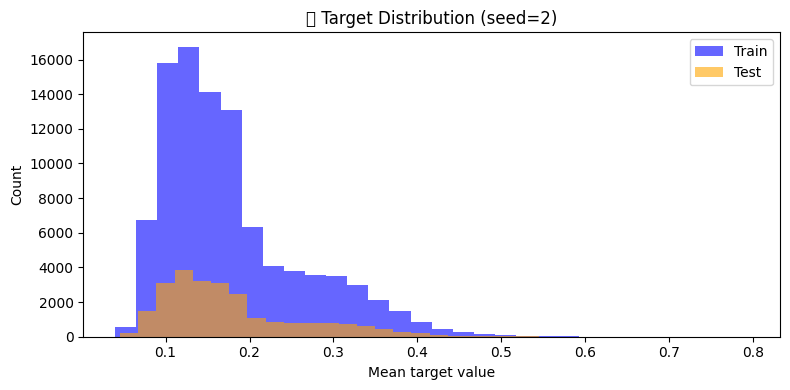

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1040/10000 [00:04<00:35, 255.83it/s]

Epoch [1000/10000], Loss: 0.0040


Epochs:  20%|██        | 2028/10000 [00:07<00:31, 255.64it/s]

Epoch [2000/10000], Loss: 0.0028


Epochs:  30%|███       | 3042/10000 [00:11<00:27, 255.79it/s]

Epoch [3000/10000], Loss: 0.0019


Epochs:  40%|████      | 4030/10000 [00:15<00:23, 255.89it/s]

Epoch [4000/10000], Loss: 0.0018


Epochs:  50%|█████     | 5044/10000 [00:19<00:19, 255.83it/s]

Epoch [5000/10000], Loss: 0.0014


Epochs:  56%|█████▌    | 5598/10000 [00:21<00:17, 255.48it/s]


⏹️ Early stopping at epoch 5599

📊 Metrics:
{'MSE': 0.0013659041, 'MAE': 0.026629012, 'R2': 0.8038869376694703}

🔁 Run 4 / 50 (seed = 3)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


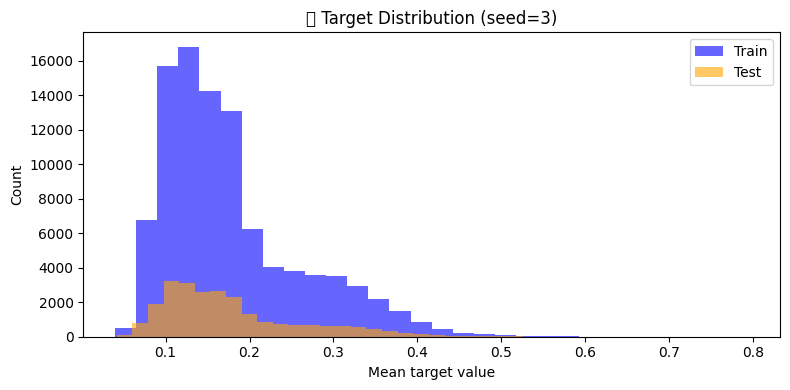

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1043/10000 [00:04<00:34, 256.65it/s]

Epoch [1000/10000], Loss: 0.0039


Epochs:  20%|██        | 2031/10000 [00:07<00:31, 256.69it/s]

Epoch [2000/10000], Loss: 0.0038


Epochs:  26%|██▋       | 2625/10000 [00:10<00:28, 255.99it/s]


⏹️ Early stopping at epoch 2626

📊 Metrics:
{'MSE': 0.002859381, 'MAE': 0.0385339, 'R2': 0.5831481667654355}

🔁 Run 5 / 50 (seed = 4)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


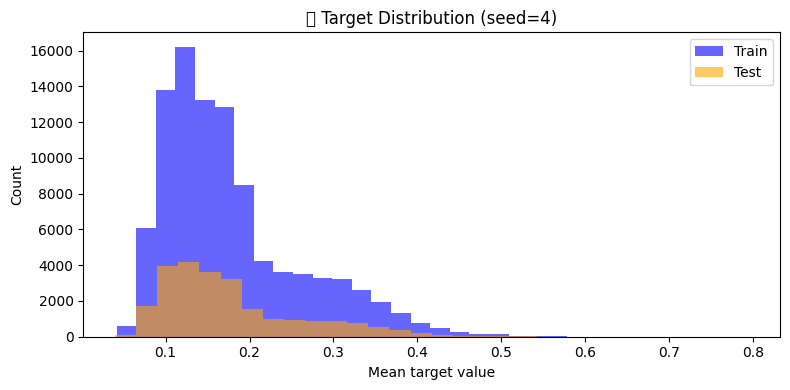

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1042/10000 [00:04<00:34, 257.32it/s]

Epoch [1000/10000], Loss: 0.0040


Epochs:  20%|██        | 2030/10000 [00:07<00:31, 256.31it/s]

Epoch [2000/10000], Loss: 0.0033


Epochs:  30%|███       | 3044/10000 [00:11<00:27, 255.48it/s]

Epoch [3000/10000], Loss: 0.0018


Epochs:  40%|████      | 4032/10000 [00:15<00:23, 256.04it/s]

Epoch [4000/10000], Loss: 0.0019


Epochs:  50%|█████     | 5046/10000 [00:19<00:19, 255.75it/s]

Epoch [5000/10000], Loss: 0.0015


Epochs:  54%|█████▍    | 5405/10000 [00:21<00:17, 256.07it/s]


⏹️ Early stopping at epoch 5406

📊 Metrics:
{'MSE': 0.0014088309, 'MAE': 0.026482595, 'R2': 0.7955152884989343}

🔁 Run 6 / 50 (seed = 5)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


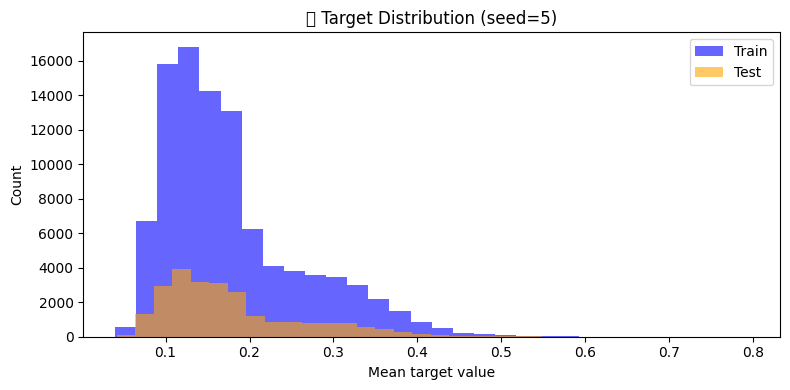

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1043/10000 [00:04<00:34, 257.12it/s]

Epoch [1000/10000], Loss: 0.0041


Epochs:  20%|██        | 2031/10000 [00:07<00:31, 254.47it/s]

Epoch [2000/10000], Loss: 0.0024


Epochs:  30%|███       | 3045/10000 [00:11<00:27, 255.67it/s]

Epoch [3000/10000], Loss: 0.0016


Epochs:  40%|████      | 4033/10000 [00:15<00:23, 255.55it/s]

Epoch [4000/10000], Loss: 0.0015


Epochs:  42%|████▏     | 4216/10000 [00:16<00:22, 255.36it/s]


⏹️ Early stopping at epoch 4217

📊 Metrics:
{'MSE': 0.0015029843, 'MAE': 0.027080601, 'R2': 0.7847590294900739}

🔁 Run 7 / 50 (seed = 6)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


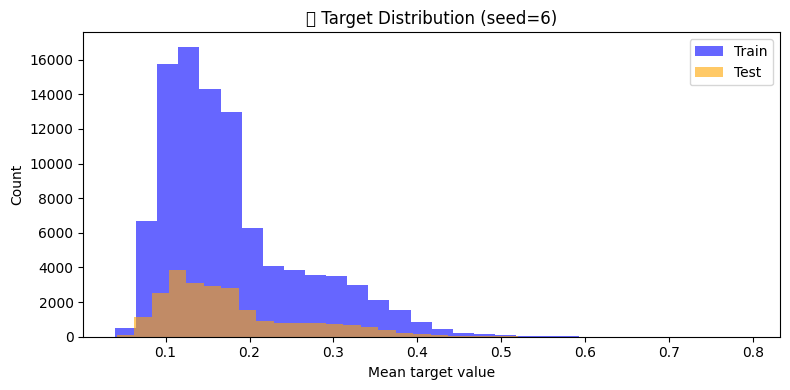

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1042/10000 [00:04<00:35, 254.35it/s]

Epoch [1000/10000], Loss: 0.0041


Epochs:  20%|██        | 2030/10000 [00:07<00:31, 255.07it/s]

Epoch [2000/10000], Loss: 0.0033


Epochs:  30%|███       | 3044/10000 [00:11<00:27, 254.79it/s]

Epoch [3000/10000], Loss: 0.0019


Epochs:  40%|████      | 4032/10000 [00:15<00:23, 254.68it/s]

Epoch [4000/10000], Loss: 0.0016


Epochs:  43%|████▎     | 4284/10000 [00:16<00:22, 254.70it/s]


⏹️ Early stopping at epoch 4285

📊 Metrics:
{'MSE': 0.0016533416, 'MAE': 0.02871366, 'R2': 0.7600818581215887}

🔁 Run 8 / 50 (seed = 7)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


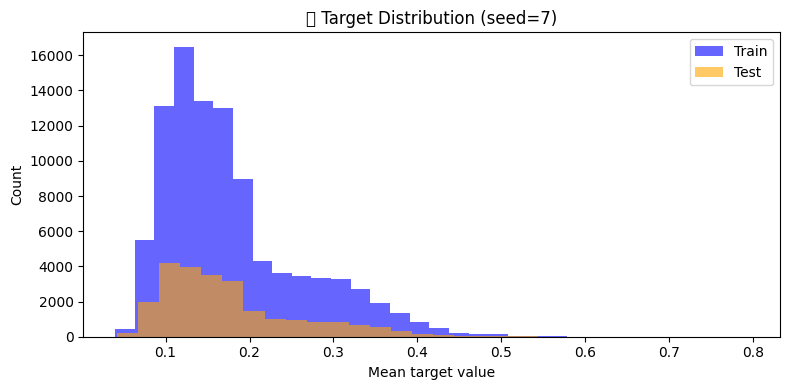

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1042/10000 [00:04<00:35, 254.53it/s]

Epoch [1000/10000], Loss: 0.0033


Epochs:  20%|██        | 2030/10000 [00:07<00:31, 255.80it/s]

Epoch [2000/10000], Loss: 0.0028


Epochs:  30%|███       | 3044/10000 [00:11<00:27, 255.69it/s]

Epoch [3000/10000], Loss: 0.0022


Epochs:  32%|███▏      | 3171/10000 [00:12<00:26, 254.78it/s]


⏹️ Early stopping at epoch 3172

📊 Metrics:
{'MSE': 0.002117256, 'MAE': 0.032751672, 'R2': 0.6915025508252874}

🔁 Run 9 / 50 (seed = 8)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


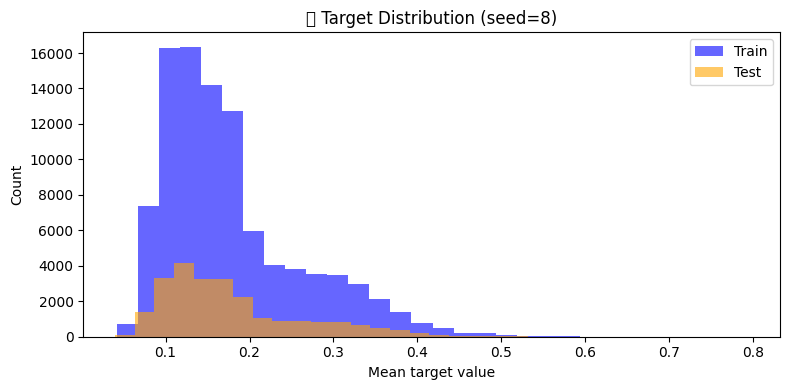

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1042/10000 [00:04<00:35, 254.16it/s]

Epoch [1000/10000], Loss: 0.0045


Epochs:  20%|██        | 2030/10000 [00:07<00:31, 254.05it/s]

Epoch [2000/10000], Loss: 0.0033


Epochs:  30%|███       | 3044/10000 [00:11<00:27, 255.52it/s]

Epoch [3000/10000], Loss: 0.0043


Epochs:  40%|████      | 4032/10000 [00:15<00:23, 255.09it/s]

Epoch [4000/10000], Loss: 0.0019


Epochs:  50%|█████     | 5046/10000 [00:19<00:19, 254.17it/s]

Epoch [5000/10000], Loss: 0.0030


Epochs:  54%|█████▍    | 5436/10000 [00:21<00:17, 254.88it/s]


⏹️ Early stopping at epoch 5437

📊 Metrics:
{'MSE': 0.0017683981, 'MAE': 0.030261237, 'R2': 0.7467901274637498}

🔁 Run 10 / 50 (seed = 9)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


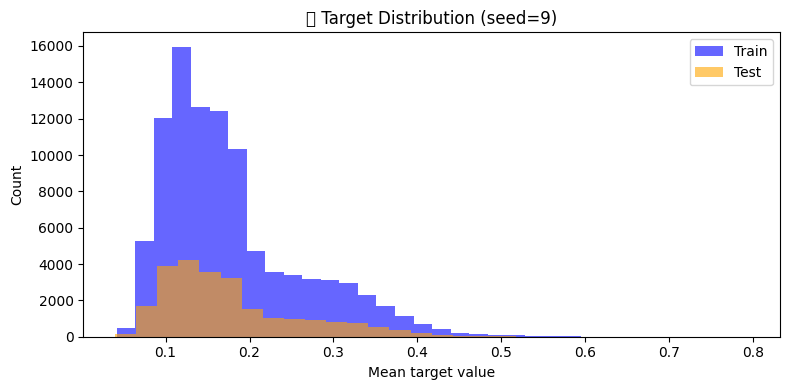

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1042/10000 [00:04<00:35, 253.86it/s]

Epoch [1000/10000], Loss: 0.0040


Epochs:  20%|██        | 2030/10000 [00:07<00:31, 254.34it/s]

Epoch [2000/10000], Loss: 0.0042


Epochs:  30%|███       | 3044/10000 [00:11<00:27, 254.87it/s]

Epoch [3000/10000], Loss: 0.0026


Epochs:  40%|████      | 4032/10000 [00:15<00:23, 255.28it/s]

Epoch [4000/10000], Loss: 0.0020


Epochs:  50%|█████     | 5046/10000 [00:19<00:19, 255.38it/s]

Epoch [5000/10000], Loss: 0.0016


Epochs:  60%|██████    | 6034/10000 [00:23<00:15, 255.07it/s]

Epoch [6000/10000], Loss: 0.0015


Epochs:  70%|███████   | 7048/10000 [00:27<00:11, 254.49it/s]

Epoch [7000/10000], Loss: 0.0014


Epochs:  76%|███████▋  | 7632/10000 [00:29<00:09, 254.84it/s]


⏹️ Early stopping at epoch 7633

📊 Metrics:
{'MSE': 0.0014001251, 'MAE': 0.026794618, 'R2': 0.7975729017442372}

🔁 Run 11 / 50 (seed = 10)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


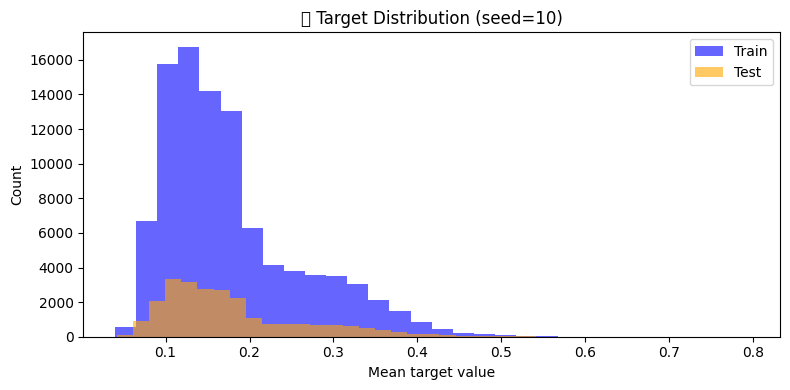

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1042/10000 [00:04<00:35, 252.33it/s]

Epoch [1000/10000], Loss: 0.0044


Epochs:  20%|██        | 2030/10000 [00:07<00:31, 256.50it/s]

Epoch [2000/10000], Loss: 0.0036


Epochs:  30%|███       | 3044/10000 [00:11<00:27, 256.34it/s]

Epoch [3000/10000], Loss: 0.0033


Epochs:  40%|████      | 4032/10000 [00:15<00:23, 256.34it/s]

Epoch [4000/10000], Loss: 0.0027


Epochs:  50%|█████     | 5046/10000 [00:19<00:19, 255.62it/s]

Epoch [5000/10000], Loss: 0.0030


Epochs:  55%|█████▌    | 5526/10000 [00:21<00:17, 255.62it/s]


⏹️ Early stopping at epoch 5527

📊 Metrics:
{'MSE': 0.0021493493, 'MAE': 0.031897258, 'R2': 0.6926194241089167}

🔁 Run 12 / 50 (seed = 11)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


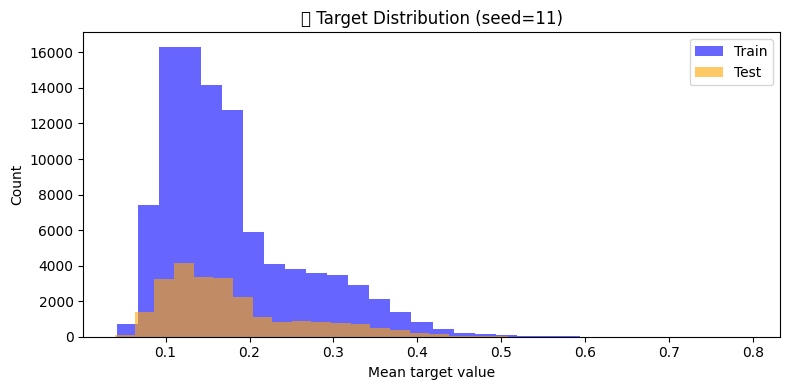

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1042/10000 [00:04<00:35, 254.90it/s]

Epoch [1000/10000], Loss: 0.0043


Epochs:  20%|██        | 2030/10000 [00:07<00:31, 254.19it/s]

Epoch [2000/10000], Loss: 0.0034


Epochs:  30%|███       | 3044/10000 [00:11<00:27, 254.76it/s]

Epoch [3000/10000], Loss: 0.0021


Epochs:  40%|████      | 4032/10000 [00:15<00:23, 255.20it/s]

Epoch [4000/10000], Loss: 0.0016


Epochs:  50%|█████     | 5046/10000 [00:19<00:19, 255.16it/s]

Epoch [5000/10000], Loss: 0.0014


Epochs:  60%|██████    | 6034/10000 [00:23<00:15, 253.75it/s]

Epoch [6000/10000], Loss: 0.0013


Epochs:  69%|██████▉   | 6940/10000 [00:27<00:12, 254.73it/s]


⏹️ Early stopping at epoch 6941

📊 Metrics:
{'MSE': 0.0011117707, 'MAE': 0.02321195, 'R2': 0.8387929547117017}

🔁 Run 13 / 50 (seed = 12)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


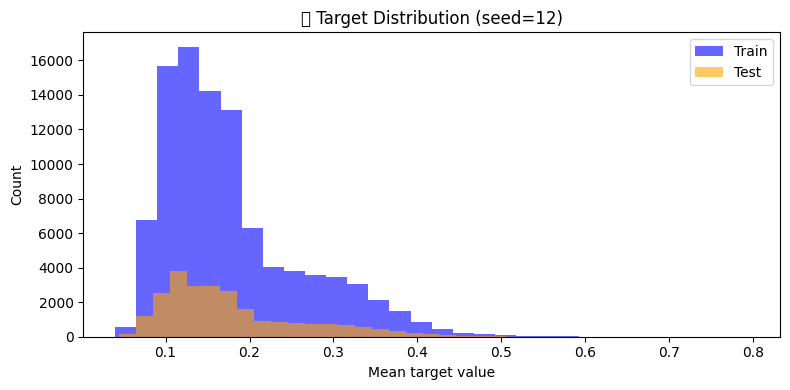

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1042/10000 [00:04<00:35, 254.96it/s]

Epoch [1000/10000], Loss: 0.0038


Epochs:  20%|██        | 2030/10000 [00:07<00:31, 254.73it/s]

Epoch [2000/10000], Loss: 0.0027


Epochs:  30%|███       | 3044/10000 [00:11<00:27, 254.97it/s]

Epoch [3000/10000], Loss: 0.0019


Epochs:  40%|████      | 4032/10000 [00:15<00:23, 254.23it/s]

Epoch [4000/10000], Loss: 0.0015


Epochs:  50%|█████     | 5046/10000 [00:19<00:19, 254.44it/s]

Epoch [5000/10000], Loss: 0.0013


Epochs:  55%|█████▍    | 5477/10000 [00:21<00:17, 254.62it/s]


⏹️ Early stopping at epoch 5478

📊 Metrics:
{'MSE': 0.0013526239, 'MAE': 0.02601899, 'R2': 0.804458302666287}

🔁 Run 14 / 50 (seed = 13)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


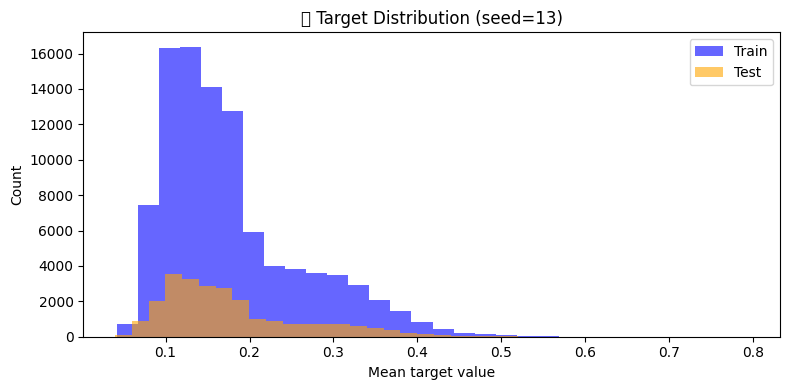

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1043/10000 [00:04<00:34, 256.64it/s]

Epoch [1000/10000], Loss: 0.0045


Epochs:  19%|█▉        | 1902/10000 [00:07<00:31, 255.78it/s]


⏹️ Early stopping at epoch 1903

📊 Metrics:
{'MSE': 0.003230084, 'MAE': 0.04196421, 'R2': 0.5356611399674593}

🔁 Run 15 / 50 (seed = 14)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


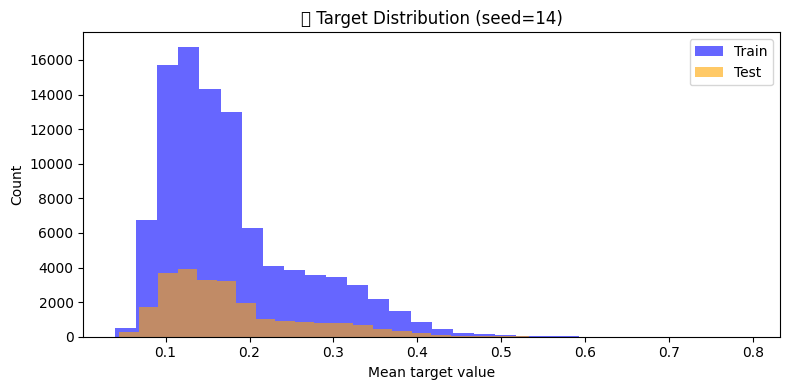

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1042/10000 [00:04<00:35, 255.11it/s]

Epoch [1000/10000], Loss: 0.0040


Epochs:  20%|██        | 2030/10000 [00:07<00:31, 255.28it/s]

Epoch [2000/10000], Loss: 0.0037


Epochs:  30%|███       | 3044/10000 [00:11<00:27, 255.23it/s]

Epoch [3000/10000], Loss: 0.0023


Epochs:  40%|████      | 4032/10000 [00:15<00:23, 254.90it/s]

Epoch [4000/10000], Loss: 0.0022


Epochs:  50%|█████     | 5046/10000 [00:19<00:19, 252.25it/s]

Epoch [5000/10000], Loss: 0.0034


Epochs:  60%|██████    | 6034/10000 [00:23<00:15, 254.65it/s]

Epoch [6000/10000], Loss: 0.0015


Epochs:  63%|██████▎   | 6252/10000 [00:24<00:14, 254.61it/s]


⏹️ Early stopping at epoch 6253

📊 Metrics:
{'MSE': 0.0020673322, 'MAE': 0.032231003, 'R2': 0.7019988659247716}

🔁 Run 16 / 50 (seed = 15)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


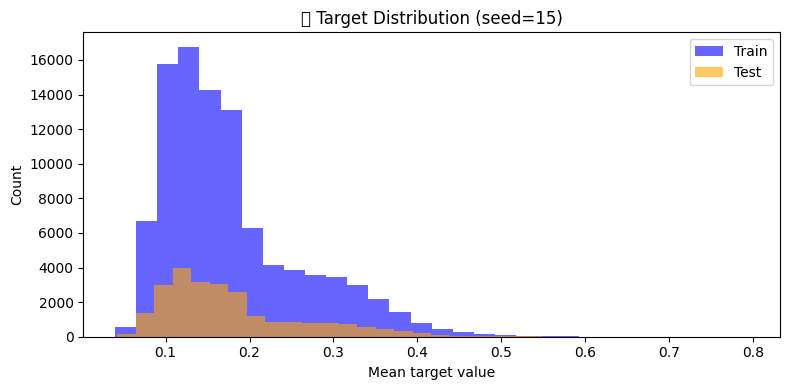

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1042/10000 [00:04<00:34, 256.31it/s]

Epoch [1000/10000], Loss: 0.0054


Epochs:  13%|█▎        | 1320/10000 [00:05<00:34, 255.11it/s]


⏹️ Early stopping at epoch 1321

📊 Metrics:
{'MSE': 0.0035616967, 'MAE': 0.044179972, 'R2': 0.49744466777309393}

🔁 Run 17 / 50 (seed = 16)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


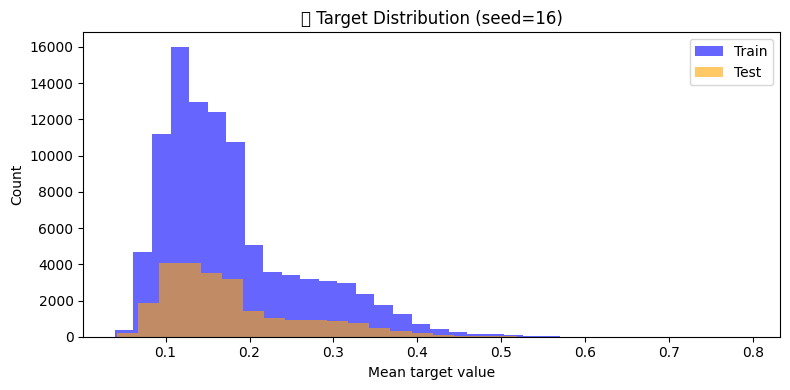

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1042/10000 [00:04<00:35, 253.99it/s]

Epoch [1000/10000], Loss: 0.0040


Epochs:  20%|█▉        | 1963/10000 [00:07<00:31, 254.21it/s]


⏹️ Early stopping at epoch 1964

📊 Metrics:
{'MSE': 0.0032659513, 'MAE': 0.04206359, 'R2': 0.5264897356251663}

🔁 Run 18 / 50 (seed = 17)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


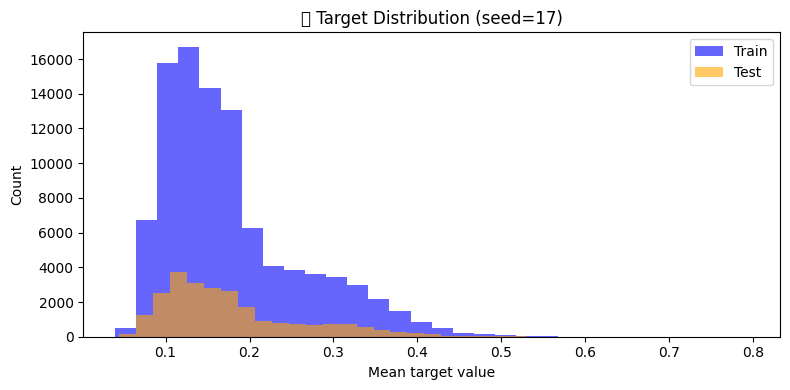

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1042/10000 [00:04<00:35, 255.26it/s]

Epoch [1000/10000], Loss: 0.0045


Epochs:  20%|█▉        | 1952/10000 [00:07<00:31, 254.56it/s]


⏹️ Early stopping at epoch 1953

📊 Metrics:
{'MSE': 0.003905622, 'MAE': 0.04527984, 'R2': 0.4443337462365612}

🔁 Run 19 / 50 (seed = 18)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


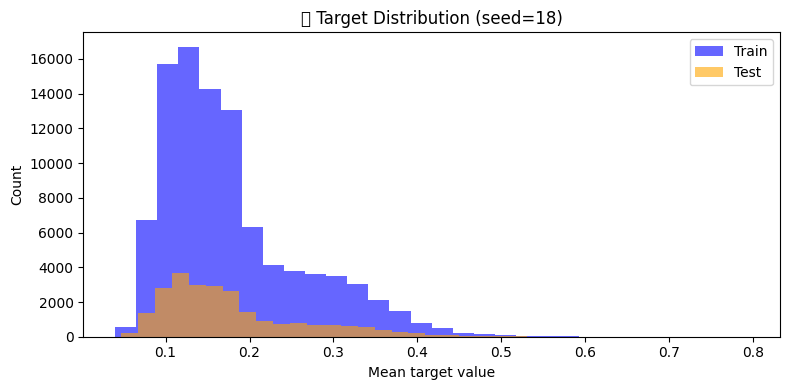

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1042/10000 [00:04<00:35, 253.21it/s]

Epoch [1000/10000], Loss: 0.0037


Epochs:  20%|██        | 2030/10000 [00:07<00:31, 255.08it/s]

Epoch [2000/10000], Loss: 0.0024


Epochs:  30%|███       | 3044/10000 [00:11<00:27, 255.24it/s]

Epoch [3000/10000], Loss: 0.0024


Epochs:  40%|████      | 4032/10000 [00:15<00:23, 254.37it/s]

Epoch [4000/10000], Loss: 0.0016


Epochs:  50%|█████     | 5046/10000 [00:19<00:19, 254.71it/s]

Epoch [5000/10000], Loss: 0.0033


Epochs:  60%|██████    | 6034/10000 [00:23<00:15, 255.34it/s]

Epoch [6000/10000], Loss: 0.0013


Epochs:  62%|██████▏   | 6210/10000 [00:24<00:14, 254.67it/s]


⏹️ Early stopping at epoch 6211

📊 Metrics:
{'MSE': 0.0014377382, 'MAE': 0.026631437, 'R2': 0.7936569291044027}

🔁 Run 20 / 50 (seed = 19)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


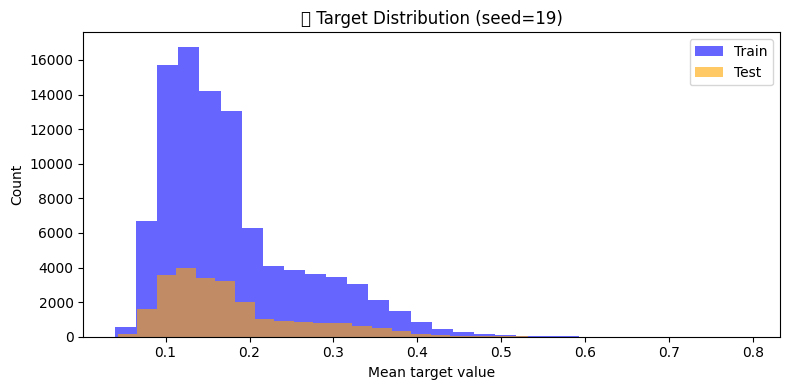

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1042/10000 [00:04<00:35, 255.10it/s]

Epoch [1000/10000], Loss: 0.0041


Epochs:  16%|█▌        | 1600/10000 [00:06<00:32, 254.73it/s]


⏹️ Early stopping at epoch 1601

📊 Metrics:
{'MSE': 0.00372226, 'MAE': 0.045367423, 'R2': 0.46298296419872353}

🔁 Run 21 / 50 (seed = 20)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


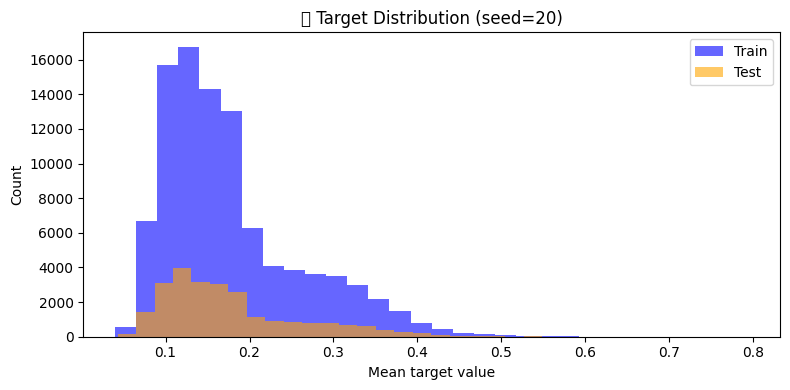

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1043/10000 [00:04<00:35, 253.12it/s]

Epoch [1000/10000], Loss: 0.0041


Epochs:  20%|██        | 2031/10000 [00:07<00:31, 255.77it/s]

Epoch [2000/10000], Loss: 0.0033


Epochs:  21%|██        | 2123/10000 [00:08<00:30, 255.15it/s]


⏹️ Early stopping at epoch 2124

📊 Metrics:
{'MSE': 0.0033799047, 'MAE': 0.04276039, 'R2': 0.5100884295281943}

🔁 Run 22 / 50 (seed = 21)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


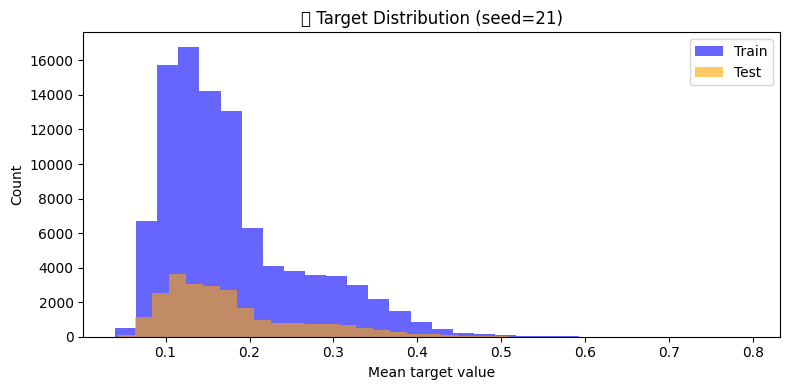

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1042/10000 [00:04<00:35, 255.57it/s]

Epoch [1000/10000], Loss: 0.0046


Epochs:  20%|██        | 2030/10000 [00:07<00:31, 256.59it/s]

Epoch [2000/10000], Loss: 0.0043


Epochs:  30%|███       | 3044/10000 [00:11<00:27, 255.55it/s]

Epoch [3000/10000], Loss: 0.0035


Epochs:  40%|████      | 4032/10000 [00:15<00:23, 255.31it/s]

Epoch [4000/10000], Loss: 0.0028


Epochs:  45%|████▌     | 4519/10000 [00:17<00:21, 255.48it/s]


⏹️ Early stopping at epoch 4520

📊 Metrics:
{'MSE': 0.002819533, 'MAE': 0.036919672, 'R2': 0.5908323889092475}

🔁 Run 23 / 50 (seed = 22)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


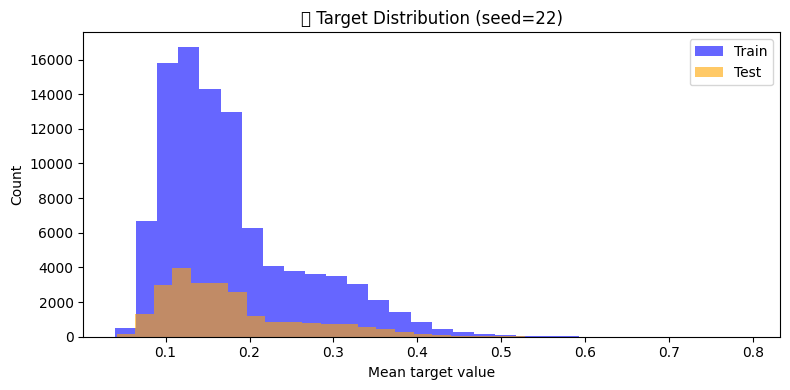

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1042/10000 [00:04<00:35, 255.78it/s]

Epoch [1000/10000], Loss: 0.0040


Epochs:  20%|██        | 2030/10000 [00:07<00:31, 255.14it/s]

Epoch [2000/10000], Loss: 0.0041


Epochs:  30%|███       | 3044/10000 [00:11<00:27, 254.17it/s]

Epoch [3000/10000], Loss: 0.0020


Epochs:  40%|████      | 4032/10000 [00:15<00:23, 255.75it/s]

Epoch [4000/10000], Loss: 0.0016


Epochs:  50%|█████     | 5046/10000 [00:19<00:19, 255.54it/s]

Epoch [5000/10000], Loss: 0.0014


Epochs:  60%|█████▉    | 5974/10000 [00:23<00:15, 255.17it/s]


⏹️ Early stopping at epoch 5975

📊 Metrics:
{'MSE': 0.0013325937, 'MAE': 0.025508009, 'R2': 0.8081696097981528}

🔁 Run 24 / 50 (seed = 23)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


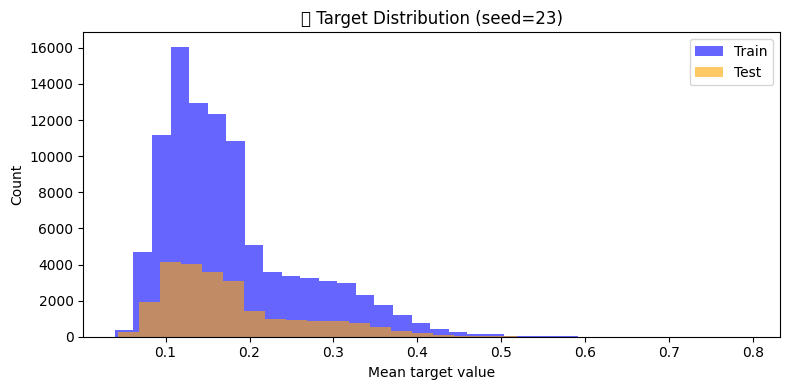

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1042/10000 [00:04<00:35, 254.82it/s]

Epoch [1000/10000], Loss: 0.0035


Epochs:  20%|██        | 2030/10000 [00:07<00:31, 253.25it/s]

Epoch [2000/10000], Loss: 0.0026


Epochs:  30%|███       | 3044/10000 [00:11<00:27, 255.43it/s]

Epoch [3000/10000], Loss: 0.0025


Epochs:  40%|████      | 4032/10000 [00:15<00:23, 254.11it/s]

Epoch [4000/10000], Loss: 0.0021


Epochs:  50%|█████     | 5046/10000 [00:19<00:19, 254.61it/s]

Epoch [5000/10000], Loss: 0.0018


Epochs:  60%|██████    | 6034/10000 [00:23<00:15, 254.73it/s]

Epoch [6000/10000], Loss: 0.0015


Epochs:  65%|██████▌   | 6520/10000 [00:25<00:13, 254.76it/s]


⏹️ Early stopping at epoch 6521

📊 Metrics:
{'MSE': 0.0015978507, 'MAE': 0.028466813, 'R2': 0.772158145333142}

🔁 Run 25 / 50 (seed = 24)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


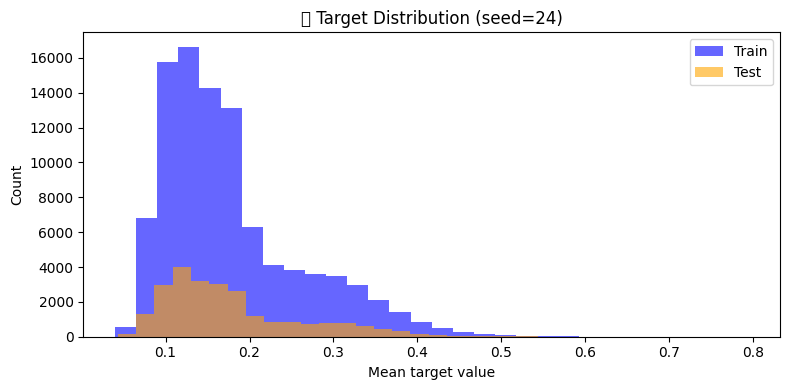

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1042/10000 [00:04<00:35, 255.00it/s]

Epoch [1000/10000], Loss: 0.0039


Epochs:  20%|██        | 2030/10000 [00:07<00:31, 254.64it/s]

Epoch [2000/10000], Loss: 0.0037


Epochs:  30%|███       | 3044/10000 [00:11<00:27, 254.63it/s]

Epoch [3000/10000], Loss: 0.0022


Epochs:  40%|████      | 4032/10000 [00:15<00:23, 255.41it/s]

Epoch [4000/10000], Loss: 0.0019


Epochs:  50%|█████     | 5046/10000 [00:19<00:19, 254.76it/s]

Epoch [5000/10000], Loss: 0.0018


Epochs:  60%|██████    | 6034/10000 [00:23<00:15, 255.73it/s]

Epoch [6000/10000], Loss: 0.0015


Epochs:  62%|██████▏   | 6181/10000 [00:24<00:14, 254.71it/s]


⏹️ Early stopping at epoch 6182

📊 Metrics:
{'MSE': 0.0015518991, 'MAE': 0.027297039, 'R2': 0.7770453972931656}

🔁 Run 26 / 50 (seed = 25)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


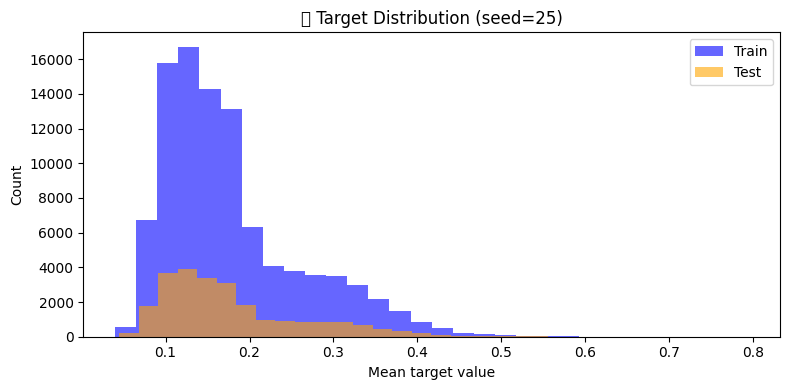

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1042/10000 [00:04<00:35, 254.79it/s]

Epoch [1000/10000], Loss: 0.0042


Epochs:  17%|█▋        | 1709/10000 [00:06<00:32, 254.78it/s]


⏹️ Early stopping at epoch 1710

📊 Metrics:
{'MSE': 0.0041321903, 'MAE': 0.04755931, 'R2': 0.4189050182379388}

🔁 Run 27 / 50 (seed = 26)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


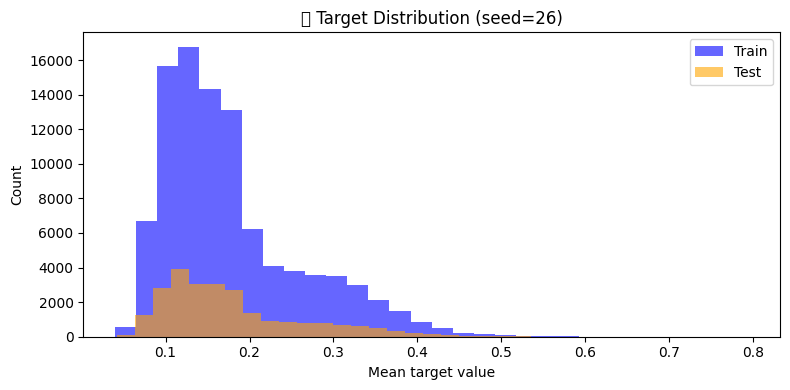

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1043/10000 [00:04<00:35, 255.82it/s]

Epoch [1000/10000], Loss: 0.0045


Epochs:  20%|██        | 2031/10000 [00:07<00:31, 255.90it/s]

Epoch [2000/10000], Loss: 0.0038


Epochs:  30%|███       | 3045/10000 [00:11<00:27, 254.93it/s]

Epoch [3000/10000], Loss: 0.0025


Epochs:  40%|████      | 4033/10000 [00:15<00:23, 254.74it/s]

Epoch [4000/10000], Loss: 0.0030


Epochs:  50%|█████     | 5047/10000 [00:19<00:19, 253.62it/s]

Epoch [5000/10000], Loss: 0.0018


Epochs:  60%|██████    | 6035/10000 [00:23<00:15, 255.51it/s]

Epoch [6000/10000], Loss: 0.0017


Epochs:  68%|██████▊   | 6809/10000 [00:26<00:12, 255.11it/s]


⏹️ Early stopping at epoch 6810

📊 Metrics:
{'MSE': 0.0015693038, 'MAE': 0.026691586, 'R2': 0.7726997187599804}

🔁 Run 28 / 50 (seed = 27)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


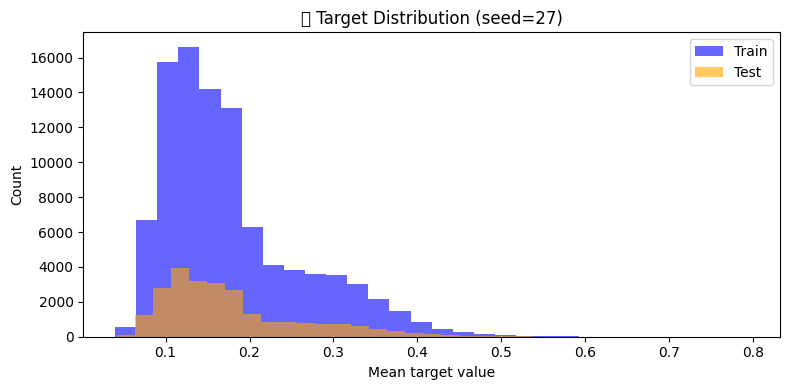

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1042/10000 [00:04<00:35, 254.77it/s]

Epoch [1000/10000], Loss: 0.0036


Epochs:  20%|██        | 2030/10000 [00:07<00:31, 255.39it/s]

Epoch [2000/10000], Loss: 0.0029


Epochs:  30%|███       | 3044/10000 [00:11<00:27, 253.71it/s]

Epoch [3000/10000], Loss: 0.0024


Epochs:  40%|████      | 4032/10000 [00:15<00:23, 254.56it/s]

Epoch [4000/10000], Loss: 0.0026


Epochs:  47%|████▋     | 4741/10000 [00:18<00:20, 254.75it/s]


⏹️ Early stopping at epoch 4742

📊 Metrics:
{'MSE': 0.0021054542, 'MAE': 0.030931018, 'R2': 0.6940929348603586}

🔁 Run 29 / 50 (seed = 28)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


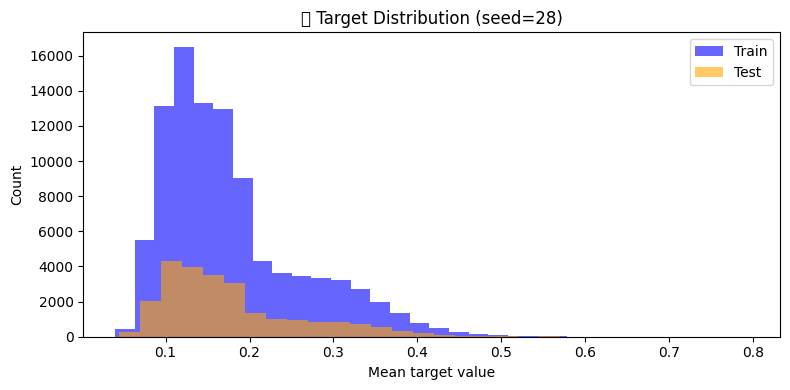

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1042/10000 [00:04<00:34, 256.00it/s]

Epoch [1000/10000], Loss: 0.0039


Epochs:  18%|█▊        | 1810/10000 [00:07<00:32, 254.59it/s]


⏹️ Early stopping at epoch 1811

📊 Metrics:
{'MSE': 0.0031113303, 'MAE': 0.04103831, 'R2': 0.545384490903277}

🔁 Run 30 / 50 (seed = 29)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


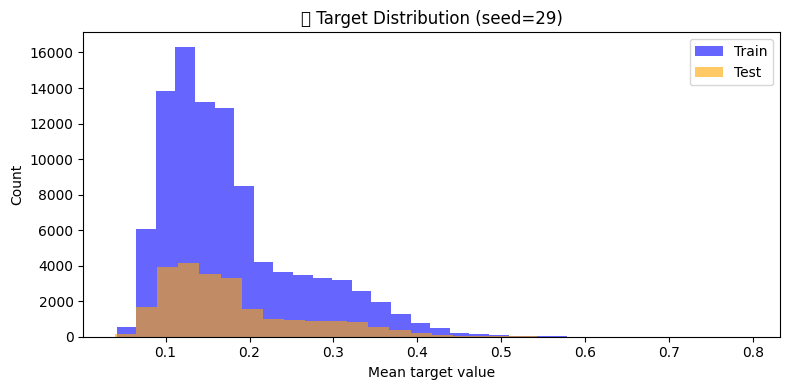

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1042/10000 [00:04<00:35, 254.91it/s]

Epoch [1000/10000], Loss: 0.0043


Epochs:  20%|██        | 2030/10000 [00:07<00:31, 255.69it/s]

Epoch [2000/10000], Loss: 0.0038


Epochs:  30%|███       | 3044/10000 [00:11<00:27, 254.87it/s]

Epoch [3000/10000], Loss: 0.0038


Epochs:  34%|███▍      | 3404/10000 [00:13<00:25, 255.06it/s]


⏹️ Early stopping at epoch 3405

📊 Metrics:
{'MSE': 0.0045088977, 'MAE': 0.055037398, 'R2': 0.3585162832391193}

🔁 Run 31 / 50 (seed = 30)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


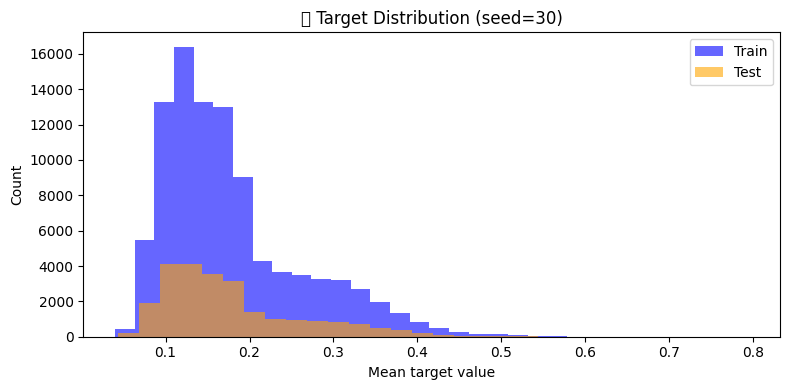

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1042/10000 [00:04<00:35, 255.02it/s]

Epoch [1000/10000], Loss: 0.0037


Epochs:  20%|██        | 2030/10000 [00:07<00:31, 254.44it/s]

Epoch [2000/10000], Loss: 0.0027


Epochs:  30%|███       | 3044/10000 [00:11<00:27, 253.13it/s]

Epoch [3000/10000], Loss: 0.0022


Epochs:  40%|████      | 4032/10000 [00:15<00:23, 255.55it/s]

Epoch [4000/10000], Loss: 0.0019


Epochs:  50%|█████     | 5046/10000 [00:19<00:19, 254.72it/s]

Epoch [5000/10000], Loss: 0.0016


Epochs:  51%|█████▏    | 5129/10000 [00:20<00:19, 254.64it/s]


⏹️ Early stopping at epoch 5130

📊 Metrics:
{'MSE': 0.0016880385, 'MAE': 0.029148499, 'R2': 0.7542335841883723}

🔁 Run 32 / 50 (seed = 31)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


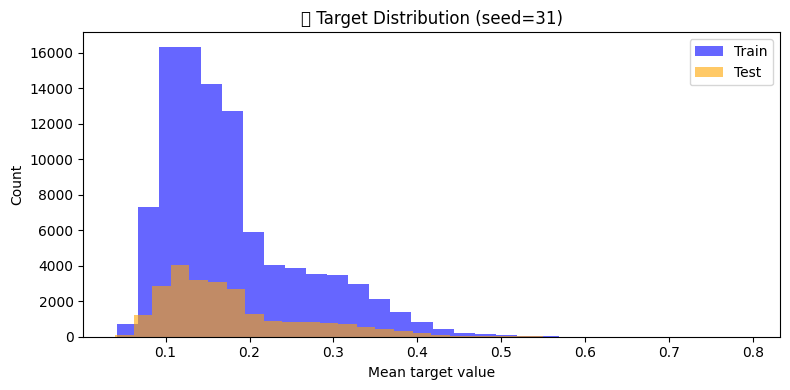

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1042/10000 [00:04<00:35, 254.50it/s]

Epoch [1000/10000], Loss: 0.0040


Epochs:  20%|██        | 2030/10000 [00:07<00:31, 254.61it/s]

Epoch [2000/10000], Loss: 0.0031


Epochs:  30%|███       | 3044/10000 [00:11<00:27, 255.43it/s]

Epoch [3000/10000], Loss: 0.0027


Epochs:  40%|████      | 4032/10000 [00:15<00:23, 255.53it/s]

Epoch [4000/10000], Loss: 0.0022


Epochs:  50%|█████     | 5013/10000 [00:19<00:19, 255.05it/s]


Epoch [5000/10000], Loss: 0.0018
⏹️ Early stopping at epoch 5014

📊 Metrics:
{'MSE': 0.0018526588, 'MAE': 0.031885855, 'R2': 0.7347086360698059}

🔁 Run 33 / 50 (seed = 32)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


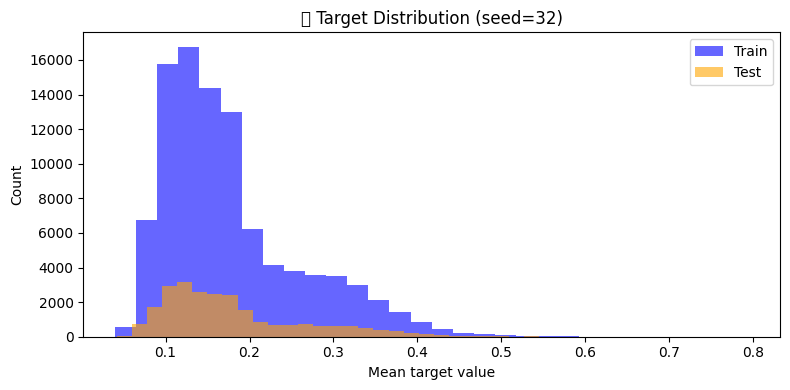

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1042/10000 [00:04<00:35, 255.05it/s]

Epoch [1000/10000], Loss: 0.0042


Epochs:  20%|██        | 2030/10000 [00:07<00:31, 252.15it/s]

Epoch [2000/10000], Loss: 0.0030


Epochs:  25%|██▌       | 2544/10000 [00:10<00:29, 254.39it/s]


⏹️ Early stopping at epoch 2545

📊 Metrics:
{'MSE': 0.0025234285, 'MAE': 0.0368384, 'R2': 0.6388187521275674}

🔁 Run 34 / 50 (seed = 33)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


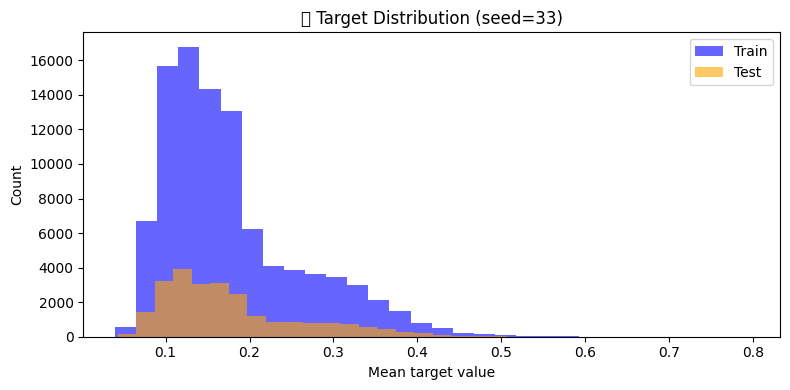

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1042/10000 [00:04<00:35, 254.90it/s]

Epoch [1000/10000], Loss: 0.0046


Epochs:  20%|██        | 2030/10000 [00:07<00:31, 255.44it/s]

Epoch [2000/10000], Loss: 0.0047


Epochs:  30%|███       | 3044/10000 [00:11<00:27, 255.22it/s]

Epoch [3000/10000], Loss: 0.0025


Epochs:  40%|████      | 4032/10000 [00:15<00:23, 254.61it/s]

Epoch [4000/10000], Loss: 0.0020


Epochs:  50%|█████     | 5046/10000 [00:19<00:19, 255.09it/s]

Epoch [5000/10000], Loss: 0.0018


Epochs:  60%|██████    | 6034/10000 [00:23<00:15, 254.97it/s]

Epoch [6000/10000], Loss: 0.0015


Epochs:  63%|██████▎   | 6317/10000 [00:24<00:14, 255.13it/s]


⏹️ Early stopping at epoch 6318

📊 Metrics:
{'MSE': 0.0017222901, 'MAE': 0.028943373, 'R2': 0.7542635720150979}

🔁 Run 35 / 50 (seed = 34)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


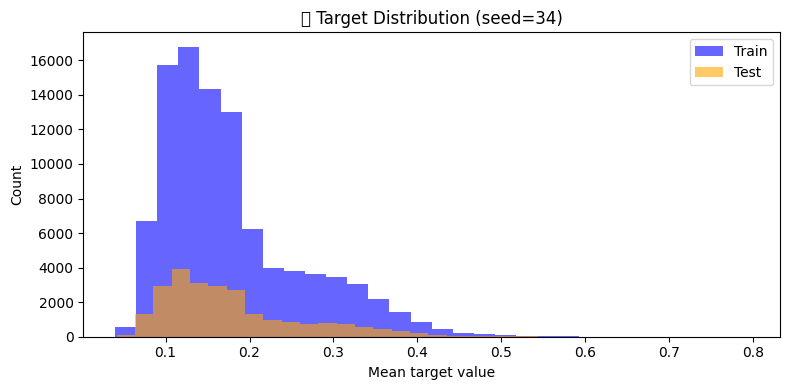

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1042/10000 [00:04<00:35, 254.97it/s]

Epoch [1000/10000], Loss: 0.0054


Epochs:  20%|██        | 2030/10000 [00:07<00:31, 254.96it/s]

Epoch [2000/10000], Loss: 0.0031


Epochs:  30%|███       | 3044/10000 [00:11<00:27, 254.74it/s]

Epoch [3000/10000], Loss: 0.0021


Epochs:  40%|████      | 4032/10000 [00:15<00:23, 254.38it/s]

Epoch [4000/10000], Loss: 0.0017


Epochs:  50%|████▉     | 4979/10000 [00:19<00:19, 254.80it/s]


⏹️ Early stopping at epoch 4980

📊 Metrics:
{'MSE': 0.0015893494, 'MAE': 0.027655909, 'R2': 0.7704546974788249}

🔁 Run 36 / 50 (seed = 35)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


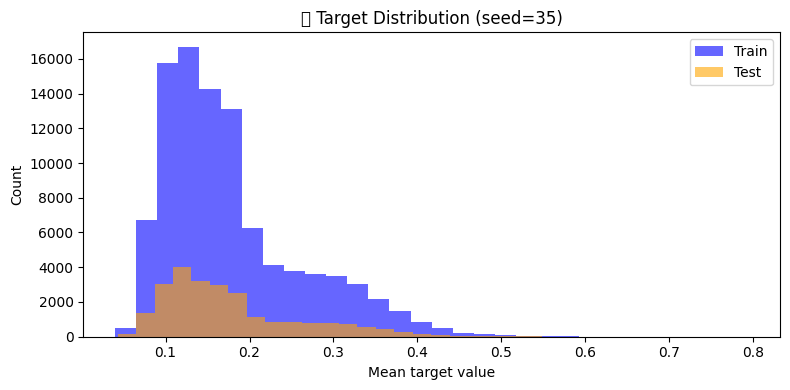

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1042/10000 [00:04<00:35, 255.58it/s]

Epoch [1000/10000], Loss: 0.0035


Epochs:  20%|██        | 2030/10000 [00:07<00:31, 256.05it/s]

Epoch [2000/10000], Loss: 0.0032


Epochs:  30%|███       | 3044/10000 [00:11<00:27, 254.92it/s]

Epoch [3000/10000], Loss: 0.0030


Epochs:  40%|████      | 4032/10000 [00:15<00:23, 253.83it/s]

Epoch [4000/10000], Loss: 0.0021


Epochs:  50%|█████     | 5046/10000 [00:19<00:19, 255.61it/s]

Epoch [5000/10000], Loss: 0.0020


Epochs:  60%|█████▉    | 5987/10000 [00:23<00:15, 255.39it/s]


⏹️ Early stopping at epoch 5988

📊 Metrics:
{'MSE': 0.0015776257, 'MAE': 0.026971191, 'R2': 0.7741456454995534}

🔁 Run 37 / 50 (seed = 36)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


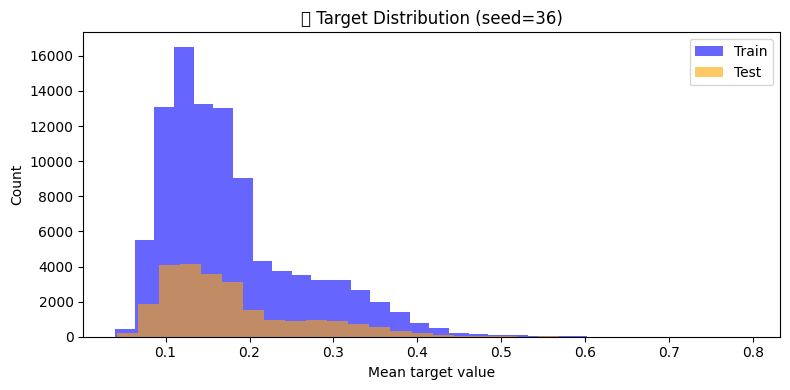

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1042/10000 [00:04<00:35, 255.25it/s]

Epoch [1000/10000], Loss: 0.0040


Epochs:  20%|██        | 2030/10000 [00:07<00:31, 253.57it/s]

Epoch [2000/10000], Loss: 0.0030


Epochs:  30%|███       | 3044/10000 [00:11<00:27, 255.59it/s]

Epoch [3000/10000], Loss: 0.0025


Epochs:  40%|████      | 4032/10000 [00:15<00:23, 255.45it/s]

Epoch [4000/10000], Loss: 0.0022


Epochs:  50%|█████     | 5046/10000 [00:19<00:19, 254.77it/s]

Epoch [5000/10000], Loss: 0.0023


Epochs:  60%|██████    | 6034/10000 [00:23<00:15, 253.78it/s]

Epoch [6000/10000], Loss: 0.0019


Epochs:  63%|██████▎   | 6253/10000 [00:24<00:14, 254.78it/s]


⏹️ Early stopping at epoch 6254

📊 Metrics:
{'MSE': 0.0017271012, 'MAE': 0.02861831, 'R2': 0.7502561888798837}

🔁 Run 38 / 50 (seed = 37)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


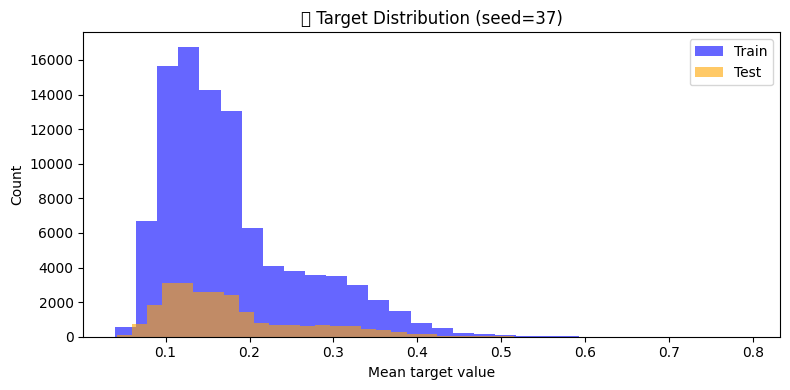

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1043/10000 [00:04<00:35, 254.67it/s]

Epoch [1000/10000], Loss: 0.0041


Epochs:  20%|██        | 2031/10000 [00:07<00:31, 255.20it/s]

Epoch [2000/10000], Loss: 0.0050


Epochs:  30%|███       | 3045/10000 [00:11<00:27, 255.70it/s]

Epoch [3000/10000], Loss: 0.0027


Epochs:  40%|████      | 4033/10000 [00:15<00:23, 254.54it/s]

Epoch [4000/10000], Loss: 0.0017


Epochs:  50%|█████     | 5047/10000 [00:19<00:19, 254.74it/s]

Epoch [5000/10000], Loss: 0.0014


Epochs:  60%|██████    | 6035/10000 [00:23<00:15, 254.73it/s]

Epoch [6000/10000], Loss: 0.0013


Epochs:  65%|██████▌   | 6524/10000 [00:25<00:13, 254.78it/s]


⏹️ Early stopping at epoch 6525

📊 Metrics:
{'MSE': 0.0012468885, 'MAE': 0.024803042, 'R2': 0.8203500502844129}

🔁 Run 39 / 50 (seed = 38)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


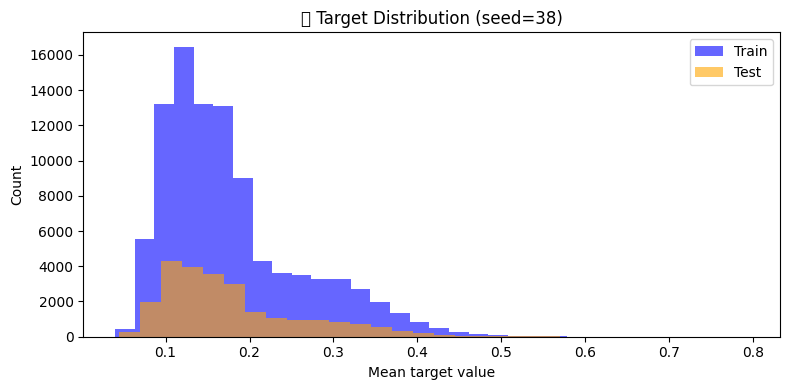

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1042/10000 [00:04<00:35, 253.60it/s]

Epoch [1000/10000], Loss: 0.0037


Epochs:  20%|██        | 2030/10000 [00:07<00:31, 253.52it/s]

Epoch [2000/10000], Loss: 0.0028


Epochs:  30%|███       | 3044/10000 [00:11<00:27, 255.19it/s]

Epoch [3000/10000], Loss: 0.0023


Epochs:  40%|████      | 4032/10000 [00:15<00:23, 254.82it/s]

Epoch [4000/10000], Loss: 0.0019


Epochs:  50%|█████     | 5046/10000 [00:19<00:19, 254.60it/s]

Epoch [5000/10000], Loss: 0.0017


Epochs:  51%|█████▏    | 5132/10000 [00:20<00:19, 254.34it/s]


⏹️ Early stopping at epoch 5133

📊 Metrics:
{'MSE': 0.0024017645, 'MAE': 0.03334778, 'R2': 0.6546433341330469}

🔁 Run 40 / 50 (seed = 39)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


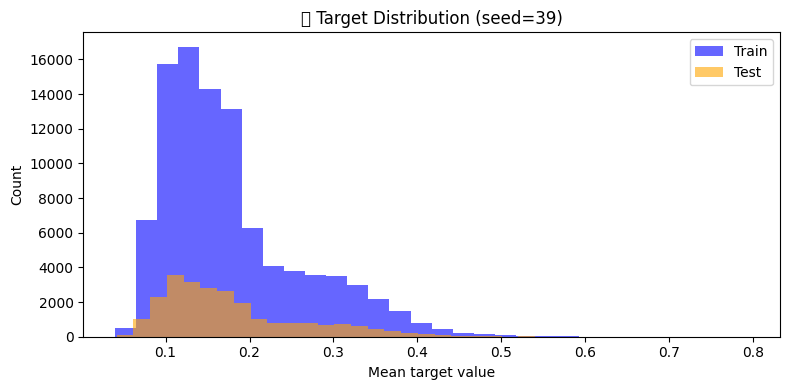

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1042/10000 [00:04<00:35, 254.78it/s]

Epoch [1000/10000], Loss: 0.0032


Epochs:  20%|██        | 2030/10000 [00:07<00:31, 255.50it/s]

Epoch [2000/10000], Loss: 0.0027


Epochs:  30%|███       | 3044/10000 [00:11<00:27, 254.75it/s]

Epoch [3000/10000], Loss: 0.0021


Epochs:  40%|████      | 4032/10000 [00:15<00:23, 255.25it/s]

Epoch [4000/10000], Loss: 0.0020


Epochs:  50%|█████     | 5046/10000 [00:19<00:19, 254.33it/s]

Epoch [5000/10000], Loss: 0.0017


Epochs:  53%|█████▎    | 5341/10000 [00:20<00:18, 254.51it/s]


⏹️ Early stopping at epoch 5342

📊 Metrics:
{'MSE': 0.0015741107, 'MAE': 0.028911727, 'R2': 0.7766345324521622}

🔁 Run 41 / 50 (seed = 40)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


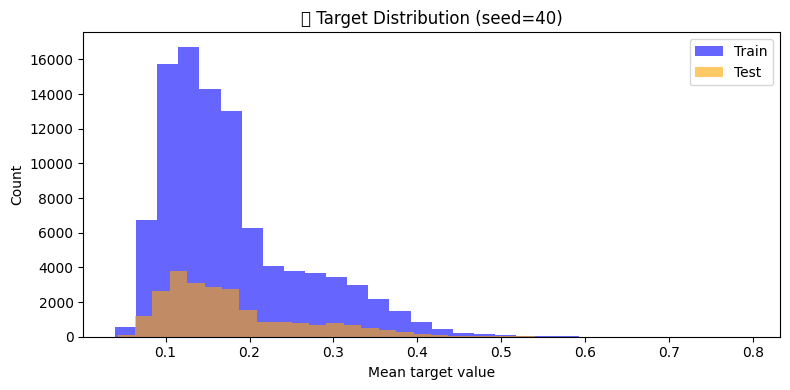

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1042/10000 [00:04<00:35, 254.00it/s]

Epoch [1000/10000], Loss: 0.0038


Epochs:  20%|██        | 2030/10000 [00:07<00:31, 256.13it/s]

Epoch [2000/10000], Loss: 0.0029


Epochs:  30%|███       | 3044/10000 [00:11<00:27, 255.19it/s]

Epoch [3000/10000], Loss: 0.0028


Epochs:  40%|████      | 4032/10000 [00:15<00:23, 255.77it/s]

Epoch [4000/10000], Loss: 0.0022


Epochs:  50%|█████     | 5046/10000 [00:19<00:19, 255.75it/s]

Epoch [5000/10000], Loss: 0.0020


Epochs:  60%|██████    | 6034/10000 [00:23<00:15, 255.96it/s]

Epoch [6000/10000], Loss: 0.0015


Epochs:  70%|███████   | 7048/10000 [00:27<00:11, 255.58it/s]

Epoch [7000/10000], Loss: 0.0014


Epochs:  80%|████████  | 8036/10000 [00:31<00:07, 254.94it/s]

Epoch [8000/10000], Loss: 0.0015


Epochs:  85%|████████▍ | 8474/10000 [00:33<00:05, 255.33it/s]


⏹️ Early stopping at epoch 8475

📊 Metrics:
{'MSE': 0.014169046, 'MAE': 0.10610505, 'R2': -1.049406857706599}

🔁 Run 42 / 50 (seed = 41)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


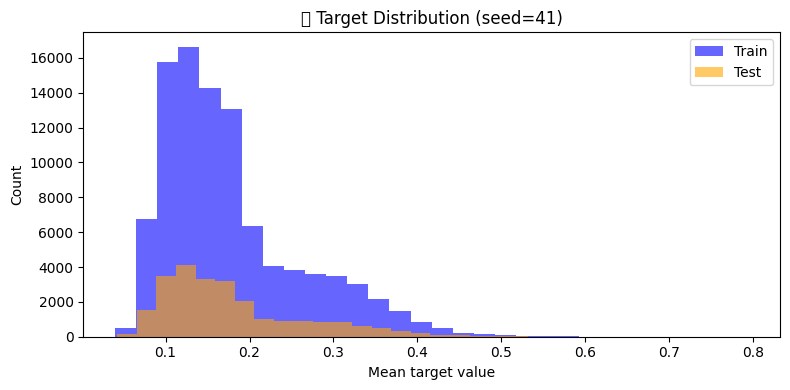

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1042/10000 [00:04<00:35, 254.57it/s]

Epoch [1000/10000], Loss: 0.0046


Epochs:  20%|██        | 2030/10000 [00:07<00:31, 254.70it/s]

Epoch [2000/10000], Loss: 0.0032


Epochs:  30%|███       | 3044/10000 [00:11<00:27, 253.26it/s]

Epoch [3000/10000], Loss: 0.0025


Epochs:  40%|████      | 4032/10000 [00:15<00:23, 255.16it/s]

Epoch [4000/10000], Loss: 0.0022


Epochs:  50%|█████     | 5046/10000 [00:19<00:19, 254.45it/s]

Epoch [5000/10000], Loss: 0.0019


Epochs:  60%|██████    | 6034/10000 [00:23<00:15, 254.82it/s]

Epoch [6000/10000], Loss: 0.0015


Epochs:  65%|██████▌   | 6534/10000 [00:25<00:13, 254.48it/s]


⏹️ Early stopping at epoch 6535

📊 Metrics:
{'MSE': 0.0014792373, 'MAE': 0.027542898, 'R2': 0.7878533083924811}

🔁 Run 43 / 50 (seed = 42)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


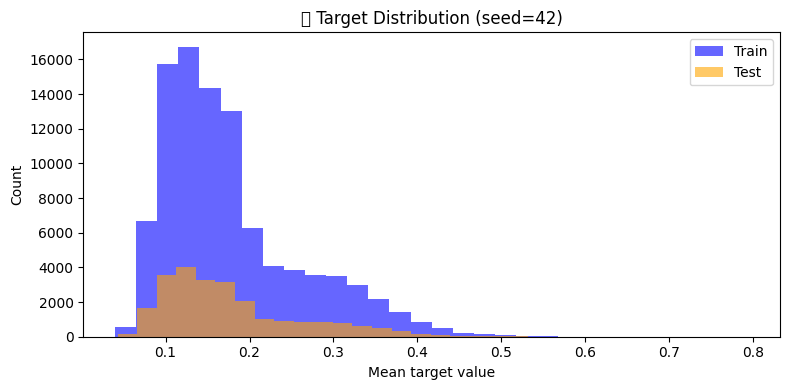

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1043/10000 [00:04<00:35, 255.89it/s]

Epoch [1000/10000], Loss: 0.0043


Epochs:  20%|██        | 2031/10000 [00:07<00:31, 255.38it/s]

Epoch [2000/10000], Loss: 0.0030


Epochs:  30%|███       | 3045/10000 [00:11<00:27, 255.05it/s]

Epoch [3000/10000], Loss: 0.0019


Epochs:  40%|████      | 4033/10000 [00:15<00:23, 255.08it/s]

Epoch [4000/10000], Loss: 0.0015


Epochs:  50%|█████     | 5047/10000 [00:19<00:19, 255.03it/s]

Epoch [5000/10000], Loss: 0.0015


Epochs:  60%|██████    | 6035/10000 [00:23<00:15, 255.31it/s]

Epoch [6000/10000], Loss: 0.0014


Epochs:  66%|██████▌   | 6602/10000 [00:25<00:13, 254.95it/s]


⏹️ Early stopping at epoch 6603

📊 Metrics:
{'MSE': 0.0013539488, 'MAE': 0.02623906, 'R2': 0.8059188470122979}

🔁 Run 44 / 50 (seed = 43)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


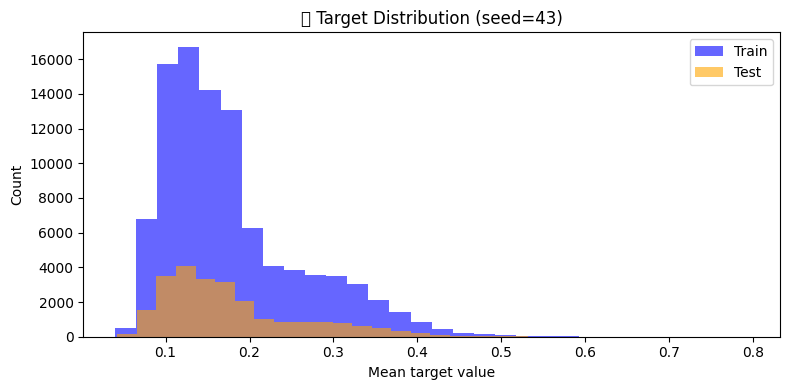

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1042/10000 [00:04<00:34, 256.08it/s]

Epoch [1000/10000], Loss: 0.0041


Epochs:  20%|██        | 2030/10000 [00:07<00:31, 255.91it/s]

Epoch [2000/10000], Loss: 0.0030


Epochs:  30%|███       | 3044/10000 [00:11<00:27, 254.48it/s]

Epoch [3000/10000], Loss: 0.0024


Epochs:  40%|████      | 4032/10000 [00:15<00:23, 256.15it/s]

Epoch [4000/10000], Loss: 0.0016


Epochs:  50%|█████     | 5046/10000 [00:19<00:19, 255.33it/s]

Epoch [5000/10000], Loss: 0.0015


Epochs:  60%|██████    | 6034/10000 [00:23<00:15, 252.94it/s]

Epoch [6000/10000], Loss: 0.0016


Epochs:  66%|██████▌   | 6602/10000 [00:25<00:13, 254.98it/s]


⏹️ Early stopping at epoch 6603

📊 Metrics:
{'MSE': 0.0012557191, 'MAE': 0.024868846, 'R2': 0.8193769022292887}

🔁 Run 45 / 50 (seed = 44)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


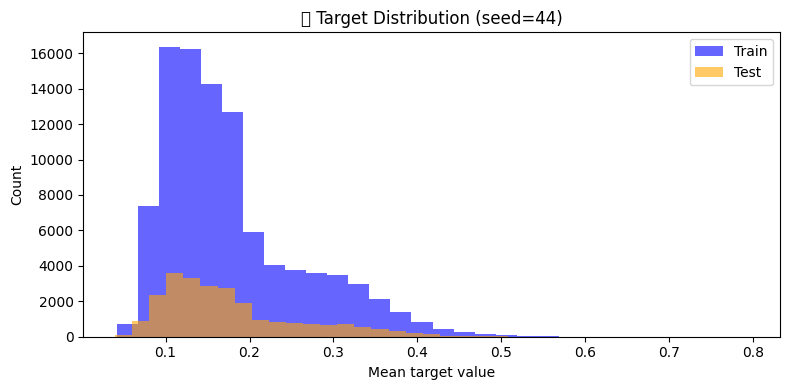

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1042/10000 [00:04<00:35, 255.56it/s]

Epoch [1000/10000], Loss: 0.0037


Epochs:  20%|██        | 2030/10000 [00:07<00:31, 254.16it/s]

Epoch [2000/10000], Loss: 0.0025


Epochs:  30%|███       | 3044/10000 [00:11<00:27, 254.73it/s]

Epoch [3000/10000], Loss: 0.0020


Epochs:  40%|████      | 4032/10000 [00:15<00:23, 253.40it/s]

Epoch [4000/10000], Loss: 0.0018


Epochs:  49%|████▉     | 4935/10000 [00:19<00:19, 254.63it/s]


⏹️ Early stopping at epoch 4936

📊 Metrics:
{'MSE': 0.001788955, 'MAE': 0.02909302, 'R2': 0.7396252287596922}

🔁 Run 46 / 50 (seed = 45)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


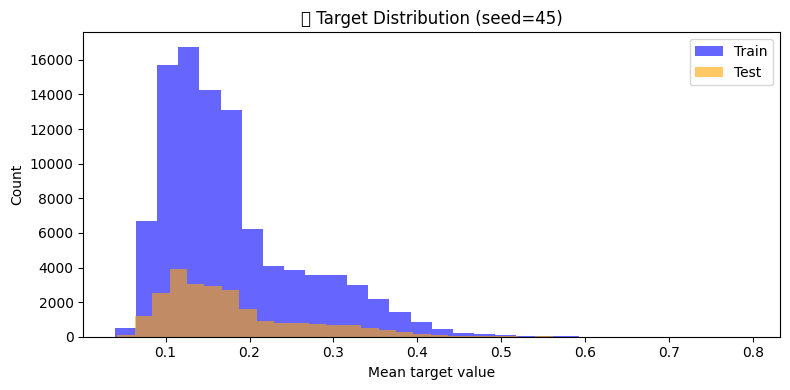

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1043/10000 [00:04<00:35, 255.69it/s]

Epoch [1000/10000], Loss: 0.0040


Epochs:  20%|██        | 2031/10000 [00:07<00:31, 255.34it/s]

Epoch [2000/10000], Loss: 0.0032


Epochs:  30%|███       | 3045/10000 [00:11<00:27, 254.76it/s]

Epoch [3000/10000], Loss: 0.0027


Epochs:  40%|████      | 4033/10000 [00:15<00:23, 254.85it/s]

Epoch [4000/10000], Loss: 0.0019


Epochs:  50%|█████     | 5047/10000 [00:19<00:19, 254.95it/s]

Epoch [5000/10000], Loss: 0.0016


Epochs:  60%|██████    | 6035/10000 [00:23<00:15, 254.95it/s]

Epoch [6000/10000], Loss: 0.0014


Epochs:  67%|██████▋   | 6671/10000 [00:26<00:13, 254.99it/s]


⏹️ Early stopping at epoch 6672

📊 Metrics:
{'MSE': 0.0013811103, 'MAE': 0.025666624, 'R2': 0.8010926773888286}

🔁 Run 47 / 50 (seed = 46)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


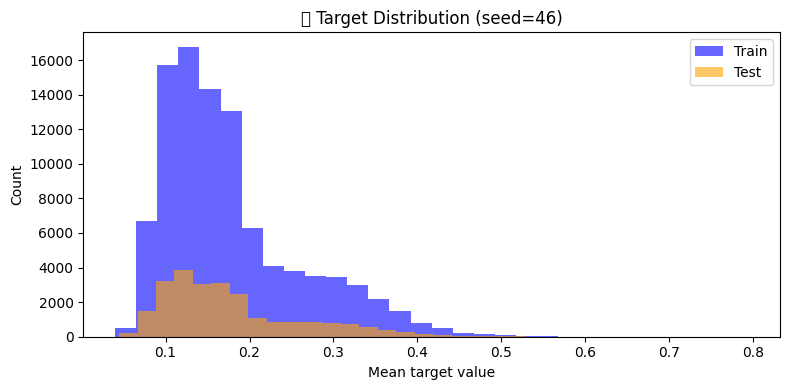

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1042/10000 [00:04<00:35, 254.38it/s]

Epoch [1000/10000], Loss: 0.0040


Epochs:  20%|██        | 2030/10000 [00:07<00:31, 255.12it/s]

Epoch [2000/10000], Loss: 0.0026


Epochs:  30%|███       | 3044/10000 [00:11<00:27, 256.29it/s]

Epoch [3000/10000], Loss: 0.0022


Epochs:  32%|███▏      | 3160/10000 [00:12<00:26, 254.62it/s]


⏹️ Early stopping at epoch 3161

📊 Metrics:
{'MSE': 0.0021140964, 'MAE': 0.032750532, 'R2': 0.6970025265596127}

🔁 Run 48 / 50 (seed = 47)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


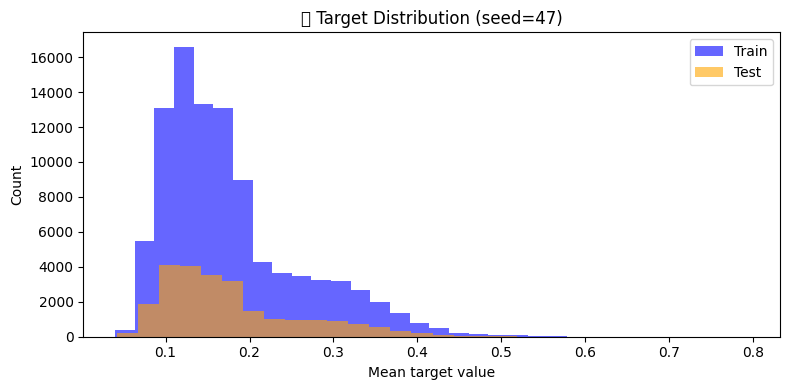

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1042/10000 [00:04<00:35, 255.53it/s]

Epoch [1000/10000], Loss: 0.0049


Epochs:  20%|██        | 2030/10000 [00:07<00:31, 255.07it/s]

Epoch [2000/10000], Loss: 0.0030


Epochs:  30%|███       | 3044/10000 [00:11<00:27, 253.83it/s]

Epoch [3000/10000], Loss: 0.0020


Epochs:  40%|████      | 4032/10000 [00:15<00:23, 255.10it/s]

Epoch [4000/10000], Loss: 0.0015


Epochs:  49%|████▉     | 4876/10000 [00:19<00:20, 254.36it/s]


⏹️ Early stopping at epoch 4877

📊 Metrics:
{'MSE': 0.0013239874, 'MAE': 0.025916701, 'R2': 0.8059784168400141}

🔁 Run 49 / 50 (seed = 48)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


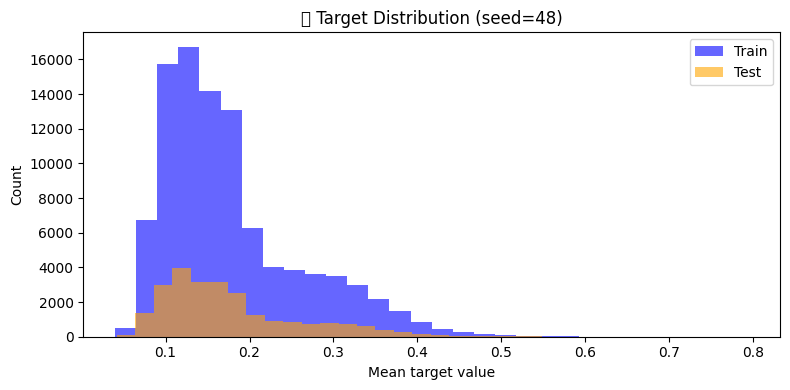

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1042/10000 [00:04<00:34, 256.20it/s]

Epoch [1000/10000], Loss: 0.0043


Epochs:  20%|██        | 2030/10000 [00:07<00:31, 255.97it/s]

Epoch [2000/10000], Loss: 0.0037


Epochs:  30%|███       | 3044/10000 [00:11<00:27, 255.61it/s]

Epoch [3000/10000], Loss: 0.0032


Epochs:  40%|████      | 4032/10000 [00:15<00:23, 253.77it/s]

Epoch [4000/10000], Loss: 0.0030


Epochs:  50%|█████     | 5046/10000 [00:19<00:19, 254.82it/s]

Epoch [5000/10000], Loss: 0.0027


Epochs:  60%|██████    | 6034/10000 [00:23<00:15, 254.41it/s]

Epoch [6000/10000], Loss: 0.0016


Epochs:  67%|██████▋   | 6709/10000 [00:26<00:12, 255.30it/s]


⏹️ Early stopping at epoch 6710

📊 Metrics:
{'MSE': 0.0017176013, 'MAE': 0.028547755, 'R2': 0.7496480197550603}

🔁 Run 50 / 50 (seed = 49)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2818752577.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


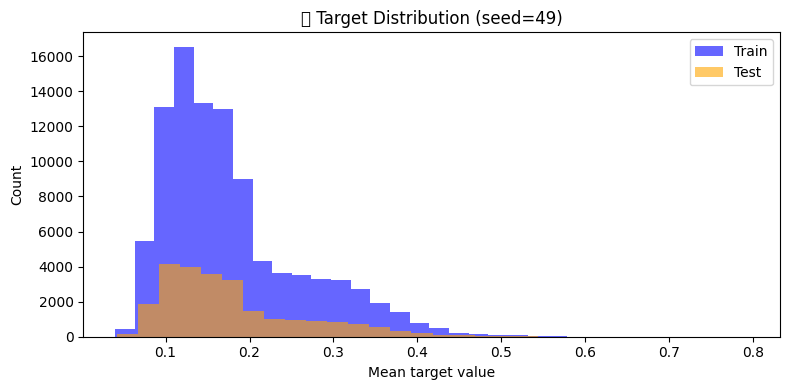

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 1042/10000 [00:04<00:35, 255.50it/s]

Epoch [1000/10000], Loss: 0.0044


Epochs:  20%|██        | 2030/10000 [00:07<00:31, 255.61it/s]

Epoch [2000/10000], Loss: 0.0048


Epochs:  30%|███       | 3044/10000 [00:11<00:27, 254.69it/s]

Epoch [3000/10000], Loss: 0.0026


Epochs:  40%|████      | 4032/10000 [00:15<00:23, 254.39it/s]

Epoch [4000/10000], Loss: 0.0019


Epochs:  50%|█████     | 5046/10000 [00:19<00:19, 252.11it/s]

Epoch [5000/10000], Loss: 0.0017


Epochs:  58%|█████▊    | 5817/10000 [00:22<00:16, 254.80it/s]

⏹️ Early stopping at epoch 5818

📊 Metrics:
{'MSE': 0.0016253161, 'MAE': 0.028681707, 'R2': 0.7652855456110602}
📁 Best weights saved to: /kaggle/working/config_mlp_64h_8e-03lr/best_model_weights_mlp_64h_8e-03lr_16bs_10000ep_Tanh_Adam.pt
🏆 Best run: run_seed_11 with R2 = 0.8388
   R2   = 0.8388
   MAE  = 0.0232
   MSE  = 0.001112


In [16]:
# 📁 src/tuning/run_experiments.py
# ➤ Run MLP training multiple times with different random seeds to assess stability
# ➤ Track and save best model based on R² score
# ➤ Store metrics for each run, save best weights and evaluation report


# 🧠 Prepare model
# 📌 Fixed parameters
EPOCHS = 10000
OUTPUT_DIM = 1
N_RUNS = 50  # Total number of runs

# 📊 Containers to collect results
results_all = []
results_header = ["run", "run_id", "R2", "MAE", "MSE"]
best_r2 = -float("inf")
best_model = None
best_metrics = None
best_run_id = None
train_loss_history = [] 
weights_registry = {}  # run_id -> weights
weights_registry.clear()


# 🔁 Run the same config with different random seeds
for seed in range(N_RUNS):
    print(f"\n🔁 Run {seed + 1} / {N_RUNS} (seed = {seed})")

    # 🏃 Train model with current seed
    run_id, metrics = train_mlp(
        hidden_dim=config["hidden_dim"],
        lr=config["lr"],
        batch_size=config["batch_size"],
        epochs=EPOCHS,
        output_dim=config["output_dim"],
        activation_fn=config["activation_fn"],
        optimizer_name=config["optimizer_name"],
        seed=seed
    )

    # 📥 Collect result for this run
    results_all.append({
        "run": seed,
        "run_id": run_id,
        "R2": metrics["R2"],
        "MAE": metrics["MAE"],
        "MSE": metrics["MSE"]
    })

    # 🏆 Check if it's the best so far
    if metrics["R2"] > best_r2:
        best_r2 = metrics["R2"]
        best_metrics = metrics
        best_run_id = run_id

# 💾 Ensure save directory exists
os.makedirs(SAVE_ROOT, exist_ok=True)

# 💾 Save full metrics log
results_csv_path = os.path.join(SAVE_ROOT, f"results_{arch_label}.csv")
df_results = pd.DataFrame(results_all, columns=results_header)
df_results.to_csv(results_csv_path, index=False)

# 💾 Save best model weights
best_weights = weights_registry[best_run_id]
weights_save_path = os.path.join(SAVE_ROOT, f"best_model_weights_{arch_label}.pt")
torch.save(best_weights, weights_save_path)
print(f"📁 Best weights saved to: {weights_save_path}")

# 💾 Save best run's metrics
best_metrics = {k: float(v) for k, v in best_metrics.items()}
metrics_json_path = os.path.join(SAVE_ROOT, f"metrics_best_{arch_label}.json")
with open(metrics_json_path, "w") as f:
    json.dump(best_metrics, f, indent=4)

print(f"🏆 Best run: {best_run_id} with R2 = {best_r2:.4f}")
print(f"   R2   = {best_metrics['R2']:.4f}")
print(f"   MAE  = {best_metrics['MAE']:.4f}")
print(f"   MSE  = {best_metrics['MSE']:.6f}")

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


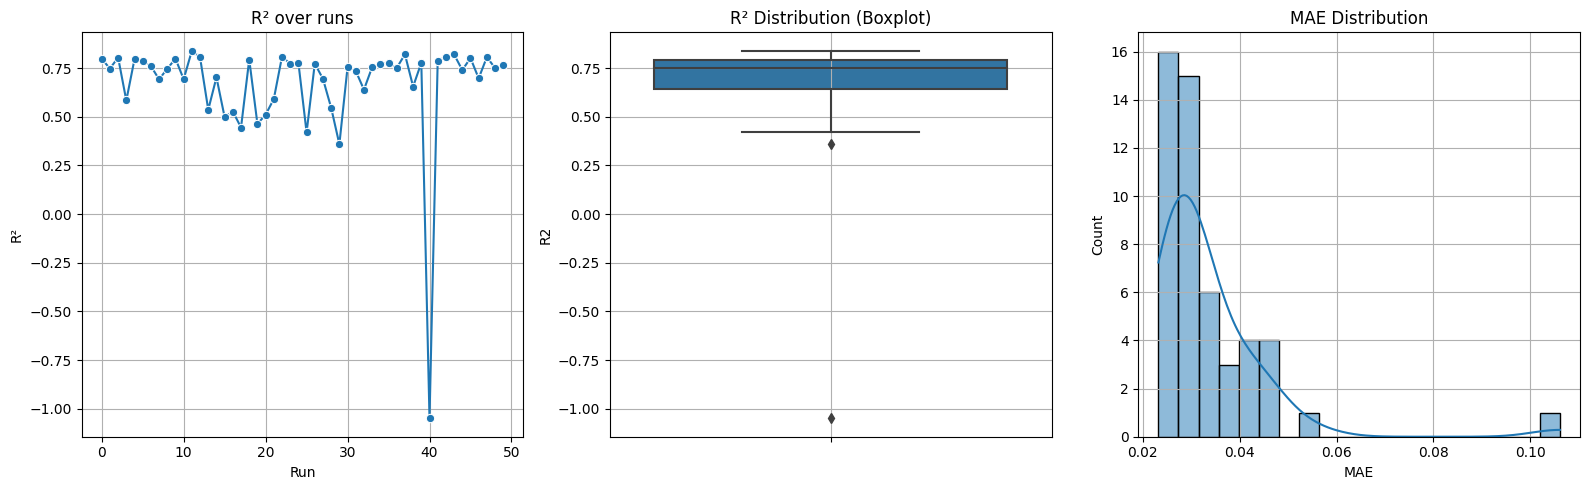

📈 Stability analysis complete:
{
    "R2_mean": 0.6681,
    "R2_std": 0.2763,
    "MAE_mean": 0.0333,
    "MAE_std": 0.0127,
    "MSE_mean": 0.002305,
    "MSE_std": 0.001915,
    "runs": 50
}
📁 Saved metrics: /kaggle/working/config_mlp_64h_8e-03lr/stability_mlp_64h_8e-03lr_16bs_10000ep_Tanh_Adam.json
🖼️  Saved plot: /kaggle/working/config_mlp_64h_8e-03lr/stability_plot_mlp_64h_8e-03lr_16bs_10000ep_Tanh_Adam.png


In [17]:
# 📁 src/tuning/analyze_stability.py
# ➤ Analyze stability of model performance across multiple seeds
# ➤ Compute mean and std for R², MAE, MSE
# ➤ Generate and save visualizations (line plot, boxplot, histogram)
# ➤ Save stability metrics to JSON for reporting and comparison


# 📥 Load results
df = pd.read_csv(results_csv_path)

# 📊 Compute stability stats
stability = {
    "R2_mean":  round(df["R2"].mean(), 4),
    "R2_std":   round(df["R2"].std(), 4),
    "MAE_mean": round(df["MAE"].mean(), 4),
    "MAE_std":  round(df["MAE"].std(), 4),
    "MSE_mean": round(df["MSE"].mean(), 6),
    "MSE_std":  round(df["MSE"].std(), 6),
    "runs": len(df)
}

# 💾 Save stability metrics
stability_path = os.path.join(SAVE_ROOT, f"stability_{arch_label}.json")
with open(stability_path, "w") as f:
    json.dump(stability, f, indent=4)

# 📈 Visualization
plt.figure(figsize=(16, 5))

# 📌 Plot 1: R² over runs
plt.subplot(1, 3, 1)
sns.lineplot(x="run", y="R2", data=df, marker="o", linewidth=1.5)
plt.title("R² over runs")
plt.xlabel("Run")
plt.ylabel("R²")
plt.grid(True)

# 📌 Plot 2: Boxplot of R²
plt.subplot(1, 3, 2)
sns.boxplot(y="R2", data=df)
plt.title("R² Distribution (Boxplot)")
plt.grid(True)

# 📌 Plot 3: Histogram of MAE
plt.subplot(1, 3, 3)
sns.histplot(df["MAE"], bins=20, kde=True)
plt.title("MAE Distribution")
plt.xlabel("MAE")
plt.grid(True)

# 💾 Save the plot
fig_path = os.path.join(SAVE_ROOT, f"stability_plot_{arch_label}.png")
plt.tight_layout()
plt.savefig(fig_path)
plt.show()

# ✅ Output
print("📈 Stability analysis complete:")
print(json.dumps(stability, indent=4))
print(f"📁 Saved metrics: {stability_path}")
print(f"🖼️  Saved plot: {fig_path}")
